In [5]:
import warnings
warnings.filterwarnings('ignore')
import sys
sys.path.append("C:/Users/zhipe/OneDrive/Desktop/Master thesis/demostration")

from causal_ensemble_model import *
from utilities_ensemble import *
from utilities_plotting import *
import numpy as np
import pandas as pd
import seaborn as sns 
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import accuracy_score
from scipy import stats
import matplotlib.pyplot as plt

$${B(t+1)} = 0.87{B(t)} - 0.86{\cos}({A(t)}){B(t-1)} - 1.01{\sin}({A(t-2)}){\exp}({A(t-3)}) + {\epsilon}_{1}$$
$${C(t+1)} = 1.03{A(t-1)}^{2}{C(t-1)} - 1.07{\sin}({A(t-3)}) + 1.32{A(t-4)}{A(t)}{C(t-2)} + {\epsilon}_{2}$$
$${E(t+1)} = -1.24{A(t)}{D(t-1)} - 0.29{\exp}({D(t)}){E(t-3)} + 0.26{\exp}({A(t-2)}){\cos}({D(t-2)}){E(t-1)} + {\epsilon}_{3}$$
A -> B, A -> C A,D -> E

In [6]:
np.random.seed(205)
A = np.random.rand(20005)
np.random.seed(7)
B = np.random.rand(20005)
np.random.seed(94)
C = np.random.rand(20005)
np.random.seed(75)
D = np.random.rand(20005)
np.random.seed(234)
E = np.random.rand(20005)
np.random.seed(40)
e_1 = np.random.normal(size=(20005,)) / 100
np.random.seed(97)
e_2 = np.random.normal(size=(20005,)) / 100
np.random.seed(340)
e_3 = np.random.normal(size=(20005,)) / 100

list_0 = np.linspace(4,20003,20000).astype(int)
for i in list_0:
    B[i+1] = 0.87 * B[i] - 0.86 * np.cos(A[i]) * B[i-1] - 1.01 * np.sin(A[i-2]) * np.exp(A[i-3]) + e_1[i]
    C[i+1] = 1.03 * (A[i-1] ** 2) * C[i-1] - 1.07 * np.sin(A[i-3]) + 1.32 * A[i-4] * A[i] * C[i-2] + e_2[i]
    E[i+1] = -1.24 * A[i] * D[i-1] - 0.29 * np.exp(D[i]) * E[i-3] + 0.26 * np.exp(A[i-2]) * np.cos(D[i-2]) * E[i-1] + e_3[i]

A_0 = A[5:] * 100
B_0 = B[5:] * 100
C_0 = C[5:] * 100
D_0 = D[5:] * 100
E_0 = E[5:] * 100

df = pd.DataFrame({'A': A_0, 'B': B_0, 'C': C_0, 'D': D_0, 'E': E_0})

In [7]:
df

A           B           C          D          E
0      42.732383 -101.809366   53.417117  54.427582 -80.035936
1      27.030100 -364.472754  -36.800091  18.784934 -73.236862
2      63.630325 -414.724472  -52.972260  61.826346 -95.022358
3      87.511809 -214.611603  -52.890690  37.412777 -56.306759
4      31.083155    1.237972 -105.416324  93.358217 -65.107526
...          ...         ...         ...        ...        ...
19995  26.252091 -106.977883 -206.933314   5.624831 -64.334905
19996  95.737222 -181.069937 -140.041840   7.671744 -15.277657
19997  59.363793 -209.293023 -254.015679  21.690583  -9.287885
19998  19.717847  -91.161458 -325.695118  92.585974   6.175443
19999   5.826317   -7.956296 -137.053479  52.889972  35.619014

[20000 rows x 5 columns]

In [8]:
data_use = df
feature_names = data_use.columns.tolist()

In [9]:
df_process = df.copy()

for i in feature_names:
    q3, q1 = np.percentile(df_process[i], [90 ,10])
    iqr = q3 - q1
    upper = q3 + 2 * iqr
    lower = q1 - 2 * iqr
    df_process[i][df_process[i]>upper] = (upper + 0.01)
    df_process[i][df_process[i]<lower] = (lower - 0.01)
    
    n = len(df_process)
    j = 1
    while j < (n-1):
        if df_process[i][j] > upper or df_process[i][j] < lower:
            n_start = j-1
            n_end = j+1
            for k in range(n):
                if df_process[i][n_end] > upper or df_process[i][n_end] < lower:
                    n_end += 1
                    if n_end == n-1:
                        break
                else: 
                    break
            num = n_end - n_start - 1
            for l in range(num):
                df_process[i][j+l] = ((df_process[i][n_end] 
                                       - df_process[i][n_start]) 
                                      / (num+1) 
                                      * (l+1) 
                                      + df_process[i][n_start])
            j += num
        j += 1
                              
df_process          

A           B           C          D          E
0      42.732383 -101.809366   53.417117  54.427582 -80.035936
1      27.030100 -364.472754  -36.800091  18.784934 -73.236862
2      63.630325 -414.724472  -52.972260  61.826346 -95.022358
3      87.511809 -214.611603  -52.890690  37.412777 -56.306759
4      31.083155    1.237972 -105.416324  93.358217 -65.107526
...          ...         ...         ...        ...        ...
19995  26.252091 -106.977883 -206.933314   5.624831 -64.334905
19996  95.737222 -181.069937 -140.041840   7.671744 -15.277657
19997  59.363793 -209.293023 -254.015679  21.690583  -9.287885
19998  19.717847  -91.161458 -325.695118  92.585974   6.175443
19999   5.826317   -7.956296 -137.053479  52.889972  35.619014

[20000 rows x 5 columns]

In [10]:
ce = causal_ensemble(df_process, feature_names, num_parts=10, threshold=0.3)

# 1. CCM 

In [11]:
causal_ccm_parts = ce.ccm(lag=1, 
                          embed=6, 
                          split_percent=0.75, 
                          num_iter=20, 
                          convergence_threshold=0.01)

In [12]:
causal_ccm_parts

array([[[0.    , 0.    , 0.5221, 0.    , 0.    ],
        [0.    , 0.    , 0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    , 0.329 , 0.    ]],

       [[0.    , 0.    , 0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    , 0.    , 0.    ],
        [0.    , 0.3898, 0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    , 0.    , 0.3814],
        [0.3457, 0.    , 0.    , 0.    , 0.    ]],

       [[0.    , 0.    , 0.5042, 0.    , 0.4155],
        [0.    , 0.    , 0.    , 0.    , 0.    ],
        [0.    , 0.4614, 0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    , 0.    , 0.    ]],

       [[0.    , 0.    , 0.519 , 0.    , 0.4039],
        [0.    , 0.    , 0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    , 0.    , 0. 

# 2. TE

In [13]:
causal_nte_parts = ce.nte(k=6, max_lag=6)

In [14]:
causal_nte_parts

array([[[0.    , 0.    , 0.3508, 0.    , 0.4366],
        [0.    , 0.    , 0.4592, 0.3623, 0.    ],
        [0.    , 0.    , 0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    , 0.    , 0.    ]],

       [[0.    , 0.    , 0.    , 0.    , 0.6276],
        [0.    , 0.    , 0.4321, 0.    , 0.    ],
        [0.331 , 0.    , 0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.4351, 0.    , 0.    ]],

       [[0.    , 0.    , 0.3175, 0.    , 0.5338],
        [0.    , 0.    , 0.    , 0.36  , 0.    ],
        [0.    , 0.    , 0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    , 0.    , 0.    ]],

       [[0.    , 0.    , 0.    , 0.    , 0.5284],
        [0.    , 0.    , 0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.3412, 0.    , 0. 

# 3. PCMCI

In [15]:
pc_alpha = [0.01, 0.02, 0.03, 0.04, 0.05]
causal_pcmciplus_parts = ce.pcmciplus(max_lag=6, 
                                      pc_alpha=pc_alpha, 
                                      cond_ind_test='parCorr')


##
## Optimizing pc_alpha over pc_alpha_list = [0.01, 0.02, 0.03, 0.04, 0.05]
##

## pc_alpha = 0.01 (1/5):

##
## Step 1: PC1 algorithm with lagged conditions
##

Parameters:
independence test = par_corr
tau_min = 1
tau_max = 6
pc_alpha = [0.01]
max_conds_dim = None
max_combinations = 1



## Variable A

Iterating through pc_alpha = [0.01]:

# pc_alpha = 0.01 (1/1):

Testing condition sets of dimension 0:

    Link (A -1) --> A (1/30):
    Subset 0: () gives pval = 0.46644 / val =  0.016
    Non-significance detected.

    Link (A -2) --> A (2/30):
    Subset 0: () gives pval = 0.16217 / val = -0.031
    Non-significance detected.

    Link (A -3) --> A (3/30):
    Subset 0: () gives pval = 0.23725 / val =  0.027
    Non-significance detected.

    Link (A -4) --> A (4/30):
    Subset 0: () gives pval = 0.71560 / val = -0.008
    Non-significance detected.

    Link (A -5) --> A (5/30):
    Subset 0: () gives pval = 0.70359 / val =  0.009
    Non-significance detected.

    Link (A -

    Subset 0: (B -3) (A -3) (B -1) (A -4)  gives pval = 0.00000 / val = -0.401
    Still subsets of dimension 4 left, but q_max = 1 reached.

    Link (B -6) --> B (9/12):
    Subset 0: (B -3) (A -3) (B -1) (A -4)  gives pval = 0.00179 / val =  0.070
    Still subsets of dimension 4 left, but q_max = 1 reached.

    Link (E -2) --> B (10/12):
    Subset 0: (B -3) (A -3) (B -1) (A -4)  gives pval = 0.00052 / val =  0.078
    Still subsets of dimension 4 left, but q_max = 1 reached.

    Link (B -4) --> B (11/12):
    Subset 0: (B -3) (A -3) (B -1) (A -4)  gives pval = 0.00000 / val =  0.507
    Still subsets of dimension 4 left, but q_max = 1 reached.

    Link (A -6) --> B (12/12):
    Subset 0: (B -3) (A -3) (B -1) (A -4)  gives pval = 0.00000 / val =  0.217
    Still subsets of dimension 4 left, but q_max = 1 reached.

    Sorting parents in decreasing order with 
    weight(i-tau->j) = min_{iterations} |val_{ij}(tau)| 

Updating parents:

    Variable B has 12 link(s):
        (B -3

    Subset 0: (C -1) (C -3) (A -4)  gives pval = 0.00000 / val =  0.141
    Still subsets of dimension 3 left, but q_max = 1 reached.

    Link (A -2) --> C (6/18):
    Subset 0: (C -1) (C -3) (A -4)  gives pval = 0.00000 / val = -0.380
    Still subsets of dimension 3 left, but q_max = 1 reached.

    Link (E -1) --> C (7/18):
    Subset 0: (C -1) (C -3) (A -4)  gives pval = 0.00000 / val =  0.252
    Still subsets of dimension 3 left, but q_max = 1 reached.

    Link (E -3) --> C (8/18):
    Subset 0: (C -1) (C -3) (A -4)  gives pval = 0.68753 / val =  0.009
    Non-significance detected.

    Link (C -6) --> C (9/18):
    Subset 0: (C -1) (C -3) (A -4)  gives pval = 0.00000 / val = -0.147
    Still subsets of dimension 3 left, but q_max = 1 reached.

    Link (C -2) --> C (10/18):
    Subset 0: (C -1) (C -3) (A -4)  gives pval = 0.26310 / val =  0.025
    Non-significance detected.

    Link (A -5) --> C (11/18):
    Subset 0: (C -1) (C -3) (A -4)  gives pval = 0.00000 / val = -0.14

    Still subsets of dimension 8 left, but q_max = 1 reached.

    Link (E -1) --> C (12/12):
    Subset 0: (C -1) (C -3) (A -4) (A -1) (A -2) (C -6) (E -6) (E -4)  gives pval = 0.00232 / val =  0.068
    Still subsets of dimension 8 left, but q_max = 1 reached.

    Sorting parents in decreasing order with 
    weight(i-tau->j) = min_{iterations} |val_{ij}(tau)| 

Updating parents:

    Variable C has 11 link(s):
        (C -1): max_pval = 0.00000, min_val =  0.464
        (C -3): max_pval = 0.00000, min_val =  0.395
        (A -4): max_pval = 0.00000, min_val =  0.255
        (A -1): max_pval = 0.00000, min_val =  0.249
        (A -2): max_pval = 0.00000, min_val =  0.201
        (E -6): max_pval = 0.00064, min_val =  0.077
        (C -6): max_pval = 0.00101, min_val =  0.074
        (A -5): max_pval = 0.00140, min_val =  0.072
        (B -1): max_pval = 0.00148, min_val =  0.071
        (A -3): max_pval = 0.00451, min_val =  0.064
        (E -1): max_pval = 0.00823, min_val =  0.059

    Subset 0: (D -2) (A -1)  gives pval = 0.00000 / val = -0.175
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Link (B -3) --> E (14/16):
    Subset 0: (D -2) (A -1)  gives pval = 0.00000 / val = -0.170
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Link (D -3) --> E (15/16):
    Subset 0: (D -2) (A -1)  gives pval = 0.00000 / val =  0.145
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Link (C -3) --> E (16/16):
    Subset 0: (D -2) (A -1)  gives pval = 0.00000 / val = -0.119
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Sorting parents in decreasing order with 
    weight(i-tau->j) = min_{iterations} |val_{ij}(tau)| 

Updating parents:

    Variable E has 16 link(s):
        (D -2): max_pval = 0.00000, min_val =  0.518
        (A -1): max_pval = 0.00000, min_val =  0.490
        (E -4): max_pval = 0.00000, min_val =  0.400
        (E -6): max_pval = 0.00000, min_val =  0.332
        (E -2): max_pval = 0.

    Subset 0: () gives pval = 0.00000 / val =  0.231
    No conditions of dimension 0 left.

    Link (B  0) o-o D (19/42):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ ]
    with conds_x = [ (A -3) (A -4) (B -1) (B -2) (A -1) ]
    Subset 0: () gives pval = 0.56911 / val =  0.013
    Non-significance detected.

    Link (B  0) o-o E (20/42):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (D -2) (A -1) (E -4) (E -2) (D -1) (A -3) (D -3) (E -6) ]
    with conds_x = [ (A -3) (A -4) (B -1) (B -2) (A -1) ]
    Subset 0: () gives pval = 0.01521 / val = -0.055
    Non-significance detected.

    Link (C  0) o-o A (21/42):
    Already removed.

    Link (C  0) o-o B (22/42):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (A -3) (A -4) (B -1) (B -2) (A -1) ]
    with conds_x = [ (C -1) (C -3) (A -4) (A -1) (A -2) (E -6) (C -6) (B -1) (A -5) ]
    Subset 0: () gives pval = 0.00003 / val =  0.094
    No conditions of dimension 0

    Subset 0: (B -1)  gives pval = 0.00000 / val =  0.163
    No conditions of dimension 1 left.

    Link (E -1) --> B (9/21):
    Subset 0: (B -1)  gives pval = 0.00000 / val =  0.140
    No conditions of dimension 1 left.

    Link (E -3) --> B (10/21):
    Subset 0: (B -1)  gives pval = 0.04819 / val =  0.044
    Non-significance detected.

    Link (C -1) --> B (11/21):
    Subset 0: (B -1)  gives pval = 0.53503 / val =  0.014
    Non-significance detected.

    Link (A -5) --> B (12/21):
    Subset 0: (B -1)  gives pval = 0.00000 / val =  0.270
    No conditions of dimension 1 left.

    Link (E -5) --> B (13/21):
    Subset 0: (B -1)  gives pval = 0.00000 / val = -0.159
    No conditions of dimension 1 left.

    Link (C -2) --> B (14/21):
    Subset 0: (B -1)  gives pval = 0.01185 / val =  0.056
    No conditions of dimension 1 left.

    Link (B -2) --> B (15/21):
    Subset 0: (B -1)  gives pval = 0.00000 / val = -0.757
    No conditions of dimension 1 left.

    Link (E -6) 

        (A -6): max_pval = 0.00505, min_val =  0.063

Testing condition sets of dimension 4:

    Link (C -1) --> C (1/15):
    Subset 0: (C -3) (A -4) (A -1) (A -2)  gives pval = 0.00000 / val =  0.503
    Still subsets of dimension 4 left, but q_max = 1 reached.

    Link (C -3) --> C (2/15):
    Subset 0: (C -1) (A -4) (A -1) (A -2)  gives pval = 0.00000 / val =  0.524
    Still subsets of dimension 4 left, but q_max = 1 reached.

    Link (A -4) --> C (3/15):
    Subset 0: (C -1) (C -3) (A -1) (A -2)  gives pval = 0.00000 / val = -0.386
    Still subsets of dimension 4 left, but q_max = 1 reached.

    Link (A -1) --> C (4/15):
    Subset 0: (C -1) (C -3) (A -4) (A -2)  gives pval = 0.00000 / val = -0.460
    Still subsets of dimension 4 left, but q_max = 1 reached.

    Link (A -2) --> C (5/15):
    Subset 0: (C -1) (C -3) (A -4) (A -1)  gives pval = 0.00000 / val = -0.414
    Still subsets of dimension 4 left, but q_max = 1 reached.

    Link (E -1) --> C (6/15):
    Subset 0: (C

    Subset 0: (D -2) (A -1) (E -4) (E -6)  gives pval = 0.99654 / val = -0.000
    Non-significance detected.

    Link (D -6) --> E (14/15):
    Subset 0: (D -2) (A -1) (E -4) (E -6)  gives pval = 0.71346 / val =  0.008
    Non-significance detected.

    Link (B -3) --> E (15/15):
    Subset 0: (D -2) (A -1) (E -4) (E -6)  gives pval = 0.75169 / val = -0.007
    Non-significance detected.

    Sorting parents in decreasing order with 
    weight(i-tau->j) = min_{iterations} |val_{ij}(tau)| 

Updating parents:

    Variable E has 10 link(s):
        (D -2): max_pval = 0.00000, min_val =  0.518
        (A -1): max_pval = 0.00000, min_val =  0.490
        (E -4): max_pval = 0.00000, min_val =  0.400
        (E -2): max_pval = 0.00000, min_val =  0.304
        (A -3): max_pval = 0.00000, min_val =  0.266
        (D -4): max_pval = 0.00000, min_val =  0.251
        (E -1): max_pval = 0.00000, min_val =  0.143
        (D -1): max_pval = 0.00000, min_val =  0.138
        (E -6): max_pval = 

    Subset 0: (B 0)  gives pval = 0.00000 / val = -0.446
    Subset 1: (D 0)  gives pval = 0.00000 / val = -0.448
    No conditions of dimension 1 left.

Updated contemp. adjacencies:

    Variable A has 0 link(s):

    Variable B has 2 link(s):
        (C  0): max_pval = 0.00004, min_val =  0.092
        (E  0): max_pval = 0.01867, min_val =  0.053

    Variable C has 1 link(s):
        (B  0): max_pval = 0.00003, min_val =  0.094

    Variable D has 0 link(s):

    Variable E has 1 link(s):
        (B  0): max_pval = 0.01521, min_val =  0.055

Testing contemporaneous condition sets of dimension 2: 

    Link (A -1) --> B (1/5):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (A -3) (A -4) (B -1) (B -2) ]
    with conds_x = [ ]
    Subset 0: (C 0) (E 0)  gives pval = 0.00000 / val = -0.460
    No conditions of dimension 2 left.

    Link (A -3) --> B (2/5):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (A -4) (B -1) (B -2) (A -1) ]
    with 

    Subset 0: (B -1)  gives pval = 0.00000 / val =  0.140
    No conditions of dimension 1 left.

    Link (E -3) --> B (10/21):
    Subset 0: (B -1)  gives pval = 0.04819 / val =  0.044
    Non-significance detected.

    Link (C -1) --> B (11/21):
    Subset 0: (B -1)  gives pval = 0.53503 / val =  0.014
    Non-significance detected.

    Link (A -5) --> B (12/21):
    Subset 0: (B -1)  gives pval = 0.00000 / val =  0.270
    No conditions of dimension 1 left.

    Link (E -5) --> B (13/21):
    Subset 0: (B -1)  gives pval = 0.00000 / val = -0.159
    No conditions of dimension 1 left.

    Link (C -2) --> B (14/21):
    Subset 0: (B -1)  gives pval = 0.01185 / val =  0.056
    No conditions of dimension 1 left.

    Link (B -2) --> B (15/21):
    Subset 0: (B -1)  gives pval = 0.00000 / val = -0.757
    No conditions of dimension 1 left.

    Link (E -6) --> B (16/21):
    Subset 0: (B -1)  gives pval = 0.12334 / val = -0.035
    Non-significance detected.

    Link (A -1) --> B (

    Subset 0: (C -1) (C -3) (A -4) (A -1) (B -1) (C -6)  gives pval = 0.00000 / val = -0.418
    Still subsets of dimension 6 left, but q_max = 1 reached.

    Link (B -1) --> C (6/14):
    Subset 0: (C -1) (C -3) (A -4) (A -1) (A -2) (C -6)  gives pval = 0.00000 / val =  0.152
    Still subsets of dimension 6 left, but q_max = 1 reached.

    Link (C -6) --> C (7/14):
    Subset 0: (C -1) (C -3) (A -4) (A -1) (A -2) (B -1)  gives pval = 0.00000 / val = -0.135
    Still subsets of dimension 6 left, but q_max = 1 reached.

    Link (A -5) --> C (8/14):
    Subset 0: (C -1) (C -3) (A -4) (A -1) (A -2) (B -1)  gives pval = 0.00000 / val = -0.117
    Still subsets of dimension 6 left, but q_max = 1 reached.

    Link (E -4) --> C (9/14):
    Subset 0: (C -1) (C -3) (A -4) (A -1) (A -2) (B -1)  gives pval = 0.00000 / val =  0.103
    Still subsets of dimension 6 left, but q_max = 1 reached.

    Link (E -6) --> C (10/14):
    Subset 0: (C -1) (C -3) (A -4) (A -1) (A -2) (B -1)  gives pval =

    Subset 0: (D -2) (A -1) (E -4)  gives pval = 0.00000 / val =  0.181
    Still subsets of dimension 3 left, but q_max = 1 reached.

    Link (C -3) --> E (16/16):
    Subset 0: (D -2) (A -1) (E -4)  gives pval = 0.61288 / val = -0.011
    Non-significance detected.

    Sorting parents in decreasing order with 
    weight(i-tau->j) = min_{iterations} |val_{ij}(tau)| 

Updating parents:

    Variable E has 15 link(s):
        (D -2): max_pval = 0.00000, min_val =  0.518
        (A -1): max_pval = 0.00000, min_val =  0.490
        (E -4): max_pval = 0.00000, min_val =  0.400
        (E -6): max_pval = 0.00000, min_val =  0.332
        (E -2): max_pval = 0.00000, min_val =  0.304
        (A -3): max_pval = 0.00000, min_val =  0.266
        (D -4): max_pval = 0.00000, min_val =  0.251
        (E -1): max_pval = 0.00000, min_val =  0.143
        (D -1): max_pval = 0.00000, min_val =  0.138
        (D -3): max_pval = 0.00001, min_val =  0.099
        (A -5): max_pval = 0.00008, min_val = 

    with conds_y = [ (A -3) (A -4) (B -1) (B -2) ]
    with conds_x = [ ]
    Subset 0: (C 0) (E 0)  gives pval = 0.00000 / val = -0.460
    No conditions of dimension 2 left.

    Link (A -3) --> B (2/12):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (A -4) (B -1) (B -2) (A -1) ]
    with conds_x = [ ]
    Subset 0: (C 0) (E 0)  gives pval = 0.00000 / val = -0.919
    No conditions of dimension 2 left.

    Link (A -4) --> B (3/12):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (A -3) (B -1) (B -2) (A -1) ]
    with conds_x = [ ]
    Subset 0: (C 0) (E 0)  gives pval = 0.00000 / val = -0.727
    No conditions of dimension 2 left.

    Link (A -1) --> E (4/12):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (D -2) (E -4) (E -2) (D -1) (A -3) (D -3) (E -6) ]
    with conds_x = [ ]
    Subset 0: (B 0) (D 0)  gives pval = 0.00000 / val = -0.807
    No conditions of dimension 2 left.

    Link (A -3) --> E (5/12):
    Ite

    [(C -1), C, B]
    [(C -3), C, B]
    [(C -6), C, B]
    [(E -1), C, B]
    [(D  0), E, B]
    [(D -1), E, B]
    [(D -2), E, B]
    [(D -3), E, B]
    [(E -2), E, B]
    [(E -4), E, B]
    [(B -2), B, C]
    [(E  0), B, C]
    [(A -1), E, D]
    [(A -3), E, D]
    [(B  0), E, D]
    [(D -1), E, D]
    [(D -2), E, D]
    [(D -3), E, D]
    [(E -2), E, D]
    [(E -4), E, D]
    [(A -4), B, E]
    [(B -1), B, E]
    [(B -2), B, E]
    [(C  0), B, E]

## pc_alpha = 0.04 (4/5):

##
## Step 1: PC1 algorithm with lagged conditions
##

Parameters:
independence test = par_corr
tau_min = 1
tau_max = 6
pc_alpha = [0.04]
max_conds_dim = None
max_combinations = 1



## Variable A

Iterating through pc_alpha = [0.04]:

# pc_alpha = 0.04 (1/1):

Testing condition sets of dimension 0:

    Link (A -1) --> A (1/30):
    Subset 0: () gives pval = 0.46644 / val =  0.016
    Non-significance detected.

    Link (A -2) --> A (2/30):
    Subset 0: () gives pval = 0.16217 / val = -0.031
    Non-signific

    Subset 0: (C -1)  gives pval = 0.00000 / val = -0.374
    No conditions of dimension 1 left.

    Link (B -4) --> C (14/24):
    Subset 0: (C -1)  gives pval = 0.00099 / val =  0.074
    No conditions of dimension 1 left.

    Link (E -4) --> C (15/24):
    Subset 0: (C -1)  gives pval = 0.00000 / val =  0.141
    No conditions of dimension 1 left.

    Link (E -1) --> C (16/24):
    Subset 0: (C -1)  gives pval = 0.00000 / val =  0.263
    No conditions of dimension 1 left.

    Link (B -5) --> C (17/24):
    Subset 0: (C -1)  gives pval = 0.51855 / val =  0.014
    Non-significance detected.

    Link (B -6) --> C (18/24):
    Subset 0: (C -1)  gives pval = 0.00182 / val =  0.070
    No conditions of dimension 1 left.

    Link (A -6) --> C (19/24):
    Subset 0: (C -1)  gives pval = 0.00000 / val =  0.161
    No conditions of dimension 1 left.

    Link (E -3) --> C (20/24):
    Subset 0: (C -1)  gives pval = 0.00000 / val =  0.145
    No conditions of dimension 1 left.

    Lin

    Subset 0: () gives pval = 0.00000 / val = -0.126
    No conditions of dimension 0 left.

    Link (B -5) --> E (11/30):
    Subset 0: () gives pval = 0.04851 / val = -0.044
    Non-significance detected.

    Link (B -6) --> E (12/30):
    Subset 0: () gives pval = 0.48156 / val = -0.016
    Non-significance detected.

    Link (C -1) --> E (13/30):
    Subset 0: () gives pval = 0.10875 / val =  0.036
    Non-significance detected.

    Link (C -2) --> E (14/30):
    Subset 0: () gives pval = 0.81124 / val = -0.005
    Non-significance detected.

    Link (C -3) --> E (15/30):
    Subset 0: () gives pval = 0.00073 / val = -0.076
    No conditions of dimension 0 left.

    Link (C -4) --> E (16/30):
    Subset 0: () gives pval = 0.64876 / val = -0.010
    Non-significance detected.

    Link (C -5) --> E (17/30):
    Subset 0: () gives pval = 0.08714 / val = -0.038
    Non-significance detected.

    Link (C -6) --> E (18/30):
    Subset 0: () gives pval = 0.90449 / val =  0.003
   

    Subset 0: (B 0)  gives pval = 0.00000 / val = -0.198
    No conditions of dimension 1 left.

    Link (A -5) --> C (8/26):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (C -1) (C -3) (A -1) (A -4) (A -2) (E -6) (C -6) (B -1) (A -3) (E -1) ]
    with conds_x = [ ]
    Subset 0: (B 0)  gives pval = 0.00496 / val = -0.063
    No conditions of dimension 1 left.

    Link (A -1) --> E (9/26):
    Iterate through 2 subset(s) of conditions: 
    with conds_y = [ (D -2) (E -4) (E -2) (D -1) (A -3) (D -3) (E -6) ]
    with conds_x = [ ]
    Subset 0: (B 0)  gives pval = 0.00000 / val = -0.807
    Subset 1: (D 0)  gives pval = 0.00000 / val = -0.809
    No conditions of dimension 1 left.

    Link (A -3) --> E (10/26):
    Iterate through 2 subset(s) of conditions: 
    with conds_y = [ (D -2) (A -1) (E -4) (E -2) (D -1) (D -3) (E -6) ]
    with conds_x = [ ]
    Subset 0: (B 0)  gives pval = 0.00000 / val = -0.121
    Subset 1: (D 0)  gives pval = 0.00000 / val = -0.1


Testing condition sets of dimension 1:

    Link (B -1) --> B (1/21):
    Subset 0: (A -4)  gives pval = 0.00000 / val =  0.455
    No conditions of dimension 1 left.

    Link (A -4) --> B (2/21):
    Subset 0: (B -1)  gives pval = 0.00000 / val = -0.419
    No conditions of dimension 1 left.

    Link (B -3) --> B (3/21):
    Subset 0: (B -1)  gives pval = 0.00000 / val = -0.561
    No conditions of dimension 1 left.

    Link (A -3) --> B (4/21):
    Subset 0: (B -1)  gives pval = 0.00000 / val = -0.499
    No conditions of dimension 1 left.

    Link (B -4) --> B (5/21):
    Subset 0: (B -1)  gives pval = 0.00141 / val = -0.072
    No conditions of dimension 1 left.

    Link (B -6) --> B (6/21):
    Subset 0: (B -1)  gives pval = 0.00000 / val =  0.377
    No conditions of dimension 1 left.

    Link (A -6) --> B (7/21):
    Subset 0: (B -1)  gives pval = 0.00000 / val =  0.455
    No conditions of dimension 1 left.

    Link (E -2) --> B (8/21):
    Subset 0: (B -1)  gives pval 

        (A -5): max_pval = 0.00000, min_val =  0.120
        (A -3): max_pval = 0.00001, min_val =  0.102
        (E -4): max_pval = 0.00002, min_val =  0.095
        (E -5): max_pval = 0.00021, min_val =  0.083
        (E -6): max_pval = 0.00064, min_val =  0.077
        (C -4): max_pval = 0.00448, min_val =  0.064
        (A -6): max_pval = 0.00505, min_val =  0.063

Testing condition sets of dimension 5:

    Link (C -1) --> C (1/15):
    Subset 0: (C -3) (A -4) (A -1) (A -2) (E -1)  gives pval = 0.00000 / val =  0.507
    Still subsets of dimension 5 left, but q_max = 1 reached.

    Link (C -3) --> C (2/15):
    Subset 0: (C -1) (A -4) (A -1) (A -2) (E -1)  gives pval = 0.00000 / val =  0.525
    Still subsets of dimension 5 left, but q_max = 1 reached.

    Link (A -4) --> C (3/15):
    Subset 0: (C -1) (C -3) (A -1) (A -2) (E -1)  gives pval = 0.00000 / val = -0.349
    Still subsets of dimension 5 left, but q_max = 1 reached.

    Link (A -1) --> C (4/15):
    Subset 0: (C -1) 

    Subset 0: (D -2) (A -1)  gives pval = 0.00000 / val = -0.334
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Link (D -6) --> E (8/18):
    Subset 0: (D -2) (A -1)  gives pval = 0.00000 / val =  0.235
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Link (E -1) --> E (9/18):
    Subset 0: (D -2) (A -1)  gives pval = 0.00000 / val = -0.192
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Link (A -5) --> E (10/18):
    Subset 0: (D -2) (A -1)  gives pval = 0.00000 / val =  0.203
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Link (D -1) --> E (11/18):
    Subset 0: (D -2) (A -1)  gives pval = 0.00000 / val =  0.182
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Link (E -5) --> E (12/18):
    Subset 0: (D -2) (A -1)  gives pval = 0.00000 / val =  0.170
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Link (B -4) --> E (13/18):
    Subset 0: (D -2) (A -1)  gives pval = 0.0000

    Subset 0: () gives pval = 0.00000 / val = -0.832
    No conditions of dimension 0 left.

    Link (D -3) --> E (35/45):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (D -2) (A -1) (E -4) (E -2) (D -1) (A -3) (E -6) ]
    with conds_x = [ ]
    Subset 0: () gives pval = 0.00000 / val =  0.122
    No conditions of dimension 0 left.

    Link (E  0) o-o A (36/45):
    Already removed.

    Link (E -2) --> A (37/45):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ ]
    with conds_x = [ (D -4) (A -3) (E -6) (E -4) (D -3) (A -5) (D -5) (E -8) ]
    Subset 0: () gives pval = 0.15856 / val = -0.032
    Non-significance detected.

    Link (E  0) o-o B (38/45):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (A -3) (A -4) (B -1) (B -2) (A -1) ]
    with conds_x = [ (D -2) (A -1) (E -4) (E -2) (D -1) (A -3) (D -3) (E -6) ]
    Subset 0: () gives pval = 0.01521 / val = -0.055
    No conditions of dimension 0 left.

    Link (E 

    Subset 3: (B 0) (D 0)  gives pval = 0.33768 / val = -0.022
    Fraction of separating subsets containing (B 0) is = 0.5 --> ambiguous triple found

    Triple (A -1) --> E o-o D (15/26)
    Iterate through 2 condition subset(s) of neighbors: 
    with conds_y = [ ]
    with conds_x = [ (E -3) ]
    Subset 0: (E 0)  gives pval = 0.29645 / val = -0.023
    Subset 1: () gives pval = 0.25448 / val = -0.026
    Fraction of separating subsets containing (E 0) is = 0.5 --> ambiguous triple found

    Triple (A -3) --> E o-o D (16/26)
    Iterate through 2 condition subset(s) of neighbors: 
    with conds_y = [ ]
    with conds_x = [ (E -5) ]
    Subset 0: (E 0)  gives pval = 0.68176 / val =  0.009
    Subset 1: () gives pval = 0.82018 / val =  0.005
    Fraction of separating subsets containing (E 0) is = 0.5 --> ambiguous triple found

    Triple (B  0) o-o E o-o D (17/26)
    Iterate through 4 condition subset(s) of neighbors: 
    with conds_y = [ ]
    with conds_x = [ (A -3) (A -4) (

    Subset 0: (B -1)  gives pval = 0.51680 / val = -0.015
    Non-significance detected.

    Link (C -2) --> B (16/22):
    Subset 0: (B -1)  gives pval = 0.07579 / val =  0.040
    Non-significance detected.

    Link (E -6) --> B (17/22):
    Subset 0: (B -1)  gives pval = 0.84634 / val = -0.004
    Non-significance detected.

    Link (B -5) --> B (18/22):
    Subset 0: (B -1)  gives pval = 0.00000 / val =  0.392
    No conditions of dimension 1 left.

    Link (C -6) --> B (19/22):
    Subset 0: (B -1)  gives pval = 0.34049 / val = -0.021
    Non-significance detected.

    Link (C -4) --> B (20/22):
    Subset 0: (B -1)  gives pval = 0.00000 / val = -0.126
    No conditions of dimension 1 left.

    Link (A -1) --> B (21/22):
    Subset 0: (B -1)  gives pval = 0.00004 / val = -0.093
    No conditions of dimension 1 left.

    Link (D -4) --> B (22/22):
    Subset 0: (B -1)  gives pval = 0.03824 / val = -0.046
    Non-significance detected.

    Sorting parents in decreasing order

    Subset 0: (C -3)  gives pval = 0.00000 / val =  0.371
    No conditions of dimension 1 left.

    Link (A -2) --> C (9/23):
    Subset 0: (C -3)  gives pval = 0.00000 / val = -0.491
    No conditions of dimension 1 left.

    Link (C -6) --> C (10/23):
    Subset 0: (C -3)  gives pval = 0.00000 / val = -0.257
    No conditions of dimension 1 left.

    Link (B -2) --> C (11/23):
    Subset 0: (C -3)  gives pval = 0.00000 / val =  0.235
    No conditions of dimension 1 left.

    Link (B -3) --> C (12/23):
    Subset 0: (C -3)  gives pval = 0.00000 / val =  0.128
    No conditions of dimension 1 left.

    Link (E -1) --> C (13/23):
    Subset 0: (C -3)  gives pval = 0.00000 / val =  0.344
    No conditions of dimension 1 left.

    Link (E -4) --> C (14/23):
    Subset 0: (C -3)  gives pval = 0.00000 / val =  0.110
    No conditions of dimension 1 left.

    Link (B -4) --> C (15/23):
    Subset 0: (C -3)  gives pval = 0.88953 / val = -0.003
    Non-significance detected.

    Link

        (E -4): max_pval = 0.00015, min_val =  0.085

Testing condition sets of dimension 7:

    Link (C -3) --> C (1/11):
    Subset 0: (A -2) (A -4) (A -1) (C -1) (C -2) (B -1) (C -6)  gives pval = 0.00000 / val =  0.539
    Still subsets of dimension 7 left, but q_max = 1 reached.

    Link (A -2) --> C (2/11):
    Subset 0: (C -3) (A -4) (A -1) (C -1) (C -2) (B -1) (C -6)  gives pval = 0.00000 / val = -0.544
    Still subsets of dimension 7 left, but q_max = 1 reached.

    Link (A -4) --> C (3/11):
    Subset 0: (C -3) (A -2) (A -1) (C -1) (C -2) (B -1) (C -6)  gives pval = 0.00000 / val = -0.202
    Still subsets of dimension 7 left, but q_max = 1 reached.

    Link (A -1) --> C (4/11):
    Subset 0: (C -3) (A -2) (A -4) (C -1) (C -2) (B -1) (C -6)  gives pval = 0.00000 / val = -0.505
    Still subsets of dimension 7 left, but q_max = 1 reached.

    Link (C -1) --> C (5/11):
    Subset 0: (C -3) (A -2) (A -4) (A -1) (C -2) (B -1) (C -6)  gives pval = 0.00000 / val =  0.202
    

    Subset 0: (D -2)  gives pval = 0.00000 / val = -0.432
    No conditions of dimension 1 left.

    Link (E -2) --> E (4/16):
    Subset 0: (D -2)  gives pval = 0.00000 / val =  0.367
    No conditions of dimension 1 left.

    Link (E -6) --> E (5/16):
    Subset 0: (D -2)  gives pval = 0.00000 / val = -0.338
    No conditions of dimension 1 left.

    Link (A -3) --> E (6/16):
    Subset 0: (D -2)  gives pval = 0.00000 / val = -0.309
    No conditions of dimension 1 left.

    Link (D -4) --> E (7/16):
    Subset 0: (D -2)  gives pval = 0.00000 / val = -0.297
    No conditions of dimension 1 left.

    Link (D -6) --> E (8/16):
    Subset 0: (D -2)  gives pval = 0.00000 / val =  0.214
    No conditions of dimension 1 left.

    Link (A -5) --> E (9/16):
    Subset 0: (D -2)  gives pval = 0.00000 / val =  0.181
    No conditions of dimension 1 left.

    Link (C -3) --> E (10/16):
    Subset 0: (D -2)  gives pval = 0.00000 / val = -0.162
    No conditions of dimension 1 left.

    L

    Subset 0: (D -2) (A -1) (E -2) (E -6) (A -3) (D -1) (D -3)  gives pval = 0.00000 / val = -0.773
    Still subsets of dimension 7 left, but q_max = 1 reached.

    Link (E -2) --> E (4/8):
    Subset 0: (D -2) (A -1) (E -4) (E -6) (A -3) (D -1) (D -3)  gives pval = 0.00000 / val =  0.641
    Still subsets of dimension 7 left, but q_max = 1 reached.

    Link (E -6) --> E (5/8):
    Subset 0: (D -2) (A -1) (E -4) (E -2) (A -3) (D -1) (D -3)  gives pval = 0.00000 / val =  0.133
    Still subsets of dimension 7 left, but q_max = 1 reached.

    Link (A -3) --> E (6/8):
    Subset 0: (D -2) (A -1) (E -4) (E -2) (E -6) (D -1) (D -3)  gives pval = 0.00000 / val = -0.130
    Still subsets of dimension 7 left, but q_max = 1 reached.

    Link (D -1) --> E (7/8):
    Subset 0: (D -2) (A -1) (E -4) (E -2) (E -6) (A -3) (D -3)  gives pval = 0.00000 / val =  0.348
    Still subsets of dimension 7 left, but q_max = 1 reached.

    Link (D -3) --> E (8/8):
    Subset 0: (D -2) (A -1) (E -4) (E -2

    Subset 0: (B -1)  gives pval = 0.00004 / val = -0.093
    No conditions of dimension 1 left.

    Link (D -4) --> B (22/22):
    Subset 0: (B -1)  gives pval = 0.03824 / val = -0.046
    Non-significance detected.

    Sorting parents in decreasing order with 
    weight(i-tau->j) = min_{iterations} |val_{ij}(tau)| 

Updating parents:

    Variable B has 15 link(s):
        (B -3): max_pval = 0.00000, min_val =  0.548
        (B -1): max_pval = 0.00000, min_val =  0.445
        (A -4): max_pval = 0.00000, min_val =  0.438
        (A -3): max_pval = 0.00000, min_val =  0.433
        (B -6): max_pval = 0.00000, min_val =  0.325
        (A -6): max_pval = 0.00000, min_val =  0.290
        (E -2): max_pval = 0.00000, min_val =  0.183
        (E -5): max_pval = 0.00000, min_val =  0.177
        (B -2): max_pval = 0.00000, min_val =  0.173
        (E -1): max_pval = 0.00000, min_val =  0.169
        (A -5): max_pval = 0.00000, min_val =  0.167
        (C -5): max_pval = 0.00000, min_val 

    Subset 0: (C -3) (A -2) (A -4) (C -1) (A -1) (C -2)  gives pval = 0.00000 / val = -0.255
    Still subsets of dimension 6 left, but q_max = 1 reached.

    Link (B -2) --> C (9/13):
    Subset 0: (C -3) (A -2) (A -4) (C -1) (A -1) (C -2)  gives pval = 0.00000 / val =  0.147
    Still subsets of dimension 6 left, but q_max = 1 reached.

    Link (A -5) --> C (10/13):
    Subset 0: (C -3) (A -2) (A -4) (C -1) (A -1) (C -2)  gives pval = 0.00000 / val = -0.335
    Still subsets of dimension 6 left, but q_max = 1 reached.

    Link (E -4) --> C (11/13):
    Subset 0: (C -3) (A -2) (A -4) (C -1) (A -1) (C -2)  gives pval = 0.00000 / val =  0.158
    Still subsets of dimension 6 left, but q_max = 1 reached.

    Link (B -3) --> C (12/13):
    Subset 0: (C -3) (A -2) (A -4) (C -1) (A -1) (C -2)  gives pval = 0.07945 / val =  0.039
    Non-significance detected.

    Link (E -3) --> C (13/13):
    Subset 0: (C -3) (A -2) (A -4) (C -1) (A -1) (C -2)  gives pval = 0.04389 / val =  0.045
    

    Subset 0: (D -2) (A -1) (E -4) (E -2) (A -3) (D -1)  gives pval = 0.00000 / val =  0.148
    Still subsets of dimension 6 left, but q_max = 1 reached.

    Link (A -3) --> E (6/8):
    Subset 0: (D -2) (A -1) (E -4) (E -2) (E -6) (D -1)  gives pval = 0.00000 / val = -0.113
    Still subsets of dimension 6 left, but q_max = 1 reached.

    Link (D -1) --> E (7/8):
    Subset 0: (D -2) (A -1) (E -4) (E -2) (E -6) (A -3)  gives pval = 0.00000 / val =  0.343
    Still subsets of dimension 6 left, but q_max = 1 reached.

    Link (D -3) --> E (8/8):
    Subset 0: (D -2) (A -1) (E -4) (E -2) (E -6) (A -3)  gives pval = 0.00019 / val =  0.084
    Still subsets of dimension 6 left, but q_max = 1 reached.

    Sorting parents in decreasing order with 
    weight(i-tau->j) = min_{iterations} |val_{ij}(tau)| 

Updating parents:

    Variable E has 8 link(s):
        (D -2): max_pval = 0.00000, min_val =  0.517
        (A -1): max_pval = 0.00000, min_val =  0.485
        (E -4): max_pval = 0.0

    Subset 0: () gives pval = 0.11597 / val = -0.035
    Non-significance detected.

    Link (A -4) --> A (4/30):
    Subset 0: () gives pval = 0.65507 / val = -0.010
    Non-significance detected.

    Link (A -5) --> A (5/30):
    Subset 0: () gives pval = 0.91182 / val =  0.002
    Non-significance detected.

    Link (A -6) --> A (6/30):
    Subset 0: () gives pval = 0.98516 / val =  0.000
    Non-significance detected.

    Link (B -1) --> A (7/30):
    Subset 0: () gives pval = 0.22884 / val = -0.027
    Non-significance detected.

    Link (B -2) --> A (8/30):
    Subset 0: () gives pval = 0.92773 / val =  0.002
    Non-significance detected.

    Link (B -3) --> A (9/30):
    Subset 0: () gives pval = 0.08619 / val =  0.038
    Non-significance detected.

    Link (B -4) --> A (10/30):
    Subset 0: () gives pval = 0.01913 / val =  0.053
    No conditions of dimension 0 left.

    Link (B -5) --> A (11/30):
    Subset 0: () gives pval = 0.24617 / val =  0.026
    Non-significa

    Subset 0: (C -3) (C -1)  gives pval = 0.00000 / val = -0.412
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Link (C -2) --> C (5/18):
    Subset 0: (C -3) (C -1)  gives pval = 0.00000 / val =  0.191
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Link (A -4) --> C (6/18):
    Subset 0: (C -3) (C -1)  gives pval = 0.00000 / val = -0.379
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Link (C -6) --> C (7/18):
    Subset 0: (C -3) (C -1)  gives pval = 0.00000 / val = -0.273
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Link (E -1) --> C (8/18):
    Subset 0: (C -3) (C -1)  gives pval = 0.00000 / val =  0.341
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Link (B -2) --> C (9/18):
    Subset 0: (C -3) (C -1)  gives pval = 0.00000 / val =  0.107
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Link (A -1) --> C (10/18):
    Subset 0: (C -3) (C -1)  gives pval = 0.00000 /

    Subset 0: (A -1) (E -4) (E -2)  gives pval = 0.00000 / val = -0.800
    Still subsets of dimension 3 left, but q_max = 1 reached.

    Link (A -1) --> E (2/18):
    Subset 0: (D -2) (E -4) (E -2)  gives pval = 0.00000 / val = -0.788
    Still subsets of dimension 3 left, but q_max = 1 reached.

    Link (E -4) --> E (3/18):
    Subset 0: (D -2) (A -1) (E -2)  gives pval = 0.00000 / val = -0.791
    Still subsets of dimension 3 left, but q_max = 1 reached.

    Link (E -2) --> E (4/18):
    Subset 0: (D -2) (A -1) (E -4)  gives pval = 0.00000 / val =  0.754
    Still subsets of dimension 3 left, but q_max = 1 reached.

    Link (E -6) --> E (5/18):
    Subset 0: (D -2) (A -1) (E -4)  gives pval = 0.00000 / val = -0.283
    Still subsets of dimension 3 left, but q_max = 1 reached.

    Link (A -3) --> E (6/18):
    Subset 0: (D -2) (A -1) (E -4)  gives pval = 0.00000 / val = -0.482
    Still subsets of dimension 3 left, but q_max = 1 reached.

    Link (D -4) --> E (7/18):
    Subset

    Subset 0: (C 0)  gives pval = 0.02392 / val =  0.051
    No conditions of dimension 1 left.

Updated contemp. adjacencies:

    Variable A has 1 link(s):
        (D  0): max_pval = 0.00631, min_val =  0.061

    Variable B has 2 link(s):
        (C  0): max_pval = 0.00199, min_val =  0.070
        (D  0): max_pval = 0.02603, min_val =  0.050

    Variable C has 1 link(s):
        (B  0): max_pval = 0.00199, min_val =  0.070

    Variable D has 2 link(s):
        (A  0): max_pval = 0.00631, min_val =  0.061
        (B  0): max_pval = 0.02603, min_val =  0.050

    Variable E has 0 link(s):

Testing contemporaneous condition sets of dimension 2: 

    Link (A -1) --> B (1/5):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (A -4) (A -3) (B -1) (B -2) (B -3) ]
    with conds_x = [ ]
    Subset 0: (C 0) (D 0)  gives pval = 0.00000 / val = -0.506
    No conditions of dimension 2 left.

    Link (A -3) --> B (2/5):
    Iterate through 1 subset(s) of conditions: 
    

    Subset 0: () gives pval = 0.51406 / val = -0.015
    Non-significance detected.

    Link (D -6) --> B (24/30):
    Subset 0: () gives pval = 0.16494 / val =  0.031
    Non-significance detected.

    Link (E -1) --> B (25/30):
    Subset 0: () gives pval = 0.00000 / val =  0.260
    No conditions of dimension 0 left.

    Link (E -2) --> B (26/30):
    Subset 0: () gives pval = 0.00000 / val =  0.295
    No conditions of dimension 0 left.

    Link (E -3) --> B (27/30):
    Subset 0: () gives pval = 0.00000 / val =  0.180
    No conditions of dimension 0 left.

    Link (E -4) --> B (28/30):
    Subset 0: () gives pval = 0.03287 / val = -0.048
    No conditions of dimension 0 left.

    Link (E -5) --> B (29/30):
    Subset 0: () gives pval = 0.00000 / val = -0.177
    No conditions of dimension 0 left.

    Link (E -6) --> B (30/30):
    Subset 0: () gives pval = 0.00000 / val = -0.105
    No conditions of dimension 0 left.

    Sorting parents in decreasing order with 
    weigh

    Subset 0: (C -3) (A -2) (A -4) (C -1) (A -1)  gives pval = 0.00180 / val =  0.070
    Still subsets of dimension 5 left, but q_max = 1 reached.

    Link (E -4) --> C (12/13):
    Subset 0: (C -3) (A -2) (A -4) (C -1) (A -1)  gives pval = 0.00000 / val =  0.124
    Still subsets of dimension 5 left, but q_max = 1 reached.

    Link (B -3) --> C (13/13):
    Subset 0: (C -3) (A -2) (A -4) (C -1) (A -1)  gives pval = 0.00034 / val =  0.080
    Still subsets of dimension 5 left, but q_max = 1 reached.

    Sorting parents in decreasing order with 
    weight(i-tau->j) = min_{iterations} |val_{ij}(tau)| 

Updating parents:

    Variable C has 13 link(s):
        (C -3): max_pval = 0.00000, min_val =  0.428
        (A -2): max_pval = 0.00000, min_val =  0.338
        (A -4): max_pval = 0.00000, min_val =  0.291
        (C -1): max_pval = 0.00000, min_val =  0.262
        (A -1): max_pval = 0.00000, min_val =  0.228
        (C -2): max_pval = 0.00000, min_val =  0.191
        (B -1): max

    Subset 0: (D -2) (A -1) (E -4) (E -6) (A -3) (D -1) (D -3)  gives pval = 0.00000 / val =  0.641
    Still subsets of dimension 7 left, but q_max = 1 reached.

    Link (E -6) --> E (5/8):
    Subset 0: (D -2) (A -1) (E -4) (E -2) (A -3) (D -1) (D -3)  gives pval = 0.00000 / val =  0.133
    Still subsets of dimension 7 left, but q_max = 1 reached.

    Link (A -3) --> E (6/8):
    Subset 0: (D -2) (A -1) (E -4) (E -2) (E -6) (D -1) (D -3)  gives pval = 0.00000 / val = -0.130
    Still subsets of dimension 7 left, but q_max = 1 reached.

    Link (D -1) --> E (7/8):
    Subset 0: (D -2) (A -1) (E -4) (E -2) (E -6) (A -3) (D -3)  gives pval = 0.00000 / val =  0.348
    Still subsets of dimension 7 left, but q_max = 1 reached.

    Link (D -3) --> E (8/8):
    Subset 0: (D -2) (A -1) (E -4) (E -2) (E -6) (A -3) (D -1)  gives pval = 0.00000 / val =  0.103
    Still subsets of dimension 7 left, but q_max = 1 reached.

    Sorting parents in decreasing order with 
    weight(i-tau->j) = 

        (E -4)
        (E -6)

-----------------------------
PCMCIplus algorithm finished.
-----------------------------

## Significant links at alpha = 0.04:

    Variable A has 1 link(s):
        (D  0): pval = 0.00631 | val =  0.061 | unoriented link

    Variable B has 6 link(s):
        (A -3): pval = 0.00000 | val = -0.925
        (B -1): pval = 0.00000 | val =  0.623
        (A -4): pval = 0.00000 | val = -0.602
        (A -1): pval = 0.00000 | val = -0.505
        (B -2): pval = 0.00000 | val = -0.476
        (D  0): pval = 0.02603 | val =  0.050 | unoriented link

    Variable C has 10 link(s):
        (A -2): pval = 0.00000 | val = -0.562
        (A -1): pval = 0.00000 | val = -0.509
        (C -3): pval = 0.00000 | val =  0.368
        (C -2): pval = 0.00000 | val =  0.246
        (B -1): pval = 0.00000 | val =  0.237
        (A -4): pval = 0.00000 | val = -0.223
        (C -1): pval = 0.00000 | val =  0.193
        (A -5): pval = 0.00000 | val = -0.168
        (C -6): pval

    Subset 0: (C -3)  gives pval = 0.00000 / val = -0.291
    No conditions of dimension 1 left.

    Link (A -5) --> C (7/24):
    Subset 0: (C -3)  gives pval = 0.00000 / val = -0.177
    No conditions of dimension 1 left.

    Link (B -1) --> C (8/24):
    Subset 0: (C -3)  gives pval = 0.00000 / val =  0.371
    No conditions of dimension 1 left.

    Link (A -2) --> C (9/24):
    Subset 0: (C -3)  gives pval = 0.00000 / val = -0.491
    No conditions of dimension 1 left.

    Link (C -6) --> C (10/24):
    Subset 0: (C -3)  gives pval = 0.00000 / val = -0.257
    No conditions of dimension 1 left.

    Link (B -2) --> C (11/24):
    Subset 0: (C -3)  gives pval = 0.00000 / val =  0.235
    No conditions of dimension 1 left.

    Link (B -3) --> C (12/24):
    Subset 0: (C -3)  gives pval = 0.00000 / val =  0.128
    No conditions of dimension 1 left.

    Link (E -1) --> C (13/24):
    Subset 0: (C -3)  gives pval = 0.00000 / val =  0.344
    No conditions of dimension 1 left.

  

    Subset 0: () gives pval = 0.00000 / val = -0.485
    No conditions of dimension 0 left.

    Link (A -2) --> E (2/30):
    Subset 0: () gives pval = 0.17129 / val = -0.031
    Non-significance detected.

    Link (A -3) --> E (3/30):
    Subset 0: () gives pval = 0.00000 / val = -0.264
    No conditions of dimension 0 left.

    Link (A -4) --> E (4/30):
    Subset 0: () gives pval = 0.76544 / val =  0.007
    Non-significance detected.

    Link (A -5) --> E (5/30):
    Subset 0: () gives pval = 0.00000 / val =  0.162
    No conditions of dimension 0 left.

    Link (A -6) --> E (6/30):
    Subset 0: () gives pval = 0.69892 / val =  0.009
    Non-significance detected.

    Link (B -1) --> E (7/30):
    Subset 0: () gives pval = 0.92316 / val =  0.002
    Non-significance detected.

    Link (B -2) --> E (8/30):
    Subset 0: () gives pval = 0.01882 / val = -0.053
    No conditions of dimension 0 left.

    Link (B -3) --> E (9/30):
    Subset 0: () gives pval = 0.00000 / val = -0

    Subset 0: () gives pval = 0.56254 / val =  0.013
    Non-significance detected.

    Link (C  0) o-o B (24/45):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (A -4) (A -3) (B -1) (B -2) (A -1) (B -3) ]
    with conds_x = [ (C -3) (A -2) (A -1) (A -4) (C -2) (C -1) (C -6) (A -5) (B -1) ]
    Subset 0: () gives pval = 0.00199 / val =  0.070
    No conditions of dimension 0 left.

    Link (C -1) --> C (25/45):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (C -3) (A -2) (A -1) (A -4) (C -2) (C -6) (A -5) (B -1) ]
    with conds_x = [ (C -4) (A -3) (A -2) (A -5) (C -3) (C -2) (C -7) (A -6) (B -2) ]
    Subset 0: () gives pval = 0.00000 / val =  0.197
    No conditions of dimension 0 left.

    Link (C -2) --> C (26/45):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (C -3) (A -2) (A -1) (A -4) (C -1) (C -6) (A -5) (B -1) ]
    with conds_x = [ (C -5) (A -4) (A -3) (A -6) (C -4) (C -3) (C -8) (A -7) (B -3) ]
    Subset 

    Subset 1: (B 0)  gives pval = 0.00000 / val = -0.147
    No separating subsets --> ambiguous triple found

    Triple (D  0) o-o B o-o C (11/17)
    Iterate through 4 condition subset(s) of neighbors: 
    with conds_y = [ (C -3) (A -2) (A -1) (A -4) (C -2) (C -1) (C -6) (A -5) (B -1) ]
    with conds_x = [ ]
    Subset 0: () gives pval = 0.26701 / val = -0.025
    Subset 1: (B 0)  gives pval = 0.25975 / val = -0.025
    Subset 2: (A 0) (B 0)  gives pval = 0.29963 / val = -0.023
    Subset 3: (A 0)  gives pval = 0.30770 / val = -0.023
    Fraction of separating subsets containing (B 0) is = 0.5 --> ambiguous triple found

    Triple (A -1) --> B o-o D (12/17)
    Iterate through 4 condition subset(s) of neighbors: 
    with conds_y = [ ]
    with conds_x = [ (C -7) (E -7) ]
    Subset 0: (A 0) (B 0)  gives pval = 0.92357 / val = -0.002
    Subset 1: () gives pval = 0.85960 / val = -0.004
    Subset 2: (A 0)  gives pval = 0.87319 / val = -0.004
    Subset 3: (B 0)  gives pval = 0.90

    Subset 0: () gives pval = 0.00013 / val = -0.086
    No conditions of dimension 0 left.

    Link (E -5) --> B (29/30):
    Subset 0: () gives pval = 0.00000 / val = -0.201
    No conditions of dimension 0 left.

    Link (E -6) --> B (30/30):
    Subset 0: () gives pval = 0.00000 / val = -0.115
    No conditions of dimension 0 left.

    Sorting parents in decreasing order with 
    weight(i-tau->j) = min_{iterations} |val_{ij}(tau)| 

Updating parents:

    Variable B has 22 link(s):

Testing condition sets of dimension 1:

    Link (B -1) --> B (1/22):
    Subset 0: (A -4)  gives pval = 0.00000 / val =  0.461
    No conditions of dimension 1 left.

    Link (A -4) --> B (2/22):
    Subset 0: (B -1)  gives pval = 0.00000 / val = -0.401
    No conditions of dimension 1 left.

    Link (B -3) --> B (3/22):
    Subset 0: (B -1)  gives pval = 0.00000 / val = -0.567
    No conditions of dimension 1 left.

    Link (A -3) --> B (4/22):
    Subset 0: (B -1)  gives pval = 0.00000 / val =

    Subset 0: (B -3) (A -3) (A -4) (A -5) (B -2) (A -6)  gives pval = 0.00000 / val =  0.645
    Still subsets of dimension 6 left, but q_max = 1 reached.

    Link (A -5) --> B (5/12):
    Subset 0: (B -3) (A -3) (A -4) (B -1) (B -2) (A -6)  gives pval = 0.35107 / val = -0.021
    Non-significance detected.

    Link (B -2) --> B (6/12):
    Subset 0: (B -3) (A -3) (A -4) (B -1) (A -5) (A -6)  gives pval = 0.00000 / val = -0.602
    Still subsets of dimension 6 left, but q_max = 1 reached.

    Link (A -6) --> B (7/12):
    Subset 0: (B -3) (A -3) (A -4) (B -1) (A -5) (B -2)  gives pval = 0.51799 / val =  0.015
    Non-significance detected.

    Link (A -1) --> B (8/12):
    Subset 0: (B -3) (A -3) (A -4) (B -1) (A -5) (B -2)  gives pval = 0.00000 / val = -0.550
    Still subsets of dimension 6 left, but q_max = 1 reached.

    Link (B -4) --> B (9/12):
    Subset 0: (B -3) (A -3) (A -4) (B -1) (A -5) (B -2)  gives pval = 0.10952 / val = -0.036
    Non-significance detected.

    Lin

    Subset 0: (C -1) (C -3) (A -4)  gives pval = 0.00000 / val =  0.244
    Still subsets of dimension 3 left, but q_max = 1 reached.

    Link (B -1) --> C (7/18):
    Subset 0: (C -1) (C -3) (A -4)  gives pval = 0.00000 / val =  0.127
    Still subsets of dimension 3 left, but q_max = 1 reached.

    Link (C -2) --> C (8/18):
    Subset 0: (C -1) (C -3) (A -4)  gives pval = 0.00228 / val =  0.068
    Still subsets of dimension 3 left, but q_max = 1 reached.

    Link (C -6) --> C (9/18):
    Subset 0: (C -1) (C -3) (A -4)  gives pval = 0.00054 / val = -0.078
    Still subsets of dimension 3 left, but q_max = 1 reached.

    Link (E -3) --> C (10/18):
    Subset 0: (C -1) (C -3) (A -4)  gives pval = 0.21146 / val = -0.028
    Non-significance detected.

    Link (C -4) --> C (11/18):
    Subset 0: (C -1) (C -3) (A -4)  gives pval = 0.04144 / val = -0.046
    Non-significance detected.

    Link (A -5) --> C (12/18):
    Subset 0: (C -1) (C -3) (A -4)  gives pval = 0.00000 / val = -0.1

    Subset 0: () gives pval = 0.00000 / val = -0.499
    No conditions of dimension 0 left.

    Link (A -2) --> E (2/30):
    Subset 0: () gives pval = 0.90322 / val =  0.003
    Non-significance detected.

    Link (A -3) --> E (3/30):
    Subset 0: () gives pval = 0.00000 / val = -0.293
    No conditions of dimension 0 left.

    Link (A -4) --> E (4/30):
    Subset 0: () gives pval = 0.96492 / val =  0.001
    Non-significance detected.

    Link (A -5) --> E (5/30):
    Subset 0: () gives pval = 0.00000 / val =  0.126
    No conditions of dimension 0 left.

    Link (A -6) --> E (6/30):
    Subset 0: () gives pval = 0.41181 / val =  0.018
    Non-significance detected.

    Link (B -1) --> E (7/30):
    Subset 0: () gives pval = 0.11088 / val =  0.036
    Non-significance detected.

    Link (B -2) --> E (8/30):
    Subset 0: () gives pval = 0.01223 / val = -0.056
    Non-significance detected.

    Link (B -3) --> E (9/30):
    Subset 0: () gives pval = 0.00000 / val = -0.151
   

    Subset 0: (D -2) (A -1) (A -3) (E -2)  gives pval = 0.00000 / val = -0.790
    Still subsets of dimension 4 left, but q_max = 1 reached.

    Link (A -3) --> E (4/13):
    Subset 0: (D -2) (A -1) (E -4) (E -2)  gives pval = 0.00000 / val = -0.191
    Still subsets of dimension 4 left, but q_max = 1 reached.

    Link (E -2) --> E (5/13):
    Subset 0: (D -2) (A -1) (E -4) (A -3)  gives pval = 0.00000 / val =  0.666
    Still subsets of dimension 4 left, but q_max = 1 reached.

    Link (E -6) --> E (6/13):
    Subset 0: (D -2) (A -1) (E -4) (A -3)  gives pval = 0.00000 / val = -0.348
    Still subsets of dimension 4 left, but q_max = 1 reached.

    Link (D -4) --> E (7/13):
    Subset 0: (D -2) (A -1) (E -4) (A -3)  gives pval = 0.00000 / val = -0.424
    Still subsets of dimension 4 left, but q_max = 1 reached.

    Link (E -1) --> E (8/13):
    Subset 0: (D -2) (A -1) (E -4) (A -3)  gives pval = 0.00000 / val = -0.198
    Still subsets of dimension 4 left, but q_max = 1 reached.

    Subset 0: () gives pval = 0.69815 / val =  0.009
    Non-significance detected.

    Link (C  0) o-o E (26/41):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (D -2) (A -1) (E -4) (E -2) (A -3) (D -1) (D -3) (E -6) ]
    with conds_x = [ (C -3) (A -4) (A -1) (C -1) (A -2) (A -5) (C -2) (E -6) ]
    Subset 0: () gives pval = 0.63838 / val = -0.011
    Non-significance detected.

    Link (D  0) o-o A (27/41):
    Already removed.

    Link (D  0) o-o B (28/41):
    Already removed.

    Link (D  0) o-o C (29/41):
    Already removed.

    Link (D  0) o-o E (30/41):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (D -2) (A -1) (E -4) (E -2) (A -3) (D -1) (D -3) (E -6) ]
    with conds_x = [ ]
    Subset 0: () gives pval = 0.63755 / val = -0.011
    Non-significance detected.

    Link (D -1) --> E (31/41):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (D -2) (A -1) (E -4) (E -2) (A -3) (D -3) (E -6) ]
    with conds_x 

    Subset 2: () gives pval = 0.00000 / val =  0.109
    Subset 3: (C 0)  gives pval = 0.00021 / val =  0.083
    No separating subsets --> ambiguous triple found

    Triple (C -2) --> C o-o B (4/18)
    Iterate through 4 condition subset(s) of neighbors: 
    with conds_y = [ (A -3) (A -4) (B -1) (B -2) (A -1) ]
    with conds_x = [ (C -5) (A -6) (A -3) (C -3) (A -4) (A -7) (C -4) (E -8) ]
    Subset 0: (C 0) (E 0)  gives pval = 0.47599 / val = -0.016
    Subset 1: (E 0)  gives pval = 0.66643 / val =  0.010
    Subset 2: () gives pval = 0.66506 / val =  0.010
    Subset 3: (C 0)  gives pval = 0.47261 / val = -0.016
    Fraction of separating subsets containing (C 0) is = 0.5 --> ambiguous triple found

    Triple (C -3) --> C o-o B (5/18)
    Iterate through 4 condition subset(s) of neighbors: 
    with conds_y = [ (A -3) (A -4) (B -1) (B -2) (A -1) ]
    with conds_x = [ (C -6) (A -7) (A -4) (C -4) (A -5) (A -8) (C -5) (E -9) ]
    Subset 0: (C 0) (E 0)  gives pval = 0.07316 / val =

        (D -6): max_pval = 0.00946, min_val =  0.058
        (C -4): max_pval = 0.01652, min_val =  0.054

Testing condition sets of dimension 1:

    Link (B -1) --> B (1/23):
    Subset 0: (A -4)  gives pval = 0.00000 / val =  0.461
    No conditions of dimension 1 left.

    Link (A -4) --> B (2/23):
    Subset 0: (B -1)  gives pval = 0.00000 / val = -0.401
    No conditions of dimension 1 left.

    Link (B -3) --> B (3/23):
    Subset 0: (B -1)  gives pval = 0.00000 / val = -0.567
    No conditions of dimension 1 left.

    Link (A -3) --> B (4/23):
    Subset 0: (B -1)  gives pval = 0.00000 / val = -0.488
    No conditions of dimension 1 left.

    Link (B -4) --> B (5/23):
    Subset 0: (B -1)  gives pval = 0.00025 / val = -0.082
    No conditions of dimension 1 left.

    Link (B -6) --> B (6/23):
    Subset 0: (B -1)  gives pval = 0.00000 / val =  0.361
    No conditions of dimension 1 left.

    Link (A -6) --> B (7/23):
    Subset 0: (B -1)  gives pval = 0.00000 / val =  0.4

    Subset 0: (C -1) (C -3)  gives pval = 0.00001 / val = -0.102
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Sorting parents in decreasing order with 
    weight(i-tau->j) = min_{iterations} |val_{ij}(tau)| 

Updating parents:

    Variable C has 18 link(s):
        (C -1): max_pval = 0.00000, min_val =  0.464
        (C -3): max_pval = 0.00000, min_val =  0.394
        (A -4): max_pval = 0.00000, min_val =  0.352
        (A -1): max_pval = 0.00000, min_val =  0.242
        (A -2): max_pval = 0.00000, min_val =  0.224
        (E -1): max_pval = 0.00000, min_val =  0.222
        (B -1): max_pval = 0.00000, min_val =  0.205
        (C -2): max_pval = 0.00000, min_val =  0.174
        (C -6): max_pval = 0.00000, min_val =  0.156
        (E -3): max_pval = 0.00000, min_val =  0.150
        (C -4): max_pval = 0.00001, min_val =  0.101
        (A -5): max_pval = 0.00003, min_val =  0.093
        (A -3): max_pval = 0.00005, min_val =  0.091
        (C -5): max_pval = 0.

    Subset 0: (D -2) (A -1) (E -4)  gives pval = 0.00011 / val = -0.087
    Still subsets of dimension 3 left, but q_max = 1 reached.

    Link (E -1) --> E (11/18):
    Subset 0: (D -2) (A -1) (E -4)  gives pval = 0.00000 / val = -0.174
    Still subsets of dimension 3 left, but q_max = 1 reached.

    Link (A -5) --> E (12/18):
    Subset 0: (D -2) (A -1) (E -4)  gives pval = 0.00000 / val = -0.152
    Still subsets of dimension 3 left, but q_max = 1 reached.

    Link (D -3) --> E (13/18):
    Subset 0: (D -2) (A -1) (E -4)  gives pval = 0.00000 / val =  0.156
    Still subsets of dimension 3 left, but q_max = 1 reached.

    Link (D -1) --> E (14/18):
    Subset 0: (D -2) (A -1) (E -4)  gives pval = 0.00000 / val =  0.209
    Still subsets of dimension 3 left, but q_max = 1 reached.

    Link (C -3) --> E (15/18):
    Subset 0: (D -2) (A -1) (E -4)  gives pval = 0.12056 / val = -0.035
    Non-significance detected.

    Link (C -5) --> E (16/18):
    Subset 0: (D -2) (A -1) (E -4) 

    Subset 0: (C 0) (E 0)  gives pval = 0.92677 / val = -0.002
    Subset 1: (E 0)  gives pval = 0.94359 / val = -0.002
    Subset 2: () gives pval = 0.63285 / val = -0.011
    Subset 3: (C 0)  gives pval = 0.64246 / val = -0.010
    Fraction of separating subsets containing (E 0) is = 0.5 --> ambiguous triple found

    Triple (D -2) --> E o-o B (7/18)
    Iterate through 4 condition subset(s) of neighbors: 
    with conds_y = [ (A -3) (A -4) (B -1) (B -2) (A -1) ]
    with conds_x = [ ]
    Subset 0: (C 0) (E 0)  gives pval = 0.98075 / val =  0.001
    Subset 1: (E 0)  gives pval = 0.81291 / val = -0.005
    Subset 2: () gives pval = 0.08562 / val =  0.039
    Subset 3: (C 0)  gives pval = 0.07669 / val =  0.040
    Fraction of separating subsets containing (E 0) is = 0.5 --> ambiguous triple found

    Triple (D -3) --> E o-o B (8/18)
    Iterate through 4 condition subset(s) of neighbors: 
    with conds_y = [ (A -3) (A -4) (B -1) (B -2) (A -1) ]
    with conds_x = [ ]
    Subset 0

    Subset 0: (B -3) (B -1) (A -3) (A -4)  gives pval = 0.00000 / val = -0.682
    Still subsets of dimension 4 left, but q_max = 1 reached.

    Link (A -1) --> B (9/13):
    Subset 0: (B -3) (B -1) (A -3) (A -4)  gives pval = 0.00000 / val = -0.399
    Still subsets of dimension 4 left, but q_max = 1 reached.

    Link (E -2) --> B (10/13):
    Subset 0: (B -3) (B -1) (A -3) (A -4)  gives pval = 0.00522 / val =  0.063
    Still subsets of dimension 4 left, but q_max = 1 reached.

    Link (B -6) --> B (11/13):
    Subset 0: (B -3) (B -1) (A -3) (A -4)  gives pval = 0.00227 / val =  0.068
    Still subsets of dimension 4 left, but q_max = 1 reached.

    Link (B -4) --> B (12/13):
    Subset 0: (B -3) (B -1) (A -3) (A -4)  gives pval = 0.00000 / val =  0.500
    Still subsets of dimension 4 left, but q_max = 1 reached.

    Link (B -5) --> B (13/13):
    Subset 0: (B -3) (B -1) (A -3) (A -4)  gives pval = 0.00000 / val =  0.306
    Still subsets of dimension 4 left, but q_max = 1 reac

    Subset 0: () gives pval = 0.74817 / val = -0.007
    Non-significance detected.

    Link (C -2) --> D (14/30):
    Subset 0: () gives pval = 0.97587 / val =  0.001
    Non-significance detected.

    Link (C -3) --> D (15/30):
    Subset 0: () gives pval = 0.48306 / val = -0.016
    Non-significance detected.

    Link (C -4) --> D (16/30):
    Subset 0: () gives pval = 0.11821 / val = -0.035
    Non-significance detected.

    Link (C -5) --> D (17/30):
    Subset 0: () gives pval = 0.18994 / val = -0.029
    Non-significance detected.

    Link (C -6) --> D (18/30):
    Subset 0: () gives pval = 0.63519 / val = -0.011
    Non-significance detected.

    Link (D -1) --> D (19/30):
    Subset 0: () gives pval = 0.50673 / val = -0.015
    Non-significance detected.

    Link (D -2) --> D (20/30):
    Subset 0: () gives pval = 0.05682 / val = -0.043
    Non-significance detected.

    Link (D -3) --> D (21/30):
    Subset 0: () gives pval = 0.84836 / val = -0.004
    Non-significanc

    Subset 0: () gives pval = 0.52257 / val =  0.014
    Non-significance detected.

    Link (B  0) o-o E (19/43):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (D -2) (A -1) (E -4) (E -2) (A -3) (D -1) (D -3) (E -6) ]
    with conds_x = [ (A -3) (A -4) (B -1) (B -2) (A -1) (E -1) ]
    Subset 0: () gives pval = 0.00001 / val = -0.098
    No conditions of dimension 0 left.

    Link (C  0) o-o A (20/43):
    Already removed.

    Link (C  0) o-o B (21/43):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (A -3) (A -4) (B -1) (B -2) (A -1) (E -1) ]
    with conds_x = [ (C -3) (A -4) (A -1) (C -1) (A -2) (A -5) (C -2) (E -6) ]
    Subset 0: () gives pval = 0.00001 / val =  0.098
    No conditions of dimension 0 left.

    Link (C -1) --> C (22/43):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (C -3) (A -4) (A -1) (A -2) (A -5) (C -2) (E -6) ]
    with conds_x = [ (C -4) (A -5) (A -2) (C -2) (A -3) (A -6) (C -3) (E -7) ]


    Subset 3: (C 0)  gives pval = 0.00021 / val =  0.083
    No separating subsets --> ambiguous triple found

    Triple (C -2) --> C o-o B (4/20)
    Iterate through 4 condition subset(s) of neighbors: 
    with conds_y = [ (A -3) (A -4) (B -1) (B -2) (A -1) (E -1) ]
    with conds_x = [ (C -5) (A -6) (A -3) (C -3) (A -4) (A -7) (C -4) (E -8) ]
    Subset 0: (C 0) (E 0)  gives pval = 0.49671 / val = -0.015
    Subset 1: (E 0)  gives pval = 0.70294 / val =  0.009
    Subset 2: () gives pval = 0.71211 / val =  0.008
    Subset 3: (C 0)  gives pval = 0.51567 / val = -0.015
    Fraction of separating subsets containing (C 0) is = 0.5 --> ambiguous triple found

    Triple (C -3) --> C o-o B (5/20)
    Iterate through 4 condition subset(s) of neighbors: 
    with conds_y = [ (A -3) (A -4) (B -1) (B -2) (A -1) (E -1) ]
    with conds_x = [ (C -6) (A -7) (A -4) (C -4) (A -5) (A -8) (C -5) (E -9) ]
    Subset 0: (C 0) (E 0)  gives pval = 0.08507 / val = -0.039
    Subset 1: (E 0)  gives pval

    Subset 0: () gives pval = 0.00035 / val = -0.080
    No conditions of dimension 0 left.

    Link (C -6) --> B (18/30):
    Subset 0: () gives pval = 0.23794 / val = -0.026
    Non-significance detected.

    Link (D -1) --> B (19/30):
    Subset 0: () gives pval = 0.83350 / val =  0.005
    Non-significance detected.

    Link (D -2) --> B (20/30):
    Subset 0: () gives pval = 0.79403 / val = -0.006
    Non-significance detected.

    Link (D -3) --> B (21/30):
    Subset 0: () gives pval = 0.69766 / val = -0.009
    Non-significance detected.

    Link (D -4) --> B (22/30):
    Subset 0: () gives pval = 0.71634 / val =  0.008
    Non-significance detected.

    Link (D -5) --> B (23/30):
    Subset 0: () gives pval = 0.08348 / val =  0.039
    Non-significance detected.

    Link (D -6) --> B (24/30):
    Subset 0: () gives pval = 0.00946 / val =  0.058
    No conditions of dimension 0 left.

    Link (E -1) --> B (25/30):
    Subset 0: () gives pval = 0.00000 / val =  0.271
   

    Subset 0: (C -1) (C -3)  gives pval = 0.00633 / val =  0.061
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Link (E -4) --> C (15/22):
    Subset 0: (C -1) (C -3)  gives pval = 0.03885 / val =  0.046
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Link (C -4) --> C (16/22):
    Subset 0: (C -1) (C -3)  gives pval = 0.00000 / val = -0.136
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Link (A -3) --> C (17/22):
    Subset 0: (C -1) (C -3)  gives pval = 0.00005 / val =  0.091
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Link (B -3) --> C (18/22):
    Subset 0: (C -1) (C -3)  gives pval = 0.50490 / val =  0.015
    Non-significance detected.

    Link (B -6) --> C (19/22):
    Subset 0: (C -1) (C -3)  gives pval = 0.60990 / val =  0.011
    Non-significance detected.

    Link (B -4) --> C (20/22):
    Subset 0: (C -1) (C -3)  gives pval = 0.06590 / val = -0.041
    Non-significance detected.

    Link (E

    Subset 0: () gives pval = 0.71288 / val = -0.008
    Non-significance detected.

    Link (C -3) --> E (15/30):
    Subset 0: () gives pval = 0.00001 / val = -0.100
    No conditions of dimension 0 left.

    Link (C -4) --> E (16/30):
    Subset 0: () gives pval = 0.07682 / val = -0.040
    Non-significance detected.

    Link (C -5) --> E (17/30):
    Subset 0: () gives pval = 0.00904 / val = -0.059
    No conditions of dimension 0 left.

    Link (C -6) --> E (18/30):
    Subset 0: () gives pval = 0.80228 / val = -0.006
    Non-significance detected.

    Link (D -1) --> E (19/30):
    Subset 0: () gives pval = 0.00000 / val =  0.107
    No conditions of dimension 0 left.

    Link (D -2) --> E (20/30):
    Subset 0: () gives pval = 0.00000 / val = -0.512
    No conditions of dimension 0 left.

    Link (D -3) --> E (21/30):
    Subset 0: () gives pval = 0.00000 / val =  0.114
    No conditions of dimension 0 left.

    Link (D -4) --> E (22/30):
    Subset 0: () gives pval = 0.

    Subset 0: () gives pval = 0.67993 / val = -0.009
    Non-significance detected.

    Link (E  0) o-o D (41/44):
    Already removed.

    Link (E -2) --> E (42/44):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (D -2) (A -1) (E -4) (A -3) (D -1) (D -3) (E -6) ]
    with conds_x = [ (D -4) (A -3) (E -6) (E -4) (A -5) (D -3) (D -5) (E -8) ]
    Subset 0: () gives pval = 0.00000 / val =  0.434
    No conditions of dimension 0 left.

    Link (E -4) --> E (43/44):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (D -2) (A -1) (E -2) (A -3) (D -1) (D -3) (E -6) ]
    with conds_x = [ (D -6) (A -5) (E -8) (E -6) (A -7) (D -5) (D -7) (E -10) ]
    Subset 0: () gives pval = 0.00000 / val = -0.440
    No conditions of dimension 0 left.

    Link (E -6) --> E (44/44):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (D -2) (A -1) (E -4) (E -2) (A -3) (D -1) (D -3) ]
    with conds_x = [ (D -8) (A -7) (E -10) (E -8) (A -9) (D -7) 

    Subset 0: () gives pval = 0.80756 / val =  0.005
    Non-significance detected.

    Link (C -5) --> A (17/30):
    Subset 0: () gives pval = 0.79442 / val = -0.006
    Non-significance detected.

    Link (C -6) --> A (18/30):
    Subset 0: () gives pval = 0.40243 / val = -0.019
    Non-significance detected.

    Link (D -1) --> A (19/30):
    Subset 0: () gives pval = 0.47062 / val = -0.016
    Non-significance detected.

    Link (D -2) --> A (20/30):
    Subset 0: () gives pval = 0.02541 / val = -0.050
    No conditions of dimension 0 left.

    Link (D -3) --> A (21/30):
    Subset 0: () gives pval = 0.08203 / val = -0.039
    Non-significance detected.

    Link (D -4) --> A (22/30):
    Subset 0: () gives pval = 0.43137 / val =  0.018
    Non-significance detected.

    Link (D -5) --> A (23/30):
    Subset 0: () gives pval = 0.43028 / val = -0.018
    Non-significance detected.

    Link (D -6) --> A (24/30):
    Subset 0: () gives pval = 0.28486 / val = -0.024
    Non-sig

    Subset 0: (C -1) (C -3)  gives pval = 0.00000 / val =  0.331
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Link (B -1) --> C (8/22):
    Subset 0: (C -1) (C -3)  gives pval = 0.00000 / val =  0.280
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Link (C -5) --> C (9/22):
    Subset 0: (C -1) (C -3)  gives pval = 0.00017 / val = -0.084
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Link (C -6) --> C (10/22):
    Subset 0: (C -1) (C -3)  gives pval = 0.00000 / val = -0.166
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Link (A -6) --> C (11/22):
    Subset 0: (C -1) (C -3)  gives pval = 0.00069 / val =  0.076
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Link (E -3) --> C (12/22):
    Subset 0: (C -1) (C -3)  gives pval = 0.00000 / val =  0.161
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Link (A -5) --> C (13/22):
    Subset 0: (C -1) (C -3)  gives pval = 0.0000

    Subset 0: () gives pval = 0.80228 / val = -0.006
    Non-significance detected.

    Link (D -1) --> E (19/30):
    Subset 0: () gives pval = 0.00000 / val =  0.107
    No conditions of dimension 0 left.

    Link (D -2) --> E (20/30):
    Subset 0: () gives pval = 0.00000 / val = -0.512
    No conditions of dimension 0 left.

    Link (D -3) --> E (21/30):
    Subset 0: () gives pval = 0.00000 / val =  0.114
    No conditions of dimension 0 left.

    Link (D -4) --> E (22/30):
    Subset 0: () gives pval = 0.00000 / val = -0.171
    No conditions of dimension 0 left.

    Link (D -5) --> E (23/30):
    Subset 0: () gives pval = 0.45885 / val = -0.017
    Non-significance detected.

    Link (D -6) --> E (24/30):
    Subset 0: () gives pval = 0.00000 / val =  0.218
    No conditions of dimension 0 left.

    Link (E -1) --> E (25/30):
    Subset 0: () gives pval = 0.00000 / val = -0.163
    No conditions of dimension 0 left.

    Link (E -2) --> E (26/30):
    Subset 0: () gives p

    Subset 1: (C 0)  gives pval = 0.00000 / val = -0.742
    No conditions of dimension 1 left.

    Link (A -1) --> C (4/23):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (C -3) (A -4) (C -1) (A -2) (A -5) (C -2) (E -6) (E -5) (A -3) ]
    with conds_x = [ (D -3) ]
    Subset 0: (B 0)  gives pval = 0.00000 / val = -0.484
    No conditions of dimension 1 left.

    Link (A -2) --> C (5/23):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (C -3) (A -4) (A -1) (C -1) (A -5) (C -2) (E -6) (E -5) (A -3) ]
    with conds_x = [ (D -4) ]
    Subset 0: (B 0)  gives pval = 0.00000 / val = -0.491
    No conditions of dimension 1 left.

    Link (A -3) --> C (6/23):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (C -3) (A -4) (A -1) (C -1) (A -2) (A -5) (C -2) (E -6) (E -5) ]
    with conds_x = [ (D -5) ]
    Subset 0: (B 0)  gives pval = 0.00000 / val =  0.129
    No conditions of dimension 1 left.

    Link (A -4) --> C (7/23):


    Subset 0: () gives pval = 0.99076 / val = -0.000
    Non-significance detected.

    Link (C -3) --> A (15/30):
    Subset 0: () gives pval = 0.34951 / val = -0.021
    Non-significance detected.

    Link (C -4) --> A (16/30):
    Subset 0: () gives pval = 0.65568 / val = -0.010
    Non-significance detected.

    Link (C -5) --> A (17/30):
    Subset 0: () gives pval = 0.75107 / val = -0.007
    Non-significance detected.

    Link (C -6) --> A (18/30):
    Subset 0: () gives pval = 0.89189 / val =  0.003
    Non-significance detected.

    Link (D -1) --> A (19/30):
    Subset 0: () gives pval = 0.19453 / val = -0.029
    Non-significance detected.

    Link (D -2) --> A (20/30):
    Subset 0: () gives pval = 0.58829 / val = -0.012
    Non-significance detected.

    Link (D -3) --> A (21/30):
    Subset 0: () gives pval = 0.31208 / val = -0.023
    Non-significance detected.

    Link (D -4) --> A (22/30):
    Subset 0: () gives pval = 0.54922 / val =  0.013
    Non-significanc

    Subset 0: (B -3) (A -3) (A -4) (A -6) (A -1)  gives pval = 0.00000 / val =  0.643
    Still subsets of dimension 5 left, but q_max = 1 reached.

    Link (A -3) --> B (3/12):
    Subset 0: (B -3) (B -1) (A -4) (A -6) (A -1)  gives pval = 0.00000 / val = -0.851
    Still subsets of dimension 5 left, but q_max = 1 reached.

    Link (A -4) --> B (4/12):
    Subset 0: (B -3) (B -1) (A -3) (A -6) (A -1)  gives pval = 0.00000 / val = -0.852
    Still subsets of dimension 5 left, but q_max = 1 reached.

    Link (A -6) --> B (5/12):
    Subset 0: (B -3) (B -1) (A -3) (A -4) (A -1)  gives pval = 0.00000 / val =  0.306
    Still subsets of dimension 5 left, but q_max = 1 reached.

    Link (A -1) --> B (6/12):
    Subset 0: (B -3) (B -1) (A -3) (A -4) (A -6)  gives pval = 0.00000 / val = -0.404
    Still subsets of dimension 5 left, but q_max = 1 reached.

    Link (A -5) --> B (7/12):
    Subset 0: (B -3) (B -1) (A -3) (A -4) (A -6)  gives pval = 0.00000 / val = -0.318
    Still subsets o

    Subset 0: (C -3)  gives pval = 0.00000 / val = -0.117
    No conditions of dimension 1 left.

    Link (E -2) --> C (23/24):
    Subset 0: (C -3)  gives pval = 0.00565 / val =  0.062
    No conditions of dimension 1 left.

    Link (E -5) --> C (24/24):
    Subset 0: (C -3)  gives pval = 0.45543 / val =  0.017
    Non-significance detected.

    Sorting parents in decreasing order with 
    weight(i-tau->j) = min_{iterations} |val_{ij}(tau)| 

Updating parents:

    Variable C has 18 link(s):
        (C -3): max_pval = 0.00000, min_val =  0.462
        (C -1): max_pval = 0.00000, min_val =  0.443
        (C -2): max_pval = 0.00000, min_val =  0.383
        (B -1): max_pval = 0.00000, min_val =  0.347
        (A -2): max_pval = 0.00000, min_val =  0.333
        (A -4): max_pval = 0.00000, min_val =  0.273
        (E -1): max_pval = 0.00000, min_val =  0.216
        (A -1): max_pval = 0.00000, min_val =  0.216
        (B -2): max_pval = 0.00000, min_val =  0.206
        (E -3): max_p

    Subset 0: (C -3) (A -2) (C -2) (A -1) (C -1) (A -4) (B -1)  gives pval = 0.65666 / val =  0.010
    Non-significance detected.

    Link (A -5) --> C (10/10):
    Subset 0: (C -3) (A -2) (C -2) (A -1) (C -1) (A -4) (B -1)  gives pval = 0.00000 / val = -0.192
    Still subsets of dimension 7 left, but q_max = 1 reached.

    Sorting parents in decreasing order with 
    weight(i-tau->j) = min_{iterations} |val_{ij}(tau)| 

Updating parents:

    Variable C has 9 link(s):
        (C -3): max_pval = 0.00000, min_val =  0.349
        (A -2): max_pval = 0.00000, min_val =  0.333
        (C -2): max_pval = 0.00000, min_val =  0.217
        (A -1): max_pval = 0.00000, min_val =  0.216
        (C -1): max_pval = 0.00000, min_val =  0.201
        (A -4): max_pval = 0.00000, min_val =  0.134
        (B -1): max_pval = 0.00000, min_val =  0.124
        (C -6): max_pval = 0.00019, min_val =  0.084
        (A -5): max_pval = 0.00094, min_val =  0.074

Testing condition sets of dimension 8:

   

    Subset 0: (A -1) (D -2) (E -4)  gives pval = 0.00000 / val =  0.747
    Still subsets of dimension 3 left, but q_max = 1 reached.

    Link (E -6) --> E (6/16):
    Subset 0: (A -1) (D -2) (E -4)  gives pval = 0.00000 / val = -0.301
    Still subsets of dimension 3 left, but q_max = 1 reached.

    Link (D -4) --> E (7/16):
    Subset 0: (A -1) (D -2) (E -4)  gives pval = 0.00000 / val = -0.377
    Still subsets of dimension 3 left, but q_max = 1 reached.

    Link (D -6) --> E (8/16):
    Subset 0: (A -1) (D -2) (E -4)  gives pval = 0.09555 / val = -0.037
    Non-significance detected.

    Link (E -1) --> E (9/16):
    Subset 0: (A -1) (D -2) (E -4)  gives pval = 0.00000 / val = -0.161
    Still subsets of dimension 3 left, but q_max = 1 reached.

    Link (A -5) --> E (10/16):
    Subset 0: (A -1) (D -2) (E -4)  gives pval = 0.00000 / val = -0.126
    Still subsets of dimension 3 left, but q_max = 1 reached.

    Link (B -4) --> E (11/16):
    Subset 0: (A -1) (D -2) (E -4)  giv

Testing contemporaneous condition sets of dimension 1: 

    Link (A -1) --> B (1/12):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (A -3) (A -4) (B -1) (B -2) ]
    with conds_x = [ ]
    Subset 0: (C 0)  gives pval = 0.00000 / val = -0.520
    No conditions of dimension 1 left.

    Link (A -3) --> B (2/12):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (A -4) (B -1) (A -1) (B -2) ]
    with conds_x = [ ]
    Subset 0: (C 0)  gives pval = 0.00000 / val = -0.926
    No conditions of dimension 1 left.

    Link (A -4) --> B (3/12):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (A -3) (B -1) (A -1) (B -2) ]
    with conds_x = [ ]
    Subset 0: (C 0)  gives pval = 0.00000 / val = -0.751
    No conditions of dimension 1 left.

    Link (A -1) --> C (4/12):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (C -3) (A -2) (C -2) (C -1) (A -4) (A -5) ]
    with conds_x = [ ]
    Subset 0: (B 0)  gives pva

    Subset 0: (B -3) (B -1)  gives pval = 0.00000 / val =  0.188
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Link (E -1) --> B (11/16):
    Subset 0: (B -3) (B -1)  gives pval = 0.00000 / val =  0.154
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Link (B -2) --> B (12/16):
    Subset 0: (B -3) (B -1)  gives pval = 0.00000 / val = -0.598
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Link (B -4) --> B (13/16):
    Subset 0: (B -3) (B -1)  gives pval = 0.00000 / val =  0.370
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Link (C -2) --> B (14/16):
    Subset 0: (B -3) (B -1)  gives pval = 0.00000 / val =  0.331
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Link (E -4) --> B (15/16):
    Subset 0: (B -3) (B -1)  gives pval = 0.00244 / val = -0.068
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Link (C -5) --> B (16/16):
    Subset 0: (B -3) (B -1)  gives pval = 0.20

    Subset 0: (A -2) (C -1) (A -4) (C -2) (A -1)  gives pval = 0.00000 / val =  0.490
    Still subsets of dimension 5 left, but q_max = 1 reached.

    Link (A -2) --> C (2/11):
    Subset 0: (C -3) (C -1) (A -4) (C -2) (A -1)  gives pval = 0.00000 / val = -0.509
    Still subsets of dimension 5 left, but q_max = 1 reached.

    Link (C -1) --> C (3/11):
    Subset 0: (C -3) (A -2) (A -4) (C -2) (A -1)  gives pval = 0.00000 / val =  0.280
    Still subsets of dimension 5 left, but q_max = 1 reached.

    Link (A -4) --> C (4/11):
    Subset 0: (C -3) (A -2) (C -1) (C -2) (A -1)  gives pval = 0.00000 / val = -0.294
    Still subsets of dimension 5 left, but q_max = 1 reached.

    Link (C -2) --> C (5/11):
    Subset 0: (C -3) (A -2) (C -1) (A -4) (A -1)  gives pval = 0.00000 / val =  0.238
    Still subsets of dimension 5 left, but q_max = 1 reached.

    Link (A -1) --> C (6/11):
    Subset 0: (C -3) (A -2) (C -1) (A -4) (C -2)  gives pval = 0.00000 / val = -0.443
    Still subsets o

--------------------------
Skeleton discovery phase
--------------------------

Testing contemporaneous condition sets of dimension 0: 

    Link (A  0) o-o B (1/41):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (A -3) (A -4) (B -1) (A -1) (B -2) ]
    with conds_x = [ ]
    Subset 0: () gives pval = 0.75212 / val =  0.007
    Non-significance detected.

    Link (A -1) --> B (2/41):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (A -3) (A -4) (B -1) (B -2) ]
    with conds_x = [ ]
    Subset 0: () gives pval = 0.00000 / val = -0.541
    No conditions of dimension 0 left.

    Link (A -3) --> B (3/41):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (A -4) (B -1) (A -1) (B -2) ]
    with conds_x = [ ]
    Subset 0: () gives pval = 0.00000 / val = -0.926
    No conditions of dimension 0 left.

    Link (A -4) --> B (4/41):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (A -3) (B -1) (A -1) (B -2) ]


    Subset 0: () gives pval = 0.22209 / val =  0.027
    Non-significance detected.

    Link (B -6) --> B (12/30):
    Subset 0: () gives pval = 0.00000 / val =  0.276
    No conditions of dimension 0 left.

    Link (C -1) --> B (13/30):
    Subset 0: () gives pval = 0.00000 / val =  0.184
    No conditions of dimension 0 left.

    Link (C -2) --> B (14/30):
    Subset 0: () gives pval = 0.00000 / val =  0.159
    No conditions of dimension 0 left.

    Link (C -3) --> B (15/30):
    Subset 0: () gives pval = 0.00032 / val =  0.081
    No conditions of dimension 0 left.

    Link (C -4) --> B (16/30):
    Subset 0: () gives pval = 0.47815 / val = -0.016
    Non-significance detected.

    Link (C -5) --> B (17/30):
    Subset 0: () gives pval = 0.01007 / val = -0.058
    No conditions of dimension 0 left.

    Link (C -6) --> B (18/30):
    Subset 0: () gives pval = 0.44105 / val = -0.017
    Non-significance detected.

    Link (D -1) --> B (19/30):
    Subset 0: () gives pval = 0.

        (B -2): max_pval = 0.00066, min_val =  0.076
        (A -5): max_pval = 0.00094, min_val =  0.074
        (E -2): max_pval = 0.00565, min_val =  0.062
        (A -6): max_pval = 0.00706, min_val =  0.060
        (B -3): max_pval = 0.01248, min_val =  0.056

Testing condition sets of dimension 3:

    Link (C -3) --> C (1/17):
    Subset 0: (A -2) (C -1) (B -1)  gives pval = 0.00000 / val =  0.569
    Still subsets of dimension 3 left, but q_max = 1 reached.

    Link (A -2) --> C (2/17):
    Subset 0: (C -3) (C -1) (B -1)  gives pval = 0.00000 / val = -0.407
    Still subsets of dimension 3 left, but q_max = 1 reached.

    Link (C -1) --> C (3/17):
    Subset 0: (C -3) (A -2) (B -1)  gives pval = 0.00000 / val =  0.319
    Still subsets of dimension 3 left, but q_max = 1 reached.

    Link (B -1) --> C (4/17):
    Subset 0: (C -3) (A -2) (C -1)  gives pval = 0.00000 / val =  0.273
    Still subsets of dimension 3 left, but q_max = 1 reached.

    Link (A -4) --> C (5/17):
    

    Subset 0: () gives pval = 0.00000 / val = -0.738
    No conditions of dimension 0 left.

    Link (A  0) o-o C (5/43):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (C -3) (A -2) (C -2) (A -1) (C -1) (A -4) (A -5) (C -6) (B -1) ]
    with conds_x = [ ]
    Subset 0: () gives pval = 0.02090 / val = -0.052
    No conditions of dimension 0 left.

    Link (A -1) --> C (6/43):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (C -3) (A -2) (C -2) (C -1) (A -4) (A -5) (C -6) (B -1) ]
    with conds_x = [ ]
    Subset 0: () gives pval = 0.00000 / val = -0.463
    No conditions of dimension 0 left.

    Link (A -2) --> C (7/43):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (C -3) (C -2) (A -1) (C -1) (A -4) (A -5) (C -6) (B -1) ]
    with conds_x = [ ]
    Subset 0: () gives pval = 0.00000 / val = -0.533
    No conditions of dimension 0 left.

    Link (A -4) --> C (8/43):
    Iterate through 1 subset(s) of conditions: 
   


    Triple (C -2) --> C o-o A (8/19)
    Iterate through 2 condition subset(s) of neighbors: 
    with conds_y = [ ]
    with conds_x = [ (C -5) (A -4) (C -4) (A -3) (C -3) (A -6) (A -7) (C -8) (B -3) ]
    Subset 0: () gives pval = 0.28601 / val =  0.024
    Subset 1: (C 0)  gives pval = 0.16016 / val =  0.032
    Fraction of separating subsets containing (C 0) is = 0.5 --> ambiguous triple found

    Triple (C -3) --> C o-o A (9/19)
    Iterate through 2 condition subset(s) of neighbors: 
    with conds_y = [ ]
    with conds_x = [ (C -6) (A -5) (C -5) (A -4) (C -4) (A -7) (A -8) (C -9) (B -4) ]
    Subset 0: () gives pval = 0.00158 / val = -0.071
    Subset 1: (C 0)  gives pval = 0.01571 / val = -0.054
    No separating subsets --> ambiguous triple found

    Triple (C -6) --> C o-o A (10/19)
    Iterate through 2 condition subset(s) of neighbors: 
    with conds_y = [ ]
    with conds_x = [ (C -9) (A -8) (C -8) (A -7) (C -7) (A -10) (A -11) (C -12) (B -7) ]
    Subset 0: () gives 

    Subset 0: (B -3) (B -1) (A -3)  gives pval = 0.00000 / val =  0.261
    Still subsets of dimension 3 left, but q_max = 1 reached.

    Link (E -4) --> B (14/14):
    Subset 0: (B -3) (B -1) (A -3)  gives pval = 0.01561 / val = -0.054
    Still subsets of dimension 3 left, but q_max = 1 reached.

    Sorting parents in decreasing order with 
    weight(i-tau->j) = min_{iterations} |val_{ij}(tau)| 

Updating parents:

    Variable B has 14 link(s):
        (B -3): max_pval = 0.00000, min_val =  0.484
        (B -1): max_pval = 0.00000, min_val =  0.469
        (A -3): max_pval = 0.00000, min_val =  0.462
        (A -4): max_pval = 0.00000, min_val =  0.379
        (A -6): max_pval = 0.00000, min_val =  0.243
        (A -1): max_pval = 0.00000, min_val =  0.156
        (A -5): max_pval = 0.00000, min_val =  0.146
        (E -1): max_pval = 0.00000, min_val =  0.137
        (E -2): max_pval = 0.00000, min_val =  0.118
        (B -2): max_pval = 0.00000, min_val =  0.103
        (B -4):

    Still subsets of dimension 7 left, but q_max = 1 reached.

    Link (B -1) --> C (7/10):
    Subset 0: (C -3) (A -2) (C -2) (A -1) (C -1) (A -4) (C -6)  gives pval = 0.00000 / val =  0.191
    Still subsets of dimension 7 left, but q_max = 1 reached.

    Link (C -6) --> C (8/10):
    Subset 0: (C -3) (A -2) (C -2) (A -1) (C -1) (A -4) (B -1)  gives pval = 0.00000 / val = -0.119
    Still subsets of dimension 7 left, but q_max = 1 reached.

    Link (B -2) --> C (9/10):
    Subset 0: (C -3) (A -2) (C -2) (A -1) (C -1) (A -4) (B -1)  gives pval = 0.65666 / val =  0.010
    Non-significance detected.

    Link (A -5) --> C (10/10):
    Subset 0: (C -3) (A -2) (C -2) (A -1) (C -1) (A -4) (B -1)  gives pval = 0.00000 / val = -0.192
    Still subsets of dimension 7 left, but q_max = 1 reached.

    Sorting parents in decreasing order with 
    weight(i-tau->j) = min_{iterations} |val_{ij}(tau)| 

Updating parents:

    Variable C has 9 link(s):
        (C -3): max_pval = 0.00000, min_va

    Subset 0: () gives pval = 0.34084 / val = -0.021
    Non-significance detected.

    Link (D  0) o-o A (30/43):
    Already removed.

    Link (D  0) o-o B (31/43):
    Already removed.

    Link (D  0) o-o C (32/43):
    Already removed.

    Link (D  0) o-o E (33/43):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (A -1) (D -2) (E -4) (E -2) (E -6) (A -3) (D -1) (D -3) ]
    with conds_x = [ ]
    Subset 0: () gives pval = 0.86375 / val = -0.004
    Non-significance detected.

    Link (D -1) --> E (34/43):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (A -1) (D -2) (E -4) (E -2) (E -6) (A -3) (D -3) ]
    with conds_x = [ ]
    Subset 0: () gives pval = 0.00000 / val =  0.312
    No conditions of dimension 0 left.

    Link (D -2) --> E (35/43):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (A -1) (E -4) (E -2) (E -6) (A -3) (D -1) (D -3) ]
    with conds_x = [ ]
    Subset 0: () gives pval = 0.00000 / val = -0.

    Subset 0: () gives pval = 0.00000 / val = -0.122
    No conditions of dimension 0 left.

    Sorting parents in decreasing order with 
    weight(i-tau->j) = min_{iterations} |val_{ij}(tau)| 

Updating parents:

    Variable B has 22 link(s):
        (B -1): max_pval = 0.00000, min_val =  0.600
        (A -4): max_pval = 0.00000, min_val =  0.546
        (B -3): max_pval = 0.00000, min_val =  0.484
        (A -3): max_pval = 0.00000, min_val =  0.462
        (B -4): max_pval = 0.00000, min_val =  0.354
        (B -6): max_pval = 0.00000, min_val =  0.276
        (E -2): max_pval = 0.00000, min_val =  0.266
        (A -6): max_pval = 0.00000, min_val =  0.258
        (E -1): max_pval = 0.00000, min_val =  0.253
        (C -1): max_pval = 0.00000, min_val =  0.184
        (E -5): max_pval = 0.00000, min_val =  0.175
        (E -3): max_pval = 0.00000, min_val =  0.166
        (C -2): max_pval = 0.00000, min_val =  0.159
        (A -1): max_pval = 0.00000, min_val =  0.156
        (A 

    Subset 0: (C -3) (A -2) (C -1)  gives pval = 0.00000 / val =  0.152
    Still subsets of dimension 3 left, but q_max = 1 reached.

    Link (A -1) --> C (8/17):
    Subset 0: (C -3) (A -2) (C -1)  gives pval = 0.00000 / val = -0.414
    Still subsets of dimension 3 left, but q_max = 1 reached.

    Link (E -3) --> C (9/17):
    Subset 0: (C -3) (A -2) (C -1)  gives pval = 0.00000 / val =  0.221
    Still subsets of dimension 3 left, but q_max = 1 reached.

    Link (C -6) --> C (10/17):
    Subset 0: (C -3) (A -2) (C -1)  gives pval = 0.00000 / val = -0.166
    Still subsets of dimension 3 left, but q_max = 1 reached.

    Link (C -4) --> C (11/17):
    Subset 0: (C -3) (A -2) (C -1)  gives pval = 0.04878 / val = -0.044
    Still subsets of dimension 3 left, but q_max = 1 reached.

    Link (A -3) --> C (12/17):
    Subset 0: (C -3) (A -2) (C -1)  gives pval = 0.26934 / val =  0.025
    Non-significance detected.

    Link (B -2) --> C (13/17):
    Subset 0: (C -3) (A -2) (C -1)  g

    Subset 0: (A -1) (D -2) (E -4) (A -3)  gives pval = 0.00000 / val = -0.448
    Still subsets of dimension 4 left, but q_max = 1 reached.

    Link (E -1) --> E (8/15):
    Subset 0: (A -1) (D -2) (E -4) (A -3)  gives pval = 0.00000 / val = -0.154
    Still subsets of dimension 4 left, but q_max = 1 reached.

    Link (A -5) --> E (9/15):
    Subset 0: (A -1) (D -2) (E -4) (A -3)  gives pval = 0.00000 / val = -0.113
    Still subsets of dimension 4 left, but q_max = 1 reached.

    Link (D -1) --> E (10/15):
    Subset 0: (A -1) (D -2) (E -4) (A -3)  gives pval = 0.00000 / val =  0.216
    Still subsets of dimension 4 left, but q_max = 1 reached.

    Link (D -3) --> E (11/15):
    Subset 0: (A -1) (D -2) (E -4) (A -3)  gives pval = 0.00000 / val =  0.151
    Still subsets of dimension 4 left, but q_max = 1 reached.

    Link (B -4) --> E (12/15):
    Subset 0: (A -1) (D -2) (E -4) (A -3)  gives pval = 0.00178 / val = -0.070
    Still subsets of dimension 4 left, but q_max = 1 reach

    Subset 0: () gives pval = 0.74934 / val =  0.007
    Subset 1: (C 0)  gives pval = 0.57662 / val =  0.013
    Fraction of separating subsets containing (C 0) is = 0.5 --> ambiguous triple found

    Triple (B -1) --> C o-o A (5/18)
    Iterate through 2 condition subset(s) of neighbors: 
    with conds_y = [ (A -1) ]
    with conds_x = [ (A -4) (A -5) (B -2) (A -2) (B -3) (C -3) ]
    Subset 0: () gives pval = 0.88670 / val = -0.003
    Subset 1: (C 0)  gives pval = 0.83538 / val =  0.005
    Fraction of separating subsets containing (C 0) is = 0.5 --> ambiguous triple found

    Triple (C -1) --> C o-o A (6/18)
    Iterate through 2 condition subset(s) of neighbors: 
    with conds_y = [ (A -1) ]
    with conds_x = [ (C -4) (A -3) (C -3) (A -2) (C -2) (A -5) (A -6) (C -7) (B -2) ]
    Subset 0: () gives pval = 0.29883 / val = -0.023
    Subset 1: (C 0)  gives pval = 0.55815 / val = -0.013
    Fraction of separating subsets containing (C 0) is = 0.5 --> ambiguous triple found

    

    Subset 0: () gives pval = 0.47827 / val =  0.016
    Non-significance detected.

    Link (D -4) --> B (22/30):
    Subset 0: () gives pval = 0.05722 / val =  0.043
    Non-significance detected.

    Link (D -5) --> B (23/30):
    Subset 0: () gives pval = 0.46190 / val =  0.017
    Non-significance detected.

    Link (D -6) --> B (24/30):
    Subset 0: () gives pval = 0.50092 / val = -0.015
    Non-significance detected.

    Link (E -1) --> B (25/30):
    Subset 0: () gives pval = 0.00000 / val =  0.233
    No conditions of dimension 0 left.

    Link (E -2) --> B (26/30):
    Subset 0: () gives pval = 0.00000 / val =  0.271
    No conditions of dimension 0 left.

    Link (E -3) --> B (27/30):
    Subset 0: () gives pval = 0.00000 / val =  0.179
    No conditions of dimension 0 left.

    Link (E -4) --> B (28/30):
    Subset 0: () gives pval = 0.06039 / val = -0.042
    Non-significance detected.

    Link (E -5) --> B (29/30):
    Subset 0: () gives pval = 0.00000 / val = -0

    Subset 0: (C -3)  gives pval = 0.00000 / val = -0.185
    No conditions of dimension 1 left.

    Link (A -4) --> C (8/24):
    Subset 0: (C -3)  gives pval = 0.00000 / val = -0.271
    No conditions of dimension 1 left.

    Link (B -1) --> C (9/24):
    Subset 0: (C -3)  gives pval = 0.00000 / val =  0.358
    No conditions of dimension 1 left.

    Link (A -2) --> C (10/24):
    Subset 0: (C -3)  gives pval = 0.00000 / val = -0.478
    No conditions of dimension 1 left.

    Link (B -3) --> C (11/24):
    Subset 0: (C -3)  gives pval = 0.00000 / val =  0.111
    No conditions of dimension 1 left.

    Link (B -2) --> C (12/24):
    Subset 0: (C -3)  gives pval = 0.00000 / val =  0.225
    No conditions of dimension 1 left.

    Link (B -4) --> C (13/24):
    Subset 0: (C -3)  gives pval = 0.89979 / val =  0.003
    Non-significance detected.

    Link (A -1) --> C (14/24):
    Subset 0: (C -3)  gives pval = 0.00000 / val = -0.345
    No conditions of dimension 1 left.

    Link 

    Subset 0: (C -3) (A -2) (C -1) (A -4) (A -1) (C -6) (C -2)  gives pval = 0.00000 / val =  0.186
    Still subsets of dimension 7 left, but q_max = 1 reached.

    Link (C -2) --> C (8/8):
    Subset 0: (C -3) (A -2) (C -1) (A -4) (A -1) (C -6) (B -1)  gives pval = 0.00000 / val =  0.152
    Still subsets of dimension 7 left, but q_max = 1 reached.

    Sorting parents in decreasing order with 
    weight(i-tau->j) = min_{iterations} |val_{ij}(tau)| 

Updating parents:

    Variable C has 8 link(s):
        (C -3): max_pval = 0.00000, min_val =  0.505
        (A -2): max_pval = 0.00000, min_val =  0.336
        (C -1): max_pval = 0.00000, min_val =  0.296
        (A -1): max_pval = 0.00000, min_val =  0.249
        (A -4): max_pval = 0.00000, min_val =  0.230
        (C -6): max_pval = 0.00000, min_val =  0.185
        (B -1): max_pval = 0.00000, min_val =  0.156
        (C -2): max_pval = 0.00154, min_val =  0.071

Algorithm converged for variable C

## Variable D

Iterating throug


    Link (D -2) --> E (1/12):
    Subset 0: (A -1) (E -4) (E -2) (E -6)  gives pval = 0.00000 / val = -0.802
    Still subsets of dimension 4 left, but q_max = 1 reached.

    Link (A -1) --> E (2/12):
    Subset 0: (D -2) (E -4) (E -2) (E -6)  gives pval = 0.00000 / val = -0.803
    Still subsets of dimension 4 left, but q_max = 1 reached.

    Link (E -4) --> E (3/12):
    Subset 0: (D -2) (A -1) (E -2) (E -6)  gives pval = 0.00000 / val = -0.784
    Still subsets of dimension 4 left, but q_max = 1 reached.

    Link (E -2) --> E (4/12):
    Subset 0: (D -2) (A -1) (E -4) (E -6)  gives pval = 0.00000 / val =  0.739
    Still subsets of dimension 4 left, but q_max = 1 reached.

    Link (E -6) --> E (5/12):
    Subset 0: (D -2) (A -1) (E -4) (E -2)  gives pval = 0.00000 / val =  0.191
    Still subsets of dimension 4 left, but q_max = 1 reached.

    Link (A -3) --> E (6/12):
    Subset 0: (D -2) (A -1) (E -4) (E -2)  gives pval = 0.00000 / val = -0.162
    Still subsets of dimension

    Subset 0: () gives pval = 0.00208 / val =  0.069
    No conditions of dimension 0 left.

Updated contemp. adjacencies:

    Variable A has 0 link(s):

    Variable B has 1 link(s):
        (C  0): max_pval = 0.00000, min_val =  0.105

    Variable C has 1 link(s):
        (B  0): max_pval = 0.00000, min_val =  0.105

    Variable D has 0 link(s):

    Variable E has 0 link(s):

Testing contemporaneous condition sets of dimension 1: 

    Link (A -1) --> B (1/14):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (A -3) (B -1) (A -4) (B -2) (A -5) ]
    with conds_x = [ ]
    Subset 0: (C 0)  gives pval = 0.00000 / val = -0.502
    No conditions of dimension 1 left.

    Link (A -3) --> B (2/14):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (B -1) (A -4) (B -2) (A -1) (A -5) ]
    with conds_x = [ ]
    Subset 0: (C 0)  gives pval = 0.00000 / val = -0.927
    No conditions of dimension 1 left.

    Link (A -4) --> B (3/14):
    Iterate thro

    Subset 0: (A -3) (B -1) (A -4) (B -2)  gives pval = 0.15639 / val =  0.032
    Non-significance detected.

    Link (A -3) --> B (2/11):
    Subset 0: (B -3) (B -1) (A -4) (B -2)  gives pval = 0.00000 / val = -0.903
    Still subsets of dimension 4 left, but q_max = 1 reached.

    Link (B -1) --> B (3/11):
    Subset 0: (B -3) (A -3) (A -4) (B -2)  gives pval = 0.00000 / val =  0.772
    Still subsets of dimension 4 left, but q_max = 1 reached.

    Link (A -4) --> B (4/11):
    Subset 0: (B -3) (A -3) (B -1) (B -2)  gives pval = 0.00000 / val = -0.499
    Still subsets of dimension 4 left, but q_max = 1 reached.

    Link (B -2) --> B (5/11):
    Subset 0: (B -3) (A -3) (B -1) (A -4)  gives pval = 0.00000 / val = -0.687
    Still subsets of dimension 4 left, but q_max = 1 reached.

    Link (A -5) --> B (6/11):
    Subset 0: (B -3) (A -3) (B -1) (A -4)  gives pval = 0.00000 / val = -0.393
    Still subsets of dimension 4 left, but q_max = 1 reached.

    Link (E -1) --> B (7/11):

    Subset 0: () gives pval = 0.35294 / val =  0.021
    Non-significance detected.

    Link (A -3) --> E (3/30):
    Subset 0: () gives pval = 0.00000 / val = -0.275
    No conditions of dimension 0 left.

    Link (A -4) --> E (4/30):
    Subset 0: () gives pval = 0.93448 / val =  0.002
    Non-significance detected.

    Link (A -5) --> E (5/30):
    Subset 0: () gives pval = 0.00000 / val =  0.128
    No conditions of dimension 0 left.

    Link (A -6) --> E (6/30):
    Subset 0: () gives pval = 0.69342 / val = -0.009
    Non-significance detected.

    Link (B -1) --> E (7/30):
    Subset 0: () gives pval = 0.88294 / val =  0.003
    Non-significance detected.

    Link (B -2) --> E (8/30):
    Subset 0: () gives pval = 0.21216 / val = -0.028
    Non-significance detected.

    Link (B -3) --> E (9/30):
    Subset 0: () gives pval = 0.00014 / val = -0.085
    No conditions of dimension 0 left.

    Link (B -4) --> E (10/30):
    Subset 0: () gives pval = 0.00034 / val = -0.080
  


    Triple (A -2) --> C o-o B (1/7)
    Iterate through 2 condition subset(s) of neighbors: 
    with conds_y = [ (A -3) (B -1) (A -4) (B -2) (A -1) (A -5) ]
    with conds_x = [ ]
    Subset 0: () gives pval = 0.05307 / val = -0.043
    Subset 1: (C 0)  gives pval = 0.46697 / val = -0.016
    Fraction of separating subsets containing (C 0) is = 0.5 --> ambiguous triple found

    Triple (C -1) --> C o-o B (2/7)
    Iterate through 2 condition subset(s) of neighbors: 
    with conds_y = [ (A -3) (B -1) (A -4) (B -2) (A -1) (A -5) ]
    with conds_x = [ (C -4) (A -3) (C -2) (A -2) (A -5) (C -7) (B -2) (C -3) ]
    Subset 0: () gives pval = 0.00181 / val =  0.070
    Subset 1: (C 0)  gives pval = 0.05631 / val =  0.043
    Fraction of separating subsets containing (C 0) is > 0.5 --> non-collider found

    Triple (C -2) --> C o-o B (3/7)
    Iterate through 2 condition subset(s) of neighbors: 
    with conds_y = [ (A -3) (B -1) (A -4) (B -2) (A -1) (A -5) ]
    with conds_x = [ (C -5) (

    No conditions of dimension 1 left.

    Link (A -4) --> C (8/24):
    Subset 0: (C -3)  gives pval = 0.00000 / val = -0.271
    No conditions of dimension 1 left.

    Link (B -1) --> C (9/24):
    Subset 0: (C -3)  gives pval = 0.00000 / val =  0.358
    No conditions of dimension 1 left.

    Link (A -2) --> C (10/24):
    Subset 0: (C -3)  gives pval = 0.00000 / val = -0.478
    No conditions of dimension 1 left.

    Link (B -3) --> C (11/24):
    Subset 0: (C -3)  gives pval = 0.00000 / val =  0.111
    No conditions of dimension 1 left.

    Link (B -2) --> C (12/24):
    Subset 0: (C -3)  gives pval = 0.00000 / val =  0.225
    No conditions of dimension 1 left.

    Link (B -4) --> C (13/24):
    Subset 0: (C -3)  gives pval = 0.89979 / val =  0.003
    Non-significance detected.

    Link (A -1) --> C (14/24):
    Subset 0: (C -3)  gives pval = 0.00000 / val = -0.345
    No conditions of dimension 1 left.

    Link (E -1) --> C (15/24):
    Subset 0: (C -3)  gives pval = 0

    Subset 0: (A -1) (E -4) (E -2)  gives pval = 0.00000 / val = -0.796
    Still subsets of dimension 3 left, but q_max = 1 reached.

    Link (A -1) --> E (2/16):
    Subset 0: (D -2) (E -4) (E -2)  gives pval = 0.00000 / val = -0.798
    Still subsets of dimension 3 left, but q_max = 1 reached.

    Link (E -4) --> E (3/16):
    Subset 0: (D -2) (A -1) (E -2)  gives pval = 0.00000 / val = -0.795
    Still subsets of dimension 3 left, but q_max = 1 reached.

    Link (E -2) --> E (4/16):
    Subset 0: (D -2) (A -1) (E -4)  gives pval = 0.00000 / val =  0.754
    Still subsets of dimension 3 left, but q_max = 1 reached.

    Link (E -6) --> E (5/16):
    Subset 0: (D -2) (A -1) (E -4)  gives pval = 0.00000 / val = -0.290
    Still subsets of dimension 3 left, but q_max = 1 reached.

    Link (A -3) --> E (6/16):
    Subset 0: (D -2) (A -1) (E -4)  gives pval = 0.00000 / val = -0.486
    Still subsets of dimension 3 left, but q_max = 1 reached.

    Link (D -4) --> E (7/16):
    Subset

    Subset 0: () gives pval = 0.66919 / val = -0.010
    Non-significance detected.

    Sorting parents in decreasing order with 
    weight(i-tau->j) = min_{iterations} |val_{ij}(tau)| 

Updating parents:

    Variable A has 1 link(s):
        (B -3): max_pval = 0.03577, min_val =  0.047

Algorithm converged for variable A

## Variable B

Iterating through pc_alpha = [0.04]:

# pc_alpha = 0.04 (1/1):

Testing condition sets of dimension 0:

    Link (A -1) --> B (1/30):
    Subset 0: () gives pval = 0.00065 / val = -0.076
    No conditions of dimension 0 left.

    Link (A -2) --> B (2/30):
    Subset 0: () gives pval = 0.00070 / val = -0.076
    No conditions of dimension 0 left.

    Link (A -3) --> B (3/30):
    Subset 0: () gives pval = 0.00000 / val = -0.455
    No conditions of dimension 0 left.

    Link (A -4) --> B (4/30):
    Subset 0: () gives pval = 0.00000 / val = -0.563
    No conditions of dimension 0 left.

    Link (A -5) --> B (5/30):
    Subset 0: () gives pval = 0

    Subset 0: (C -3) (A -2) (C -1) (A -4) (A -1)  gives pval = 0.00154 / val =  0.071
    Still subsets of dimension 5 left, but q_max = 1 reached.

    Link (E -1) --> C (10/12):
    Subset 0: (C -3) (A -2) (C -1) (A -4) (A -1)  gives pval = 0.21880 / val =  0.028
    Non-significance detected.

    Link (C -4) --> C (11/12):
    Subset 0: (C -3) (A -2) (C -1) (A -4) (A -1)  gives pval = 0.06383 / val = -0.042
    Non-significance detected.

    Link (B -3) --> C (12/12):
    Subset 0: (C -3) (A -2) (C -1) (A -4) (A -1)  gives pval = 0.00374 / val =  0.065
    Still subsets of dimension 5 left, but q_max = 1 reached.

    Sorting parents in decreasing order with 
    weight(i-tau->j) = min_{iterations} |val_{ij}(tau)| 

Updating parents:

    Variable C has 9 link(s):
        (C -3): max_pval = 0.00000, min_val =  0.505
        (A -2): max_pval = 0.00000, min_val =  0.336
        (C -1): max_pval = 0.00000, min_val =  0.298
        (A -4): max_pval = 0.00000, min_val =  0.271
        

    Subset 0: () gives pval = 0.00000 / val = -0.502
    No conditions of dimension 0 left.

    Link (A -4) --> C (9/44):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (C -3) (A -2) (C -1) (A -1) (C -6) (B -1) (C -2) ]
    with conds_x = [ (B -7) ]
    Subset 0: () gives pval = 0.00000 / val = -0.209
    No conditions of dimension 0 left.

    Link (A  0) o-o D (10/44):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (D -1) ]
    with conds_x = [ (B -3) ]
    Subset 0: () gives pval = 0.36192 / val = -0.020
    Non-significance detected.

    Link (A  0) o-o E (11/44):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (D -2) (A -1) (E -4) (E -2) (D -1) (E -6) (D -3) (A -3) ]
    with conds_x = [ (B -3) ]
    Subset 0: () gives pval = 0.38007 / val = -0.020
    Non-significance detected.

    Link (A -1) --> E (12/44):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (D -2) (E -4) (E -2) (D -1) (E -6) (D

    Variable B has 6 link(s):
        (A -1)
        (A -3)
        (A -4)
        (B -1)
        (B -2)
        (D  0)

    Variable C has 9 link(s):
        (A -1)
        (A -2)
        (A -4)
        (B  0)
        (B -1)
        (C -1)
        (C -2)
        (C -3)
        (C -6)

    Variable D has 1 link(s):
        (B  0)

    Variable E has 8 link(s):
        (A -1)
        (A -3)
        (D -1)
        (D -2)
        (D -3)
        (E -2)
        (E -4)
        (E -6)


----------------------------
Rule orientation phase
----------------------------

Try rule(s) [1 2 3]

Updated adjacencies:

    Variable A has 0 link(s):

    Variable B has 6 link(s):
        (A -1)
        (A -3)
        (A -4)
        (B -1)
        (B -2)
        (D  0)

    Variable C has 9 link(s):
        (A -1)
        (A -2)
        (A -4)
        (B  0)
        (B -1)
        (C -1)
        (C -2)
        (C -3)
        (C -6)

    Variable D has 1 link(s):
        (B  0)

    Variable E has 8 link(

    Subset 0: (C -3)  gives pval = 0.00000 / val = -0.185
    No conditions of dimension 1 left.

    Link (E -6) --> C (21/24):
    Subset 0: (C -3)  gives pval = 0.81691 / val =  0.005
    Non-significance detected.

    Link (E -5) --> C (22/24):
    Subset 0: (C -3)  gives pval = 0.01316 / val =  0.056
    No conditions of dimension 1 left.

    Link (E -2) --> C (23/24):
    Subset 0: (C -3)  gives pval = 0.00000 / val =  0.104
    No conditions of dimension 1 left.

    Link (A -3) --> C (24/24):
    Subset 0: (C -3)  gives pval = 0.00000 / val = -0.104
    No conditions of dimension 1 left.

    Sorting parents in decreasing order with 
    weight(i-tau->j) = min_{iterations} |val_{ij}(tau)| 

Updating parents:

    Variable C has 19 link(s):
        (C -3): max_pval = 0.00000, min_val =  0.505
        (C -1): max_pval = 0.00000, min_val =  0.443
        (B -1): max_pval = 0.00000, min_val =  0.341
        (A -2): max_pval = 0.00000, min_val =  0.336
        (C -2): max_pval = 0

    Subset 0: (D -2) (A -1) (E -4) (E -2) (A -3)  gives pval = 0.00000 / val =  0.141
    Still subsets of dimension 5 left, but q_max = 1 reached.

    Link (A -3) --> E (6/9):
    Subset 0: (D -2) (A -1) (E -4) (E -2) (E -6)  gives pval = 0.00002 / val = -0.096
    Still subsets of dimension 5 left, but q_max = 1 reached.

    Link (D -1) --> E (7/9):
    Subset 0: (D -2) (A -1) (E -4) (E -2) (E -6)  gives pval = 0.00000 / val =  0.335
    Still subsets of dimension 5 left, but q_max = 1 reached.

    Link (D -3) --> E (8/9):
    Subset 0: (D -2) (A -1) (E -4) (E -2) (E -6)  gives pval = 0.00000 / val =  0.112
    Still subsets of dimension 5 left, but q_max = 1 reached.

    Link (E -1) --> E (9/9):
    Subset 0: (D -2) (A -1) (E -4) (E -2) (E -6)  gives pval = 0.00706 / val = -0.060
    Still subsets of dimension 5 left, but q_max = 1 reached.

    Sorting parents in decreasing order with 
    weight(i-tau->j) = min_{iterations} |val_{ij}(tau)| 

Updating parents:

    Variable E h

    Subset 0: () gives pval = 0.93775 / val =  0.002
    Subset 1: (D 0)  gives pval = 0.98429 / val =  0.000
    Subset 2: (C 0)  gives pval = 0.02810 / val = -0.049
    Subset 3: (C 0) (D 0)  gives pval = 0.02328 / val = -0.051
    Fraction of separating subsets containing (C 0) is < 0.5 --> collider found

    Triple (C -6) --> C o-o B (5/15)
    Iterate through 4 condition subset(s) of neighbors: 
    with conds_y = [ (A -3) (B -1) (A -4) (B -2) (A -1) (A -5) (E -1) ]
    with conds_x = [ (C -9) (A -8) (C -7) (A -7) (A -10) (C -12) (B -7) (C -8) ]
    Subset 0: () gives pval = 0.34413 / val = -0.021
    Subset 1: (D 0)  gives pval = 0.38743 / val = -0.019
    Subset 2: (C 0)  gives pval = 0.10782 / val = -0.036
    Subset 3: (C 0) (D 0)  gives pval = 0.12654 / val = -0.034
    Fraction of separating subsets containing (C 0) is = 0.5 --> ambiguous triple found

    Triple (D -1) --> D o-o B (6/15)
    Iterate through 4 condition subset(s) of neighbors: 
    with conds_y = [ (A -3) (

    Subset 0: () gives pval = 0.00000 / val = -0.107
    No conditions of dimension 0 left.

    Sorting parents in decreasing order with 
    weight(i-tau->j) = min_{iterations} |val_{ij}(tau)| 

Updating parents:

    Variable B has 21 link(s):

Testing condition sets of dimension 1:

    Link (B -1) --> B (1/21):
    Subset 0: (A -4)  gives pval = 0.00000 / val =  0.461
    No conditions of dimension 1 left.

    Link (A -4) --> B (2/21):
    Subset 0: (B -1)  gives pval = 0.00000 / val = -0.398
    No conditions of dimension 1 left.

    Link (B -3) --> B (3/21):
    Subset 0: (B -1)  gives pval = 0.00000 / val = -0.526
    No conditions of dimension 1 left.

    Link (A -3) --> B (4/21):
    Subset 0: (B -1)  gives pval = 0.00000 / val = -0.483
    No conditions of dimension 1 left.

    Link (B -4) --> B (5/21):
    Subset 0: (B -1)  gives pval = 0.00209 / val = -0.069
    No conditions of dimension 1 left.

    Link (B -6) --> B (6/21):
    Subset 0: (B -1)  gives pval = 0.00000

    Subset 0: (B -3) (B -1) (A -3) (A -4) (A -6) (A -1)  gives pval = 0.00000 / val =  0.513
    Still subsets of dimension 6 left, but q_max = 1 reached.

    Sorting parents in decreasing order with 
    weight(i-tau->j) = min_{iterations} |val_{ij}(tau)| 

Updating parents:

    Variable B has 11 link(s):
        (B -3): max_pval = 0.00000, min_val =  0.492
        (A -3): max_pval = 0.00000, min_val =  0.448
        (A -4): max_pval = 0.00000, min_val =  0.398
        (B -1): max_pval = 0.00000, min_val =  0.315
        (A -1): max_pval = 0.00000, min_val =  0.151
        (A -5): max_pval = 0.00000, min_val =  0.144
        (A -6): max_pval = 0.00000, min_val =  0.137
        (B -2): max_pval = 0.00000, min_val =  0.121
        (B -6): max_pval = 0.00029, min_val =  0.081
        (B -4): max_pval = 0.00209, min_val =  0.069
        (B -5): max_pval = 0.00545, min_val =  0.062

Testing condition sets of dimension 7:

    Link (B -3) --> B (1/11):
    Subset 0: (A -3) (A -4) (B -1) (

    Subset 0: (C -3) (A -2) (B -1) (A -4)  gives pval = 0.00000 / val = -0.157
    Still subsets of dimension 4 left, but q_max = 1 reached.

    Link (A -1) --> C (7/13):
    Subset 0: (C -3) (A -2) (B -1) (A -4)  gives pval = 0.00000 / val = -0.481
    Still subsets of dimension 4 left, but q_max = 1 reached.

    Link (E -3) --> C (8/13):
    Subset 0: (C -3) (A -2) (B -1) (A -4)  gives pval = 0.00012 / val =  0.086
    Still subsets of dimension 4 left, but q_max = 1 reached.

    Link (E -1) --> C (9/13):
    Subset 0: (C -3) (A -2) (B -1) (A -4)  gives pval = 0.04240 / val = -0.046
    Non-significance detected.

    Link (C -2) --> C (10/13):
    Subset 0: (C -3) (A -2) (B -1) (A -4)  gives pval = 0.00000 / val =  0.308
    Still subsets of dimension 4 left, but q_max = 1 reached.

    Link (A -5) --> C (11/13):
    Subset 0: (C -3) (A -2) (B -1) (A -4)  gives pval = 0.00000 / val = -0.105
    Still subsets of dimension 4 left, but q_max = 1 reached.

    Link (B -2) --> C (12/1

    Subset 0: () gives pval = 0.00000 / val = -0.497
    No conditions of dimension 0 left.

    Link (D -3) --> E (21/30):
    Subset 0: () gives pval = 0.00000 / val =  0.109
    No conditions of dimension 0 left.

    Link (D -4) --> E (22/30):
    Subset 0: () gives pval = 0.00000 / val = -0.203
    No conditions of dimension 0 left.

    Link (D -5) --> E (23/30):
    Subset 0: () gives pval = 0.09579 / val = -0.037
    Non-significance detected.

    Link (D -6) --> E (24/30):
    Subset 0: () gives pval = 0.00000 / val =  0.170
    No conditions of dimension 0 left.

    Link (E -1) --> E (25/30):
    Subset 0: () gives pval = 0.00000 / val = -0.208
    No conditions of dimension 0 left.

    Link (E -2) --> E (26/30):
    Subset 0: () gives pval = 0.00000 / val =  0.295
    No conditions of dimension 0 left.

    Link (E -3) --> E (27/30):
    Subset 0: () gives pval = 0.21664 / val =  0.028
    Non-significance detected.

    Link (E -4) --> E (28/30):
    Subset 0: () gives p

    Subset 0: (A -1) (D -2) (E -4) (A -3) (D -1) (D -3) (E -1)  gives pval = 0.00000 / val =  0.670
    Still subsets of dimension 7 left, but q_max = 1 reached.

    Link (A -3) --> E (5/9):
    Subset 0: (A -1) (D -2) (E -4) (E -2) (D -1) (D -3) (E -1)  gives pval = 0.00000 / val = -0.178
    Still subsets of dimension 7 left, but q_max = 1 reached.

    Link (D -1) --> E (6/9):
    Subset 0: (A -1) (D -2) (E -4) (E -2) (A -3) (D -3) (E -1)  gives pval = 0.00000 / val =  0.334
    Still subsets of dimension 7 left, but q_max = 1 reached.

    Link (D -3) --> E (7/9):
    Subset 0: (A -1) (D -2) (E -4) (E -2) (A -3) (D -1) (E -1)  gives pval = 0.00000 / val =  0.130
    Still subsets of dimension 7 left, but q_max = 1 reached.

    Link (E -1) --> E (8/9):
    Subset 0: (A -1) (D -2) (E -4) (E -2) (A -3) (D -1) (D -3)  gives pval = 0.29650 / val = -0.023
    Non-significance detected.

    Link (E -6) --> E (9/9):
    Subset 0: (A -1) (D -2) (E -4) (E -2) (A -3) (D -1) (D -3)  gives p

    Subset 0: () gives pval = 0.00000 / val = -0.243
    Subset 1: (B 0)  gives pval = 0.00000 / val = -0.184
    No separating subsets --> ambiguous triple found

Updated adjacencies:

    Variable A has 0 link(s):

    Variable B has 6 link(s):
        (A -1)
        (A -3)
        (A -4)
        (B -1)
        (B -2)
        (C  0)

    Variable C has 9 link(s):
        (A -1)
        (A -2)
        (A -4)
        (B  0)
        (B -1)
        (C -1)
        (C -2)
        (C -3)
        (C -6)

    Variable D has 0 link(s):

    Variable E has 7 link(s):
        (A -1)
        (A -3)
        (D -1)
        (D -2)
        (D -3)
        (E -2)
        (E -4)


----------------------------
Rule orientation phase
----------------------------

Try rule(s) [1 2 3]
    R1: Found (C -1) --> C o-o B, orient as C --> B

Try rule(s) [1]

Updated adjacencies:

    Variable A has 0 link(s):

    Variable B has 6 link(s):
        (A -1)
        (A -3)
        (A -4)
        (B -1)
        (B -2

    Subset 0: () gives pval = 0.00000 / val =  0.250
    No conditions of dimension 0 left.

    Link (E -2) --> C (26/30):
    Subset 0: () gives pval = 0.00889 / val =  0.059
    No conditions of dimension 0 left.

    Link (E -3) --> C (27/30):
    Subset 0: () gives pval = 0.00000 / val =  0.204
    No conditions of dimension 0 left.

    Link (E -4) --> C (28/30):
    Subset 0: () gives pval = 0.00000 / val =  0.222
    No conditions of dimension 0 left.

    Link (E -5) --> C (29/30):
    Subset 0: () gives pval = 0.00047 / val =  0.078
    No conditions of dimension 0 left.

    Link (E -6) --> C (30/30):
    Subset 0: () gives pval = 0.00000 / val =  0.149
    No conditions of dimension 0 left.

    Sorting parents in decreasing order with 
    weight(i-tau->j) = min_{iterations} |val_{ij}(tau)| 

Updating parents:

    Variable C has 24 link(s):
        (C -3): max_pval = 0.00000, min_val =  0.706
        (C -1): max_pval = 0.00000, min_val =  0.690
        (C -2): max_pval = 

    Subset 0: () gives pval = 0.00000 / val = -0.318
    No conditions of dimension 0 left.

    Sorting parents in decreasing order with 
    weight(i-tau->j) = min_{iterations} |val_{ij}(tau)| 

Updating parents:

    Variable E has 17 link(s):
        (A -1): max_pval = 0.00000, min_val =  0.517
        (D -2): max_pval = 0.00000, min_val =  0.497
        (E -4): max_pval = 0.00000, min_val =  0.407
        (E -6): max_pval = 0.00000, min_val =  0.318
        (E -2): max_pval = 0.00000, min_val =  0.295
        (A -3): max_pval = 0.00000, min_val =  0.292
        (E -1): max_pval = 0.00000, min_val =  0.208
        (D -4): max_pval = 0.00000, min_val =  0.203
        (A -5): max_pval = 0.00000, min_val =  0.177
        (D -6): max_pval = 0.00000, min_val =  0.170
        (B -4): max_pval = 0.00000, min_val =  0.145
        (B -3): max_pval = 0.00000, min_val =  0.131
        (E -5): max_pval = 0.00000, min_val =  0.123
        (D -1): max_pval = 0.00000, min_val =  0.122
        (C 

    Subset 0: (C 0)  gives pval = 0.00000 / val =  0.629
    Subset 1: (E 0)  gives pval = 0.00000 / val =  0.645
    No conditions of dimension 1 left.

    Link (B -2) --> B (10/22):
    Iterate through 2 subset(s) of conditions: 
    with conds_y = [ (A -3) (A -4) (B -1) (A -1) (B -6) (B -4) (B -5) ]
    with conds_x = [ (A -5) (A -6) (B -3) (A -3) (B -4) (B -8) (B -6) (B -7) ]
    Subset 0: (C 0)  gives pval = 0.00000 / val = -0.479
    Subset 1: (E 0)  gives pval = 0.00000 / val = -0.500
    No conditions of dimension 1 left.

    Link (B -1) --> C (11/22):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (C -3) (A -2) (C -1) (A -4) (A -1) (C -6) (C -2) ]
    with conds_x = [ (A -4) (A -5) (B -2) (A -2) (B -3) (B -7) (B -5) (B -6) ]
    Subset 0: (B 0)  gives pval = 0.00000 / val =  0.308
    No conditions of dimension 1 left.

    Link (C  0) o-o B (12/22):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (A -3) (A -4) (B -1) (A -1) (B -2) 

    Subset 0: () gives pval = 0.82308 / val = -0.005
    Subset 1: (B 0)  gives pval = 0.60820 / val = -0.012
    Fraction of separating subsets containing (B 0) is = 0.5 --> ambiguous triple found

    Triple (B -1) --> B o-o E (15/17)
    Iterate through 2 condition subset(s) of neighbors: 
    with conds_y = [ (A -1) (D -2) (E -4) (E -2) (A -3) (D -1) (D -3) (E -6) ]
    with conds_x = [ (A -4) (A -5) (B -2) (A -2) (B -3) (B -7) (B -5) (B -6) ]
    Subset 0: () gives pval = 0.33621 / val =  0.022
    Subset 1: (B 0)  gives pval = 0.01786 / val =  0.053
    Fraction of separating subsets containing (B 0) is < 0.5 --> collider found

    Triple (B -2) --> B o-o E (16/17)
    Iterate through 2 condition subset(s) of neighbors: 
    with conds_y = [ (A -1) (D -2) (E -4) (E -2) (A -3) (D -1) (D -3) (E -6) ]
    with conds_x = [ (A -5) (A -6) (B -3) (A -3) (B -4) (B -8) (B -6) (B -7) ]
    Subset 0: () gives pval = 0.62838 / val = -0.011
    Subset 1: (B 0)  gives pval = 0.62074 / val = -

    Subset 0: () gives pval = 0.00000 / val = -0.246
    No conditions of dimension 0 left.

    Link (A -2) --> C (2/30):
    Subset 0: () gives pval = 0.00000 / val = -0.353
    No conditions of dimension 0 left.

    Link (A -3) --> C (3/30):
    Subset 0: () gives pval = 0.01016 / val = -0.058
    No conditions of dimension 0 left.

    Link (A -4) --> C (4/30):
    Subset 0: () gives pval = 0.00000 / val = -0.407
    No conditions of dimension 0 left.

    Link (A -5) --> C (5/30):
    Subset 0: () gives pval = 0.00000 / val = -0.373
    No conditions of dimension 0 left.

    Link (A -6) --> C (6/30):
    Subset 0: () gives pval = 0.00000 / val = -0.157
    No conditions of dimension 0 left.

    Link (B -1) --> C (7/30):
    Subset 0: () gives pval = 0.00000 / val =  0.386
    No conditions of dimension 0 left.

    Link (B -2) --> C (8/30):
    Subset 0: () gives pval = 0.00000 / val =  0.273
    No conditions of dimension 0 left.

    Link (B -3) --> C (9/30):
    Subset 0: ()

    Subset 0: () gives pval = 0.00000 / val =  0.109
    No conditions of dimension 0 left.

    Link (D -4) --> E (22/30):
    Subset 0: () gives pval = 0.00000 / val = -0.203
    No conditions of dimension 0 left.

    Link (D -5) --> E (23/30):
    Subset 0: () gives pval = 0.09579 / val = -0.037
    Non-significance detected.

    Link (D -6) --> E (24/30):
    Subset 0: () gives pval = 0.00000 / val =  0.170
    No conditions of dimension 0 left.

    Link (E -1) --> E (25/30):
    Subset 0: () gives pval = 0.00000 / val = -0.208
    No conditions of dimension 0 left.

    Link (E -2) --> E (26/30):
    Subset 0: () gives pval = 0.00000 / val =  0.295
    No conditions of dimension 0 left.

    Link (E -3) --> E (27/30):
    Subset 0: () gives pval = 0.21664 / val =  0.028
    Non-significance detected.

    Link (E -4) --> E (28/30):
    Subset 0: () gives pval = 0.00000 / val = -0.407
    No conditions of dimension 0 left.

    Link (E -5) --> E (29/30):
    Subset 0: () gives p

    Subset 0: () gives pval = 0.00000 / val =  0.335
    No conditions of dimension 0 left.

    Link (D -2) --> E (37/45):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (A -1) (E -4) (E -2) (A -3) (D -1) (D -3) (E -6) ]
    with conds_x = [ ]
    Subset 0: () gives pval = 0.00000 / val = -0.817
    No conditions of dimension 0 left.

    Link (D -3) --> E (38/45):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (A -1) (D -2) (E -4) (E -2) (A -3) (D -1) (E -6) ]
    with conds_x = [ ]
    Subset 0: () gives pval = 0.00000 / val =  0.153
    No conditions of dimension 0 left.

    Link (E  0) o-o A (39/45):
    Already removed.

    Link (E  0) o-o B (40/45):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (A -3) (A -4) (B -1) (A -1) (B -2) (B -6) (B -4) (B -5) ]
    with conds_x = [ (A -1) (D -2) (E -4) (E -2) (A -3) (D -1) (D -3) (E -6) ]
    Subset 0: () gives pval = 0.01237 / val = -0.056
    No conditions of dimension

    Non-significance detected.

    Link (E -2) --> A (26/30):
    Subset 0: () gives pval = 0.33846 / val = -0.021
    Non-significance detected.

    Link (E -3) --> A (27/30):
    Subset 0: () gives pval = 0.40425 / val =  0.019
    Non-significance detected.

    Link (E -4) --> A (28/30):
    Subset 0: () gives pval = 0.45034 / val = -0.017
    Non-significance detected.

    Link (E -5) --> A (29/30):
    Subset 0: () gives pval = 0.19544 / val =  0.029
    Non-significance detected.

    Link (E -6) --> A (30/30):
    Subset 0: () gives pval = 0.13956 / val = -0.033
    Non-significance detected.

    Sorting parents in decreasing order with 
    weight(i-tau->j) = min_{iterations} |val_{ij}(tau)| 

Updating parents:

    Variable A has 0 link(s):

Algorithm converged for variable A

## Variable B

Iterating through pc_alpha = [0.04]:

# pc_alpha = 0.04 (1/1):

Testing condition sets of dimension 0:

    Link (A -1) --> B (1/30):
    Subset 0: () gives pval = 0.00000 / val = -0.

    Subset 0: (B -3) (A -3) (A -4) (B -1) (A -1) (A -5) (A -6)  gives pval = 0.00000 / val =  0.501
    Still subsets of dimension 7 left, but q_max = 1 reached.

    Link (B -5) --> B (11/12):
    Subset 0: (B -3) (A -3) (A -4) (B -1) (A -1) (A -5) (A -6)  gives pval = 0.00000 / val =  0.421
    Still subsets of dimension 7 left, but q_max = 1 reached.

    Link (E -4) --> B (12/12):
    Subset 0: (B -3) (A -3) (A -4) (B -1) (A -1) (A -5) (A -6)  gives pval = 0.37378 / val =  0.020
    Non-significance detected.

    Sorting parents in decreasing order with 
    weight(i-tau->j) = min_{iterations} |val_{ij}(tau)| 

Updating parents:

    Variable B has 8 link(s):
        (A -3): max_pval = 0.00000, min_val =  0.448
        (A -4): max_pval = 0.00000, min_val =  0.398
        (B -1): max_pval = 0.00000, min_val =  0.315
        (A -1): max_pval = 0.00000, min_val =  0.151
        (B -2): max_pval = 0.00000, min_val =  0.121
        (B -6): max_pval = 0.00029, min_val =  0.081
        (

Testing condition sets of dimension 0:

    Link (A -1) --> E (1/30):
    Subset 0: () gives pval = 0.00000 / val = -0.517
    No conditions of dimension 0 left.

    Link (A -2) --> E (2/30):
    Subset 0: () gives pval = 0.05331 / val =  0.043
    Non-significance detected.

    Link (A -3) --> E (3/30):
    Subset 0: () gives pval = 0.00000 / val = -0.292
    No conditions of dimension 0 left.

    Link (A -4) --> E (4/30):
    Subset 0: () gives pval = 0.66358 / val = -0.010
    Non-significance detected.

    Link (A -5) --> E (5/30):
    Subset 0: () gives pval = 0.00000 / val =  0.177
    No conditions of dimension 0 left.

    Link (A -6) --> E (6/30):
    Subset 0: () gives pval = 0.09274 / val = -0.038
    Non-significance detected.

    Link (B -1) --> E (7/30):
    Subset 0: () gives pval = 0.68276 / val =  0.009
    Non-significance detected.

    Link (B -2) --> E (8/30):
    Subset 0: () gives pval = 0.02611 / val = -0.050
    No conditions of dimension 0 left.

    Link

Testing contemporaneous condition sets of dimension 1: 

    Link (A -1) --> B (1/24):
    Iterate through 2 subset(s) of conditions: 
    with conds_y = [ (A -3) (A -4) (B -1) (B -2) (B -6) (B -4) (B -5) ]
    with conds_x = [ ]
    Subset 0: (C 0)  gives pval = 0.00000 / val = -0.504
    Subset 1: (E 0)  gives pval = 0.00000 / val = -0.481
    No conditions of dimension 1 left.

    Link (A -3) --> B (2/24):
    Iterate through 2 subset(s) of conditions: 
    with conds_y = [ (A -4) (B -1) (A -1) (B -2) (B -6) (B -4) (B -5) ]
    with conds_x = [ ]
    Subset 0: (C 0)  gives pval = 0.00000 / val = -0.930
    Subset 1: (E 0)  gives pval = 0.00000 / val = -0.922
    No conditions of dimension 1 left.

    Link (A -4) --> B (3/24):
    Iterate through 2 subset(s) of conditions: 
    with conds_y = [ (A -3) (B -1) (A -1) (B -2) (B -6) (B -4) (B -5) ]
    with conds_x = [ ]
    Subset 0: (C 0)  gives pval = 0.00000 / val = -0.731
    Subset 1: (E 0)  gives pval = 0.00000 / val = -0.736
  

    Subset 0: () gives pval = 0.62838 / val = -0.011
    Subset 1: (B 0)  gives pval = 0.62074 / val = -0.011
    Fraction of separating subsets containing (B 0) is = 0.5 --> ambiguous triple found

    Triple (C  0) o-o B o-o E (17/17)
    Iterate through 2 condition subset(s) of neighbors: 
    with conds_y = [ (A -1) (D -2) (E -4) (E -2) (A -3) (D -1) (D -3) (E -6) ]
    with conds_x = [ (C -3) (A -2) (C -1) (A -4) (A -1) (C -6) (C -2) (B -1) (A -3) (A -5) ]
    Subset 0: () gives pval = 0.09802 / val =  0.037
    Subset 1: (B 0)  gives pval = 0.08525 / val =  0.039
    Fraction of separating subsets containing (B 0) is = 0.5 --> ambiguous triple found

Orienting links among colliders:

    Collider (B -1) --> B o-o E:
      Orient E o-o B as E --> B 

Updated adjacencies:

    Variable A has 0 link(s):

    Variable B has 7 link(s):
        (A -1)
        (A -3)
        (A -4)
        (B -1)
        (B -2)
        (C  0)
        (E  0)

    Variable C has 11 link(s):
        (A -1)

    Subset 0: (B -3) (A -3) (A -4) (B -1) (A -1) (A -5) (A -6)  gives pval = 0.00000 / val = -0.663
    Still subsets of dimension 7 left, but q_max = 1 reached.

    Link (B -6) --> B (9/12):
    Subset 0: (B -3) (A -3) (A -4) (B -1) (A -1) (A -5) (A -6)  gives pval = 0.00000 / val =  0.112
    Still subsets of dimension 7 left, but q_max = 1 reached.

    Link (B -4) --> B (10/12):
    Subset 0: (B -3) (A -3) (A -4) (B -1) (A -1) (A -5) (A -6)  gives pval = 0.00000 / val =  0.501
    Still subsets of dimension 7 left, but q_max = 1 reached.

    Link (B -5) --> B (11/12):
    Subset 0: (B -3) (A -3) (A -4) (B -1) (A -1) (A -5) (A -6)  gives pval = 0.00000 / val =  0.421
    Still subsets of dimension 7 left, but q_max = 1 reached.

    Link (E -4) --> B (12/12):
    Subset 0: (B -3) (A -3) (A -4) (B -1) (A -1) (A -5) (A -6)  gives pval = 0.37378 / val =  0.020
    Non-significance detected.

    Sorting parents in decreasing order with 
    weight(i-tau->j) = min_{iterations} |val_{i

    Subset 0: (A -2) (A -4) (C -1) (A -1) (C -6) (B -1) (C -2) (B -3)  gives pval = 0.00000 / val =  0.560
    Still subsets of dimension 8 left, but q_max = 1 reached.

    Link (A -2) --> C (2/11):
    Subset 0: (C -3) (A -4) (C -1) (A -1) (C -6) (B -1) (C -2) (B -3)  gives pval = 0.00000 / val = -0.537
    Still subsets of dimension 8 left, but q_max = 1 reached.

    Link (A -4) --> C (3/11):
    Subset 0: (C -3) (A -2) (C -1) (A -1) (C -6) (B -1) (C -2) (B -3)  gives pval = 0.00000 / val = -0.249
    Still subsets of dimension 8 left, but q_max = 1 reached.

    Link (C -1) --> C (4/11):
    Subset 0: (C -3) (A -2) (A -4) (A -1) (C -6) (B -1) (C -2) (B -3)  gives pval = 0.00000 / val =  0.260
    Still subsets of dimension 8 left, but q_max = 1 reached.

    Link (A -1) --> C (5/11):
    Subset 0: (C -3) (A -2) (A -4) (C -1) (C -6) (B -1) (C -2) (B -3)  gives pval = 0.00000 / val = -0.529
    Still subsets of dimension 8 left, but q_max = 1 reached.

    Link (C -6) --> C (6/11):


    Subset 0: (A -1) (E -4) (E -2) (A -3) (D -1) (D -3) (E -1)  gives pval = 0.00000 / val = -0.813
    Still subsets of dimension 7 left, but q_max = 1 reached.

    Link (E -4) --> E (3/9):
    Subset 0: (A -1) (D -2) (E -2) (A -3) (D -1) (D -3) (E -1)  gives pval = 0.00000 / val = -0.808
    Still subsets of dimension 7 left, but q_max = 1 reached.

    Link (E -2) --> E (4/9):
    Subset 0: (A -1) (D -2) (E -4) (A -3) (D -1) (D -3) (E -1)  gives pval = 0.00000 / val =  0.670
    Still subsets of dimension 7 left, but q_max = 1 reached.

    Link (A -3) --> E (5/9):
    Subset 0: (A -1) (D -2) (E -4) (E -2) (D -1) (D -3) (E -1)  gives pval = 0.00000 / val = -0.178
    Still subsets of dimension 7 left, but q_max = 1 reached.

    Link (D -1) --> E (6/9):
    Subset 0: (A -1) (D -2) (E -4) (E -2) (A -3) (D -3) (E -1)  gives pval = 0.00000 / val =  0.334
    Still subsets of dimension 7 left, but q_max = 1 reached.

    Link (D -3) --> E (7/9):
    Subset 0: (A -1) (D -2) (E -4) (E -2


##

## Scores for individual pc_alpha values:

   pc_alpha =    0.01 yields score = 12237.09844
   pc_alpha =    0.02 yields score = 12237.24166
   pc_alpha =    0.03 yields score = 12231.15802
   pc_alpha =    0.04 yields score = 12226.13762
   pc_alpha =    0.05 yields score = 12226.13762

##
## Results for optimal pc_alpha = 0.04
##

## Significant links at alpha = 0.04:

    Variable A has 0 link(s):

    Variable B has 7 link(s):
        (A -3): pval = 0.00000 | val = -0.922
        (A -4): pval = 0.00000 | val = -0.731
        (B -1): pval = 0.00000 | val =  0.629
        (B -2): pval = 0.00000 | val = -0.479
        (A -1): pval = 0.00000 | val = -0.461
        (C  0): pval = 0.00144 | val =  0.072
        (E  0): pval = 0.01237 | val = -0.056

    Variable C has 10 link(s):
        (A -2): pval = 0.00000 | val = -0.520
        (A -1): pval = 0.00000 | val = -0.513
        (C -3): pval = 0.00000 | val =  0.366
        (C -1): pval = 0.00000 | val =  0.253
        (A -4): pval =

    Subset 0: (B -1) (A -3) (A -4)  gives pval = 0.00000 / val = -0.868
    Still subsets of dimension 3 left, but q_max = 1 reached.

    Link (B -1) --> B (2/13):
    Subset 0: (B -3) (A -3) (A -4)  gives pval = 0.00000 / val =  0.591
    Still subsets of dimension 3 left, but q_max = 1 reached.

    Link (A -3) --> B (3/13):
    Subset 0: (B -3) (B -1) (A -4)  gives pval = 0.00000 / val = -0.823
    Still subsets of dimension 3 left, but q_max = 1 reached.

    Link (A -4) --> B (4/13):
    Subset 0: (B -3) (B -1) (A -3)  gives pval = 0.00000 / val = -0.832
    Still subsets of dimension 3 left, but q_max = 1 reached.

    Link (A -6) --> B (5/13):
    Subset 0: (B -3) (B -1) (A -3)  gives pval = 0.00000 / val =  0.299
    Still subsets of dimension 3 left, but q_max = 1 reached.

    Link (E -2) --> B (6/13):
    Subset 0: (B -3) (B -1) (A -3)  gives pval = 0.00021 / val = -0.083
    Still subsets of dimension 3 left, but q_max = 1 reached.

    Link (A -5) --> B (7/13):
    Subset

    Subset 0: () gives pval = 0.00000 / val =  0.358
    No conditions of dimension 0 left.

    Link (B -2) --> C (8/30):
    Subset 0: () gives pval = 0.00000 / val =  0.284
    No conditions of dimension 0 left.

    Link (B -3) --> C (9/30):
    Subset 0: () gives pval = 0.00000 / val =  0.280
    No conditions of dimension 0 left.

    Link (B -4) --> C (10/30):
    Subset 0: () gives pval = 0.00000 / val =  0.254
    No conditions of dimension 0 left.

    Link (B -5) --> C (11/30):
    Subset 0: () gives pval = 0.00000 / val =  0.191
    No conditions of dimension 0 left.

    Link (B -6) --> C (12/30):
    Subset 0: () gives pval = 0.00000 / val =  0.176
    No conditions of dimension 0 left.

    Link (C -1) --> C (13/30):
    Subset 0: () gives pval = 0.00000 / val =  0.732
    No conditions of dimension 0 left.

    Link (C -2) --> C (14/30):
    Subset 0: () gives pval = 0.00000 / val =  0.704
    No conditions of dimension 0 left.

    Link (C -3) --> C (15/30):
    Subset

    Subset 0: (C -3) (A -2) (B -1) (A -4)  gives pval = 0.00000 / val =  0.111
    Still subsets of dimension 4 left, but q_max = 1 reached.

    Link (B -3) --> C (13/13):
    Subset 0: (C -3) (A -2) (B -1) (A -4)  gives pval = 0.00000 / val =  0.177
    Still subsets of dimension 4 left, but q_max = 1 reached.

    Sorting parents in decreasing order with 
    weight(i-tau->j) = min_{iterations} |val_{ij}(tau)| 

Updating parents:

    Variable C has 12 link(s):
        (C -3): max_pval = 0.00000, min_val =  0.450
        (A -2): max_pval = 0.00000, min_val =  0.326
        (C -1): max_pval = 0.00000, min_val =  0.289
        (A -4): max_pval = 0.00000, min_val =  0.278
        (A -1): max_pval = 0.00000, min_val =  0.219
        (C -2): max_pval = 0.00000, min_val =  0.196
        (B -1): max_pval = 0.00000, min_val =  0.178
        (B -2): max_pval = 0.00000, min_val =  0.108
        (C -6): max_pval = 0.00000, min_val =  0.106
        (E -3): max_pval = 0.00003, min_val =  0.093
 

    Subset 0: () gives pval = 0.51436 / val = -0.015
    Non-significance detected.

    Link (D -4) --> D (22/30):
    Subset 0: () gives pval = 0.84965 / val =  0.004
    Non-significance detected.

    Link (D -5) --> D (23/30):
    Subset 0: () gives pval = 0.04666 / val = -0.045
    Non-significance detected.

    Link (D -6) --> D (24/30):
    Subset 0: () gives pval = 0.79340 / val =  0.006
    Non-significance detected.

    Link (E -1) --> D (25/30):
    Subset 0: () gives pval = 0.40594 / val =  0.019
    Non-significance detected.

    Link (E -2) --> D (26/30):
    Subset 0: () gives pval = 0.38687 / val = -0.019
    Non-significance detected.

    Link (E -3) --> D (27/30):
    Subset 0: () gives pval = 0.43083 / val =  0.018
    Non-significance detected.

    Link (E -4) --> D (28/30):
    Subset 0: () gives pval = 0.38166 / val = -0.020
    Non-significance detected.

    Link (E -5) --> D (29/30):
    Subset 0: () gives pval = 0.08359 / val = -0.039
    Non-significanc

    Subset 0: (A -1) (D -2) (E -4) (E -2)  gives pval = 0.00000 / val =  0.303
    Still subsets of dimension 4 left, but q_max = 1 reached.

    Link (E -1) --> E (9/14):
    Subset 0: (A -1) (D -2) (E -4) (E -2)  gives pval = 0.13017 / val = -0.034
    Non-significance detected.

    Link (A -5) --> E (10/14):
    Subset 0: (A -1) (D -2) (E -4) (E -2)  gives pval = 0.16090 / val =  0.031
    Non-significance detected.

    Link (B -4) --> E (11/14):
    Subset 0: (A -1) (D -2) (E -4) (E -2)  gives pval = 0.08983 / val =  0.038
    Non-significance detected.

    Link (D -3) --> E (12/14):
    Subset 0: (A -1) (D -2) (E -4) (E -2)  gives pval = 0.00000 / val =  0.112
    Still subsets of dimension 4 left, but q_max = 1 reached.

    Link (B -5) --> E (13/14):
    Subset 0: (A -1) (D -2) (E -4) (E -2)  gives pval = 0.05401 / val =  0.043
    Non-significance detected.

    Link (C -5) --> E (14/14):
    Subset 0: (A -1) (D -2) (E -4) (E -2)  gives pval = 0.10352 / val =  0.037
    Non-

    Subset 0: () gives pval = 0.00000 / val =  0.122
    No conditions of dimension 0 left.

    Link (E  0) o-o A (38/46):
    Already removed.

    Link (E -5) --> A (39/46):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ ]
    with conds_x = [ (A -6) (D -7) (E -9) (E -7) (A -8) (D -6) (E -11) (D -8) ]
    Subset 0: () gives pval = 0.08369 / val =  0.039
    Non-significance detected.

    Link (E  0) o-o B (40/46):
    Already removed.

    Link (E -1) --> B (41/46):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (A -3) (A -4) (B -1) (A -1) (B -2) (B -4) (B -5) ]
    with conds_x = [ (A -2) (D -3) (E -5) (E -3) (A -4) (D -2) (E -7) (D -4) ]
    Subset 0: () gives pval = 0.51464 / val =  0.015
    Non-significance detected.

    Link (E  0) o-o C (42/46):
    Already removed.

    Link (E  0) o-o D (43/46):
    Already removed.

    Link (E -2) --> E (44/46):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (A -1) (D -2)

    Subset 0: () gives pval = 0.00000 / val = -0.342
    No conditions of dimension 0 left.

    Link (B -5) --> B (11/30):
    Subset 0: () gives pval = 0.00570 / val =  0.062
    No conditions of dimension 0 left.

    Link (B -6) --> B (12/30):
    Subset 0: () gives pval = 0.00000 / val =  0.297
    No conditions of dimension 0 left.

    Link (C -1) --> B (13/30):
    Subset 0: () gives pval = 0.00000 / val =  0.162
    No conditions of dimension 0 left.

    Link (C -2) --> B (14/30):
    Subset 0: () gives pval = 0.00000 / val =  0.117
    No conditions of dimension 0 left.

    Link (C -3) --> B (15/30):
    Subset 0: () gives pval = 0.03467 / val =  0.047
    Non-significance detected.

    Link (C -4) --> B (16/30):
    Subset 0: () gives pval = 0.08059 / val = -0.039
    Non-significance detected.

    Link (C -5) --> B (17/30):
    Subset 0: () gives pval = 0.00211 / val = -0.069
    No conditions of dimension 0 left.

    Link (C -6) --> B (18/30):
    Subset 0: () gives p

    Subset 0: (C -3)  gives pval = 0.00000 / val =  0.117
    No conditions of dimension 1 left.

    Link (B -4) --> C (13/24):
    Subset 0: (C -3)  gives pval = 0.53652 / val = -0.014
    Non-significance detected.

    Link (E -1) --> C (14/24):
    Subset 0: (C -3)  gives pval = 0.00000 / val =  0.358
    No conditions of dimension 1 left.

    Link (E -4) --> C (15/24):
    Subset 0: (C -3)  gives pval = 0.00018 / val =  0.084
    No conditions of dimension 1 left.

    Link (E -3) --> C (16/24):
    Subset 0: (C -3)  gives pval = 0.00000 / val =  0.261
    No conditions of dimension 1 left.

    Link (A -1) --> C (17/24):
    Subset 0: (C -3)  gives pval = 0.00000 / val = -0.321
    No conditions of dimension 1 left.

    Link (B -5) --> C (18/24):
    Subset 0: (C -3)  gives pval = 0.15742 / val = -0.032
    Non-significance detected.

    Link (A -6) --> C (19/24):
    Subset 0: (C -3)  gives pval = 0.00000 / val = -0.148
    No conditions of dimension 1 left.

    Link (B -6)

    Subset 0: () gives pval = 0.09419 / val =  0.038
    Non-significance detected.

    Link (E -6) --> E (30/30):
    Subset 0: () gives pval = 0.00000 / val = -0.325
    No conditions of dimension 0 left.

    Sorting parents in decreasing order with 
    weight(i-tau->j) = min_{iterations} |val_{ij}(tau)| 

Updating parents:

    Variable E has 17 link(s):
        (A -1): max_pval = 0.00000, min_val =  0.536
        (D -2): max_pval = 0.00000, min_val =  0.487
        (E -4): max_pval = 0.00000, min_val =  0.352
        (E -2): max_pval = 0.00000, min_val =  0.341
        (E -6): max_pval = 0.00000, min_val =  0.325
        (A -3): max_pval = 0.00000, min_val =  0.307
        (D -4): max_pval = 0.00000, min_val =  0.220
        (D -6): max_pval = 0.00000, min_val =  0.150
        (B -4): max_pval = 0.00000, min_val =  0.140
        (B -3): max_pval = 0.00000, min_val =  0.129
        (A -5): max_pval = 0.00000, min_val =  0.127
        (E -1): max_pval = 0.00000, min_val =  0.121
 

    Subset 0: () gives pval = 0.00000 / val =  0.119
    No conditions of dimension 0 left.

    Link (C -1) --> C (24/43):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (C -3) (A -2) (A -1) (A -4) (C -2) (C -6) (A -5) (B -1) ]
    with conds_x = [ (C -4) (A -3) (A -2) (A -5) (C -2) (C -3) (C -7) (A -6) (B -2) ]
    Subset 0: () gives pval = 0.00000 / val =  0.240
    No conditions of dimension 0 left.

    Link (C -2) --> C (25/43):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (C -3) (A -2) (A -1) (A -4) (C -1) (C -6) (A -5) (B -1) ]
    with conds_x = [ (C -5) (A -4) (A -3) (A -6) (C -3) (C -4) (C -8) (A -7) (B -3) ]
    Subset 0: () gives pval = 0.00000 / val =  0.245
    No conditions of dimension 0 left.

    Link (C -3) --> C (26/43):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (A -2) (A -1) (A -4) (C -1) (C -2) (C -6) (A -5) (B -1) ]
    with conds_x = [ (C -6) (A -5) (A -4) (A -7) (C -4) (C -5) (C -9) (A -8

    Subset 0: () gives pval = 0.44603 / val = -0.017
    Non-significance detected.

    Link (D -4) --> B (22/30):
    Subset 0: () gives pval = 0.49080 / val =  0.015
    Non-significance detected.

    Link (D -5) --> B (23/30):
    Subset 0: () gives pval = 0.32123 / val =  0.022
    Non-significance detected.

    Link (D -6) --> B (24/30):
    Subset 0: () gives pval = 0.55191 / val = -0.013
    Non-significance detected.

    Link (E -1) --> B (25/30):
    Subset 0: () gives pval = 0.00000 / val =  0.279
    No conditions of dimension 0 left.

    Link (E -2) --> B (26/30):
    Subset 0: () gives pval = 0.00000 / val =  0.307
    No conditions of dimension 0 left.

    Link (E -3) --> B (27/30):
    Subset 0: () gives pval = 0.00000 / val =  0.200
    No conditions of dimension 0 left.

    Link (E -4) --> B (28/30):
    Subset 0: () gives pval = 0.37805 / val = -0.020
    Non-significance detected.

    Link (E -5) --> B (29/30):
    Subset 0: () gives pval = 0.00000 / val = -0

    Subset 0: () gives pval = 0.87681 / val = -0.003
    Non-significance detected.

    Link (D -2) --> C (20/30):
    Subset 0: () gives pval = 0.84929 / val = -0.004
    Non-significance detected.

    Link (D -3) --> C (21/30):
    Subset 0: () gives pval = 0.35823 / val = -0.021
    Non-significance detected.

    Link (D -4) --> C (22/30):
    Subset 0: () gives pval = 0.29315 / val = -0.024
    Non-significance detected.

    Link (D -5) --> C (23/30):
    Subset 0: () gives pval = 0.35579 / val = -0.021
    Non-significance detected.

    Link (D -6) --> C (24/30):
    Subset 0: () gives pval = 0.23795 / val = -0.026
    Non-significance detected.

    Link (E -1) --> C (25/30):
    Subset 0: () gives pval = 0.00000 / val =  0.235
    No conditions of dimension 0 left.

    Link (E -2) --> C (26/30):
    Subset 0: () gives pval = 0.00000 / val =  0.124
    No conditions of dimension 0 left.

    Link (E -3) --> C (27/30):
    Subset 0: () gives pval = 0.00000 / val =  0.226
   

        (C -1): max_pval = 0.00000, min_val =  0.191
        (C -2): max_pval = 0.00000, min_val =  0.189
        (C -6): max_pval = 0.00000, min_val =  0.106
        (A -5): max_pval = 0.00008, min_val =  0.089
        (B -1): max_pval = 0.00019, min_val =  0.084

Algorithm converged for variable C

## Variable D

Iterating through pc_alpha = [0.03]:

# pc_alpha = 0.03 (1/1):

Testing condition sets of dimension 0:

    Link (A -1) --> D (1/30):
    Subset 0: () gives pval = 0.63070 / val =  0.011
    Non-significance detected.

    Link (A -2) --> D (2/30):
    Subset 0: () gives pval = 0.50415 / val =  0.015
    Non-significance detected.

    Link (A -3) --> D (3/30):
    Subset 0: () gives pval = 0.48168 / val =  0.016
    Non-significance detected.

    Link (A -4) --> D (4/30):
    Subset 0: () gives pval = 0.62584 / val = -0.011
    Non-significance detected.

    Link (A -5) --> D (5/30):
    Subset 0: () gives pval = 0.66543 / val = -0.010
    Non-significance detected.

    

    Subset 0: () gives pval = 0.00000 / val =  0.117
    No conditions of dimension 0 left.

    Link (C -1) --> C (25/44):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (C -3) (A -2) (A -1) (A -4) (C -2) (C -6) (A -5) (B -1) ]
    with conds_x = [ (C -4) (A -3) (A -2) (A -5) (C -2) (C -3) (C -7) (A -6) (B -2) ]
    Subset 0: () gives pval = 0.00000 / val =  0.240
    No conditions of dimension 0 left.

    Link (C -2) --> C (26/44):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (C -3) (A -2) (A -1) (A -4) (C -1) (C -6) (A -5) (B -1) ]
    with conds_x = [ (C -5) (A -4) (A -3) (A -6) (C -3) (C -4) (C -8) (A -7) (B -3) ]
    Subset 0: () gives pval = 0.00000 / val =  0.245
    No conditions of dimension 0 left.

    Link (C -3) --> C (27/44):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (A -2) (A -1) (A -4) (C -1) (C -2) (C -6) (A -5) (B -1) ]
    with conds_x = [ (C -6) (A -5) (A -4) (A -7) (C -4) (C -5) (C -9) (A -8

    Subset 0: (B -1)  gives pval = 0.00000 / val = -0.495
    No conditions of dimension 1 left.

    Link (B -4) --> B (5/21):
    Subset 0: (B -1)  gives pval = 0.00412 / val = -0.064
    No conditions of dimension 1 left.

    Link (E -2) --> B (6/21):
    Subset 0: (B -1)  gives pval = 0.00000 / val =  0.182
    No conditions of dimension 1 left.

    Link (B -6) --> B (7/21):
    Subset 0: (B -1)  gives pval = 0.00000 / val =  0.325
    No conditions of dimension 1 left.

    Link (E -1) --> B (8/21):
    Subset 0: (B -1)  gives pval = 0.00000 / val =  0.160
    No conditions of dimension 1 left.

    Link (A -6) --> B (9/21):
    Subset 0: (B -1)  gives pval = 0.00000 / val =  0.457
    No conditions of dimension 1 left.

    Link (E -3) --> B (10/21):
    Subset 0: (B -1)  gives pval = 0.36348 / val =  0.020
    Non-significance detected.

    Link (A -5) --> B (11/21):
    Subset 0: (B -1)  gives pval = 0.00000 / val =  0.249
    No conditions of dimension 1 left.

    Link (C 

    Subset 0: (C -3)  gives pval = 0.53652 / val = -0.014
    Non-significance detected.

    Link (E -1) --> C (14/24):
    Subset 0: (C -3)  gives pval = 0.00000 / val =  0.358
    No conditions of dimension 1 left.

    Link (E -4) --> C (15/24):
    Subset 0: (C -3)  gives pval = 0.00018 / val =  0.084
    No conditions of dimension 1 left.

    Link (E -3) --> C (16/24):
    Subset 0: (C -3)  gives pval = 0.00000 / val =  0.261
    No conditions of dimension 1 left.

    Link (A -1) --> C (17/24):
    Subset 0: (C -3)  gives pval = 0.00000 / val = -0.321
    No conditions of dimension 1 left.

    Link (B -5) --> C (18/24):
    Subset 0: (C -3)  gives pval = 0.15742 / val = -0.032
    Non-significance detected.

    Link (A -6) --> C (19/24):
    Subset 0: (C -3)  gives pval = 0.00000 / val = -0.148
    No conditions of dimension 1 left.

    Link (B -6) --> C (20/24):
    Subset 0: (C -3)  gives pval = 0.02378 / val = -0.051
    No conditions of dimension 1 left.

    Link (E -6)

    Subset 0: (D -2) (E -4)  gives pval = 0.00000 / val = -0.672
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Link (D -2) --> E (2/17):
    Subset 0: (A -1) (E -4)  gives pval = 0.00000 / val = -0.650
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Link (E -4) --> E (3/17):
    Subset 0: (A -1) (D -2)  gives pval = 0.00000 / val = -0.506
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Link (E -2) --> E (4/17):
    Subset 0: (A -1) (D -2)  gives pval = 0.00000 / val =  0.448
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Link (E -6) --> E (5/17):
    Subset 0: (A -1) (D -2)  gives pval = 0.00000 / val = -0.441
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Link (A -3) --> E (6/17):
    Subset 0: (A -1) (D -2)  gives pval = 0.00000 / val = -0.418
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Link (D -4) --> E (7/17):
    Subset 0: (A -1) (D -2)  gives pval = 0.00000 / 

    Subset 1: (C 0)  gives pval = 0.26516 / val = -0.025
    Fraction of separating subsets containing (C 0) is = 0.5 --> ambiguous triple found

    Triple (C -1) --> C o-o B (3/8)
    Iterate through 2 condition subset(s) of neighbors: 
    with conds_y = [ (A -3) (A -4) (B -1) (A -1) (B -2) (B -6) (B -5) ]
    with conds_x = [ (C -4) (A -3) (A -2) (A -5) (C -2) (C -3) (C -7) (A -6) (B -2) ]
    Subset 0: () gives pval = 0.00004 / val =  0.092
    Subset 1: (C 0)  gives pval = 0.00373 / val =  0.065
    No separating subsets --> ambiguous triple found

    Triple (C -2) --> C o-o B (4/8)
    Iterate through 2 condition subset(s) of neighbors: 
    with conds_y = [ (A -3) (A -4) (B -1) (A -1) (B -2) (B -6) (B -5) ]
    with conds_x = [ (C -5) (A -4) (A -3) (A -6) (C -3) (C -4) (C -8) (A -7) (B -3) ]
    Subset 0: () gives pval = 0.49469 / val = -0.015
    Subset 1: (C 0)  gives pval = 0.03103 / val = -0.049
    Fraction of separating subsets containing (C 0) is < 0.5 --> collider foun

    Subset 0: (B -3) (A -3) (A -4) (B -1) (A -5) (A -6)  gives pval = 0.34427 / val =  0.021
    Non-significance detected.

    Sorting parents in decreasing order with 
    weight(i-tau->j) = min_{iterations} |val_{ij}(tau)| 

Updating parents:

    Variable B has 12 link(s):
        (B -3): max_pval = 0.00000, min_val =  0.496
        (A -3): max_pval = 0.00000, min_val =  0.460
        (A -4): max_pval = 0.00000, min_val =  0.406
        (B -1): max_pval = 0.00000, min_val =  0.337
        (A -5): max_pval = 0.00000, min_val =  0.163
        (A -6): max_pval = 0.00000, min_val =  0.148
        (A -1): max_pval = 0.00000, min_val =  0.127
        (B -2): max_pval = 0.00000, min_val =  0.114
        (E -1): max_pval = 0.00005, min_val =  0.091
        (B -4): max_pval = 0.00412, min_val =  0.064
        (B -5): max_pval = 0.00570, min_val =  0.062
        (B -6): max_pval = 0.01025, min_val =  0.058

Testing condition sets of dimension 7:

    Link (B -3) --> B (1/12):
    Subset 0: 

    Subset 0: (C -3) (A -2) (A -1) (A -4) (C -1) (C -2) (C -6) (A -5) (B -1)  gives pval = 0.86786 / val = -0.004
    Non-significance detected.

    Sorting parents in decreasing order with 
    weight(i-tau->j) = min_{iterations} |val_{ij}(tau)| 

Updating parents:

    Variable C has 9 link(s):
        (C -3): max_pval = 0.00000, min_val =  0.396
        (A -2): max_pval = 0.00000, min_val =  0.326
        (A -1): max_pval = 0.00000, min_val =  0.219
        (A -4): max_pval = 0.00000, min_val =  0.198
        (C -1): max_pval = 0.00000, min_val =  0.191
        (C -2): max_pval = 0.00000, min_val =  0.189
        (C -6): max_pval = 0.00000, min_val =  0.106
        (A -5): max_pval = 0.00008, min_val =  0.089
        (B -1): max_pval = 0.00019, min_val =  0.084

Algorithm converged for variable C

## Variable D

Iterating through pc_alpha = [0.05]:

# pc_alpha = 0.05 (1/1):

Testing condition sets of dimension 0:

    Link (A -1) --> D (1/30):
    Subset 0: () gives pval = 0.63070 

    Subset 0: (B 0)  gives pval = 0.00000 / val = -0.145
    No conditions of dimension 1 left.

    Link (B -1) --> B (8/14):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (A -3) (A -4) (A -1) (B -2) (B -6) (B -5) ]
    with conds_x = [ (A -4) (A -5) (B -2) (A -2) (B -3) (B -7) (B -6) ]
    Subset 0: (C 0)  gives pval = 0.00000 / val =  0.638
    No conditions of dimension 1 left.

    Link (B -2) --> B (9/14):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (A -3) (A -4) (B -1) (A -1) (B -6) (B -5) ]
    with conds_x = [ (A -5) (A -6) (B -3) (A -3) (B -4) (B -8) (B -7) ]
    Subset 0: (C 0)  gives pval = 0.00000 / val = -0.499
    No conditions of dimension 1 left.

    Link (B -1) --> C (10/14):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (C -3) (A -2) (A -1) (A -4) (C -1) (C -2) (C -6) (A -5) ]
    with conds_x = [ (A -4) (A -5) (B -2) (A -2) (B -3) (B -7) (B -6) ]
    Subset 0: (B 0)  gives pval = 0.00000 / val =


    Link (B -1) --> B (3/17):
    Subset 0: (B -3) (A -3)  gives pval = 0.00000 / val =  0.670
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Link (A -4) --> B (4/17):
    Subset 0: (B -3) (A -3)  gives pval = 0.00000 / val = -0.865
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Link (B -6) --> B (5/17):
    Subset 0: (B -3) (A -3)  gives pval = 0.00030 / val =  0.081
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Link (A -6) --> B (6/17):
    Subset 0: (B -3) (A -3)  gives pval = 0.01841 / val =  0.053
    Non-significance detected.

    Link (E -5) --> B (7/17):
    Subset 0: (B -3) (A -3)  gives pval = 0.00669 / val = -0.061
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Link (E -2) --> B (8/17):
    Subset 0: (B -3) (A -3)  gives pval = 0.00002 / val =  0.097
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Link (E -1) --> B (9/17):
    Subset 0: (B -3) (A -3)  gives pval = 0.00000 / 

    Subset 0: () gives pval = 0.00000 / val =  0.156
    No conditions of dimension 0 left.

    Link (E -4) --> C (28/30):
    Subset 0: () gives pval = 0.00000 / val =  0.185
    No conditions of dimension 0 left.

    Link (E -5) --> C (29/30):
    Subset 0: () gives pval = 0.00204 / val =  0.069
    No conditions of dimension 0 left.

    Link (E -6) --> C (30/30):
    Subset 0: () gives pval = 0.00000 / val =  0.117
    No conditions of dimension 0 left.

    Sorting parents in decreasing order with 
    weight(i-tau->j) = min_{iterations} |val_{ij}(tau)| 

Updating parents:

    Variable C has 24 link(s):

Testing condition sets of dimension 1:

    Link (C -1) --> C (1/24):
    Subset 0: (C -3)  gives pval = 0.00000 / val =  0.450
    No conditions of dimension 1 left.

    Link (C -3) --> C (2/24):
    Subset 0: (C -1)  gives pval = 0.00000 / val =  0.440
    No conditions of dimension 1 left.

    Link (C -2) --> C (3/24):
    Subset 0: (C -1)  gives pval = 0.00000 / val =  0.

        (C -3): max_pval = 0.00000, min_val =  0.378
        (A -4): max_pval = 0.00000, min_val =  0.351
        (A -1): max_pval = 0.00000, min_val =  0.248
        (A -2): max_pval = 0.00000, min_val =  0.246
        (B -1): max_pval = 0.00000, min_val =  0.124
        (A -5): max_pval = 0.00012, min_val =  0.086
        (A -3): max_pval = 0.00224, min_val =  0.069

Testing condition sets of dimension 6:

    Link (C -1) --> C (1/8):
    Subset 0: (C -3) (A -4) (A -1) (A -2) (B -1) (A -5)  gives pval = 0.00000 / val =  0.381
    Still subsets of dimension 6 left, but q_max = 1 reached.

    Link (C -3) --> C (2/8):
    Subset 0: (C -1) (A -4) (A -1) (A -2) (B -1) (A -5)  gives pval = 0.00000 / val =  0.500
    Still subsets of dimension 6 left, but q_max = 1 reached.

    Link (A -4) --> C (3/8):
    Subset 0: (C -1) (C -3) (A -1) (A -2) (B -1) (A -5)  gives pval = 0.00000 / val = -0.301
    Still subsets of dimension 6 left, but q_max = 1 reached.

    Link (A -1) --> C (4/8):
    

    Subset 0: (A -1) (D -2)  gives pval = 0.00000 / val = -0.199
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Link (C -3) --> E (13/19):
    Subset 0: (A -1) (D -2)  gives pval = 0.00000 / val = -0.155
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Link (D -1) --> E (14/19):
    Subset 0: (A -1) (D -2)  gives pval = 0.00000 / val =  0.152
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Link (D -3) --> E (15/19):
    Subset 0: (A -1) (D -2)  gives pval = 0.00000 / val =  0.117
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Link (C -5) --> E (16/19):
    Subset 0: (A -1) (D -2)  gives pval = 0.00000 / val = -0.105
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Link (C -4) --> E (17/19):
    Subset 0: (A -1) (D -2)  gives pval = 0.00092 / val = -0.074
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Link (E -5) --> E (18/19):
    Subset 0: (A -1) (D -2)  gives pval = 0.00

        (D -2): max_pval = 0.00000, min_val = -0.475
        (E -4): max_pval = 0.00000, min_val = -0.388
        (E -2): max_pval = 0.00000, min_val =  0.295
        (E -6): max_pval = 0.00000, min_val =  0.148
        (D -1): max_pval = 0.00004, min_val =  0.092
        (D -4): max_pval = 0.00014, min_val =  0.085
        (D -3): max_pval = 0.00257, min_val =  0.068

##
## Step 2: PC algorithm with contemp. conditions and MCI tests
##

Parameters:

independence test = par_corr
tau_min = 0
tau_max = 6
pc_alpha = 0.01
contemp_collider_rule = majority
conflict_resolution = True
reset_lagged_links = False
max_conds_dim = None
max_conds_py = None
max_conds_px = None
max_conds_px_lagged = None
fdr_method = none

--------------------------
Skeleton discovery phase
--------------------------

Testing contemporaneous condition sets of dimension 0: 

    Link (A  0) o-o B (1/40):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (A -3) (B -1) (A -4) (B -2) (A -1) ]
    with 

    Subset 0: () gives pval = 0.31555 / val = -0.023
    Subset 1: (C 0)  gives pval = 0.67267 / val =  0.009
    Fraction of separating subsets containing (C 0) is = 0.5 --> ambiguous triple found

    Triple (C -1) --> C o-o B (3/21)
    Iterate through 2 condition subset(s) of neighbors: 
    with conds_y = [ (A -3) (B -1) (A -4) (B -2) (A -1) ]
    with conds_x = [ (C -4) (C -2) (A -5) (A -2) (A -3) (A -6) (B -2) ]
    Subset 0: () gives pval = 0.02373 / val =  0.051
    Subset 1: (C 0)  gives pval = 0.65958 / val =  0.010
    Fraction of separating subsets containing (C 0) is = 0.5 --> ambiguous triple found

    Triple (C -3) --> C o-o B (4/21)
    Iterate through 2 condition subset(s) of neighbors: 
    with conds_y = [ (A -3) (B -1) (A -4) (B -2) (A -1) ]
    with conds_x = [ (C -6) (C -4) (A -7) (A -4) (A -5) (A -8) (B -4) ]
    Subset 0: () gives pval = 0.21207 / val =  0.028
    Subset 1: (C 0)  gives pval = 0.16835 / val = -0.031
    Fraction of separating subsets containin

    Subset 0: () gives pval = 0.00000 / val =  0.595
    No conditions of dimension 0 left.

    Link (B -2) --> B (8/30):
    Subset 0: () gives pval = 0.00000 / val = -0.136
    No conditions of dimension 0 left.

    Link (B -3) --> B (9/30):
    Subset 0: () gives pval = 0.00000 / val = -0.539
    No conditions of dimension 0 left.

    Link (B -4) --> B (10/30):
    Subset 0: () gives pval = 0.00000 / val = -0.386
    No conditions of dimension 0 left.

    Link (B -5) --> B (11/30):
    Subset 0: () gives pval = 0.01278 / val =  0.056
    No conditions of dimension 0 left.

    Link (B -6) --> B (12/30):
    Subset 0: () gives pval = 0.00000 / val =  0.342
    No conditions of dimension 0 left.

    Link (C -1) --> B (13/30):
    Subset 0: () gives pval = 0.00000 / val =  0.177
    No conditions of dimension 0 left.

    Link (C -2) --> B (14/30):
    Subset 0: () gives pval = 0.00000 / val =  0.137
    No conditions of dimension 0 left.

    Link (C -3) --> B (15/30):
    Subset

    Subset 0: (C -1) (C -3)  gives pval = 0.00000 / val = -0.139
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Link (B -6) --> C (17/22):
    Subset 0: (C -1) (C -3)  gives pval = 0.51875 / val =  0.014
    Non-significance detected.

    Link (B -3) --> C (18/22):
    Subset 0: (C -1) (C -3)  gives pval = 0.62738 / val =  0.011
    Non-significance detected.

    Link (B -4) --> C (19/22):
    Subset 0: (C -1) (C -3)  gives pval = 0.06223 / val = -0.042
    Non-significance detected.

    Link (A -3) --> C (20/22):
    Subset 0: (C -1) (C -3)  gives pval = 0.00000 / val =  0.117
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Link (E -2) --> C (21/22):
    Subset 0: (C -1) (C -3)  gives pval = 0.00285 / val = -0.067
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Link (E -5) --> C (22/22):
    Subset 0: (C -1) (C -3)  gives pval = 0.00345 / val = -0.066
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Sorting

    Subset 0: (A -1) (D -2) (E -4) (E -2) (E -6)  gives pval = 0.00000 / val =  0.126
    Still subsets of dimension 5 left, but q_max = 1 reached.

    Link (A -3) --> E (7/15):
    Subset 0: (A -1) (D -2) (E -4) (E -2) (E -6)  gives pval = 0.00002 / val = -0.095
    Still subsets of dimension 5 left, but q_max = 1 reached.

    Link (E -1) --> E (8/15):
    Subset 0: (A -1) (D -2) (E -4) (E -2) (E -6)  gives pval = 0.00765 / val = -0.060
    Still subsets of dimension 5 left, but q_max = 1 reached.

    Link (A -5) --> E (9/15):
    Subset 0: (A -1) (D -2) (E -4) (E -2) (E -6)  gives pval = 0.64831 / val =  0.010
    Non-significance detected.

    Link (D -1) --> E (10/15):
    Subset 0: (A -1) (D -2) (E -4) (E -2) (E -6)  gives pval = 0.00000 / val =  0.303
    Still subsets of dimension 5 left, but q_max = 1 reached.

    Link (B -4) --> E (11/15):
    Subset 0: (A -1) (D -2) (E -4) (E -2) (E -6)  gives pval = 0.56472 / val = -0.013
    Non-significance detected.

    Link (D -3) 

    Subset 0: () gives pval = 0.20889 / val = -0.028
    Subset 1: (C 0)  gives pval = 0.61738 / val =  0.011
    Fraction of separating subsets containing (C 0) is = 0.5 --> ambiguous triple found

    Triple (A -5) --> C o-o B (2/21)
    Iterate through 2 condition subset(s) of neighbors: 
    with conds_y = [ (A -3) (B -1) (A -4) (B -2) (A -1) ]
    with conds_x = [ ]
    Subset 0: () gives pval = 0.31555 / val = -0.023
    Subset 1: (C 0)  gives pval = 0.67267 / val =  0.009
    Fraction of separating subsets containing (C 0) is = 0.5 --> ambiguous triple found

    Triple (C -1) --> C o-o B (3/21)
    Iterate through 2 condition subset(s) of neighbors: 
    with conds_y = [ (A -3) (B -1) (A -4) (B -2) (A -1) ]
    with conds_x = [ (C -4) (C -2) (A -5) (A -2) (A -3) (A -6) (B -2) (A -4) ]
    Subset 0: () gives pval = 0.02373 / val =  0.051
    Subset 1: (C 0)  gives pval = 0.65958 / val =  0.010
    Fraction of separating subsets containing (C 0) is = 0.5 --> ambiguous triple foun

    Subset 0: (B -1)  gives pval = 0.00000 / val =  0.173
    No conditions of dimension 1 left.

    Link (A -6) --> B (8/23):
    Subset 0: (B -1)  gives pval = 0.00000 / val =  0.454
    No conditions of dimension 1 left.

    Link (E -1) --> B (9/23):
    Subset 0: (B -1)  gives pval = 0.00000 / val =  0.165
    No conditions of dimension 1 left.

    Link (E -5) --> B (10/23):
    Subset 0: (B -1)  gives pval = 0.00000 / val = -0.194
    No conditions of dimension 1 left.

    Link (C -1) --> B (11/23):
    Subset 0: (B -1)  gives pval = 0.71071 / val =  0.008
    Non-significance detected.

    Link (E -3) --> B (12/23):
    Subset 0: (B -1)  gives pval = 0.62707 / val = -0.011
    Non-significance detected.

    Link (E -6) --> B (13/23):
    Subset 0: (B -1)  gives pval = 0.39576 / val = -0.019
    Non-significance detected.

    Link (A -5) --> B (14/23):
    Subset 0: (B -1)  gives pval = 0.00000 / val =  0.281
    No conditions of dimension 1 left.

    Link (C -2) --> B (15

    Subset 0: (C -3) (A -4) (A -1) (A -2) (E -1)  gives pval = 0.00000 / val =  0.438
    Still subsets of dimension 5 left, but q_max = 1 reached.

    Link (C -3) --> C (2/14):
    Subset 0: (C -1) (A -4) (A -1) (A -2) (E -1)  gives pval = 0.00000 / val =  0.533
    Still subsets of dimension 5 left, but q_max = 1 reached.

    Link (A -4) --> C (3/14):
    Subset 0: (C -1) (C -3) (A -1) (A -2) (E -1)  gives pval = 0.00000 / val = -0.367
    Still subsets of dimension 5 left, but q_max = 1 reached.

    Link (A -1) --> C (4/14):
    Subset 0: (C -1) (C -3) (A -4) (A -2) (E -1)  gives pval = 0.00000 / val = -0.467
    Still subsets of dimension 5 left, but q_max = 1 reached.

    Link (A -2) --> C (5/14):
    Subset 0: (C -1) (C -3) (A -4) (A -1) (E -1)  gives pval = 0.00000 / val = -0.388
    Still subsets of dimension 5 left, but q_max = 1 reached.

    Link (E -1) --> C (6/14):
    Subset 0: (C -1) (C -3) (A -4) (A -1) (A -2)  gives pval = 0.02665 / val =  0.050
    Still subsets o

        (E -6): max_pval = 0.00000, min_val =  0.277
        (D -4): max_pval = 0.00000, min_val =  0.197
        (A -3): max_pval = 0.00000, min_val =  0.152
        (E -1): max_pval = 0.00000, min_val =  0.128
        (A -5): max_pval = 0.00000, min_val =  0.111
        (D -1): max_pval = 0.00004, min_val =  0.092
        (B -4): max_pval = 0.00006, min_val =  0.090
        (D -3): max_pval = 0.00257, min_val =  0.068
        (C -5): max_pval = 0.00394, min_val =  0.065
        (B -5): max_pval = 0.00796, min_val =  0.060
        (D -6): max_pval = 0.01698, min_val =  0.054
        (B -2): max_pval = 0.02369, min_val =  0.051

Testing condition sets of dimension 5:

    Link (A -1) --> E (1/16):
    Subset 0: (D -2) (E -4) (E -2) (E -6) (D -4)  gives pval = 0.00000 / val = -0.816
    Still subsets of dimension 5 left, but q_max = 1 reached.

    Link (D -2) --> E (2/16):
    Subset 0: (A -1) (E -4) (E -2) (E -6) (D -4)  gives pval = 0.00000 / val = -0.806
    Still subsets of dimensi

    Subset 0: (B 0)  gives pval = 0.00000 / val =  0.344
    Subset 1: (E 0)  gives pval = 0.00000 / val =  0.339
    Subset 2: (A 0)  gives pval = 0.00000 / val =  0.339
    No conditions of dimension 1 left.

    Link (D -1) --> E (17/24):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (A -1) (D -2) (E -4) (E -2) (E -6) (D -4) (D -3) ]
    with conds_x = [ (E -3) ]
    Subset 0: (C 0)  gives pval = 0.00000 / val =  0.306
    No conditions of dimension 1 left.

    Link (D -2) --> E (18/24):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (A -1) (E -4) (E -2) (E -6) (D -1) (D -4) (D -3) ]
    with conds_x = [ (E -4) ]
    Subset 0: (C 0)  gives pval = 0.00000 / val = -0.824
    No conditions of dimension 1 left.

    Link (D -3) --> E (19/24):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (A -1) (D -2) (E -4) (E -2) (E -6) (D -1) (D -4) ]
    with conds_x = [ (E -5) ]
    Subset 0: (C 0)  gives pval = 0.00000 / val =  0

    Subset 0: () gives pval = 0.82078 / val =  0.005
    Non-significance detected.

    Link (E -6) --> A (30/30):
    Subset 0: () gives pval = 0.18117 / val = -0.030
    Non-significance detected.

    Sorting parents in decreasing order with 
    weight(i-tau->j) = min_{iterations} |val_{ij}(tau)| 

Updating parents:

    Variable A has 0 link(s):

Algorithm converged for variable A

## Variable B

Iterating through pc_alpha = [0.04]:

# pc_alpha = 0.04 (1/1):

Testing condition sets of dimension 0:

    Link (A -1) --> B (1/30):
    Subset 0: () gives pval = 0.00000 / val = -0.110
    No conditions of dimension 0 left.

    Link (A -2) --> B (2/30):
    Subset 0: () gives pval = 0.00000 / val = -0.119
    No conditions of dimension 0 left.

    Link (A -3) --> B (3/30):
    Subset 0: () gives pval = 0.00000 / val = -0.468
    No conditions of dimension 0 left.

    Link (A -4) --> B (4/30):
    Subset 0: () gives pval = 0.00000 / val = -0.550
    No conditions of dimension 0 left.

Testing condition sets of dimension 5:

    Link (C -1) --> C (1/14):
    Subset 0: (C -3) (A -4) (A -1) (A -2) (E -1)  gives pval = 0.00000 / val =  0.438
    Still subsets of dimension 5 left, but q_max = 1 reached.

    Link (C -3) --> C (2/14):
    Subset 0: (C -1) (A -4) (A -1) (A -2) (E -1)  gives pval = 0.00000 / val =  0.533
    Still subsets of dimension 5 left, but q_max = 1 reached.

    Link (A -4) --> C (3/14):
    Subset 0: (C -1) (C -3) (A -1) (A -2) (E -1)  gives pval = 0.00000 / val = -0.367
    Still subsets of dimension 5 left, but q_max = 1 reached.

    Link (A -1) --> C (4/14):
    Subset 0: (C -1) (C -3) (A -4) (A -2) (E -1)  gives pval = 0.00000 / val = -0.467
    Still subsets of dimension 5 left, but q_max = 1 reached.

    Link (A -2) --> C (5/14):
    Subset 0: (C -1) (C -3) (A -4) (A -1) (E -1)  gives pval = 0.00000 / val = -0.388
    Still subsets of dimension 5 left, but q_max = 1 reached.

    Link (E -1) --> C (6/14):
    Subset 0: (C -1) (C -3) (A -4) 

    Subset 0: (A -1) (D -2) (E -4) (A -3)  gives pval = 0.00000 / val = -0.110
    Still subsets of dimension 4 left, but q_max = 1 reached.

    Link (B -5) --> E (14/19):
    Subset 0: (A -1) (D -2) (E -4) (A -3)  gives pval = 0.00000 / val = -0.114
    Still subsets of dimension 4 left, but q_max = 1 reached.

    Link (B -3) --> E (15/19):
    Subset 0: (A -1) (D -2) (E -4) (A -3)  gives pval = 0.03428 / val = -0.048
    Still subsets of dimension 4 left, but q_max = 1 reached.

    Link (D -6) --> E (16/19):
    Subset 0: (A -1) (D -2) (E -4) (A -3)  gives pval = 0.00436 / val = -0.064
    Still subsets of dimension 4 left, but q_max = 1 reached.

    Link (C -4) --> E (17/19):
    Subset 0: (A -1) (D -2) (E -4) (A -3)  gives pval = 0.03048 / val = -0.049
    Still subsets of dimension 4 left, but q_max = 1 reached.

    Link (B -2) --> E (18/19):
    Subset 0: (A -1) (D -2) (E -4) (A -3)  gives pval = 0.00205 / val =  0.069
    Still subsets of dimension 4 left, but q_max = 1 rea

    Subset 1: (A 0)  gives pval = 0.00208 / val = -0.069
    No conditions of dimension 1 left.

    Link (E -2) --> E (22/24):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (A -1) (D -2) (E -4) (E -6) (D -1) (D -4) (D -3) ]
    with conds_x = [ (A -3) (D -4) (E -6) (E -4) (E -8) (D -3) (D -6) (D -5) ]
    Subset 0: (C 0)  gives pval = 0.00000 / val =  0.438
    No conditions of dimension 1 left.

    Link (E -4) --> E (23/24):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (A -1) (D -2) (E -2) (E -6) (D -1) (D -4) (D -3) ]
    with conds_x = [ (A -5) (D -6) (E -8) (E -6) (E -10) (D -5) (D -8) (D -7) ]
    Subset 0: (C 0)  gives pval = 0.00000 / val = -0.529
    No conditions of dimension 1 left.

    Link (E -6) --> E (24/24):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (A -1) (D -2) (E -4) (E -2) (D -1) (D -4) (D -3) ]
    with conds_x = [ (A -7) (D -8) (E -10) (E -8) (E -12) (D -7) (D -10) (D -9) ]
    Subset 0: (

    Subset 5: (A 0) (B 0)  gives pval = 0.19984 / val = -0.029
    Subset 6: () gives pval = 0.26961 / val = -0.025
    Subset 7: (B 0)  gives pval = 0.20438 / val = -0.029
    Fraction of separating subsets containing (E 0) is = 0.5 --> ambiguous triple found

    Triple (D -2) --> E o-o C (19/32)
    Iterate through 8 condition subset(s) of neighbors: 
    with conds_y = [ (C -3) (C -1) (A -4) (A -1) (A -2) (A -5) (B -1) (A -3) ]
    with conds_x = [ (E -4) (A -8) ]
    Subset 0: (A 0) (B 0) (E 0)  gives pval = 0.01771 / val = -0.053
    Subset 1: (B 0) (E 0)  gives pval = 0.01673 / val = -0.054
    Subset 2: (A 0) (E 0)  gives pval = 0.01783 / val = -0.053
    Subset 3: (E 0)  gives pval = 0.01686 / val = -0.054
    Subset 4: (A 0)  gives pval = 0.47482 / val =  0.016
    Subset 5: (A 0) (B 0)  gives pval = 0.47268 / val =  0.016
    Subset 6: () gives pval = 0.47318 / val =  0.016
    Subset 7: (B 0)  gives pval = 0.47104 / val =  0.016
    Fraction of separating subsets containing

    Subset 0: () gives pval = 0.01278 / val =  0.056
    No conditions of dimension 0 left.

    Link (B -6) --> B (12/30):
    Subset 0: () gives pval = 0.00000 / val =  0.342
    No conditions of dimension 0 left.

    Link (C -1) --> B (13/30):
    Subset 0: () gives pval = 0.00000 / val =  0.177
    No conditions of dimension 0 left.

    Link (C -2) --> B (14/30):
    Subset 0: () gives pval = 0.00000 / val =  0.137
    No conditions of dimension 0 left.

    Link (C -3) --> B (15/30):
    Subset 0: () gives pval = 0.01625 / val =  0.054
    No conditions of dimension 0 left.

    Link (C -4) --> B (16/30):
    Subset 0: () gives pval = 0.00720 / val = -0.060
    No conditions of dimension 0 left.

    Link (C -5) --> B (17/30):
    Subset 0: () gives pval = 0.00001 / val = -0.099
    No conditions of dimension 0 left.

    Link (C -6) --> B (18/30):
    Subset 0: () gives pval = 0.04893 / val = -0.044
    No conditions of dimension 0 left.

    Link (D -1) --> B (19/30):
    Subs

        (B -1): max_pval = 0.00000, min_val =  0.124
        (A -5): max_pval = 0.00012, min_val =  0.086
        (A -3): max_pval = 0.00030, min_val =  0.081
        (A -6): max_pval = 0.00031, min_val =  0.081
        (E -2): max_pval = 0.00285, min_val =  0.067
        (C -4): max_pval = 0.00299, min_val =  0.067
        (E -5): max_pval = 0.00369, min_val =  0.065
        (C -6): max_pval = 0.02781, min_val =  0.049
        (C -2): max_pval = 0.04285, min_val =  0.045

Testing condition sets of dimension 4:

    Link (C -1) --> C (1/15):
    Subset 0: (C -3) (A -4) (A -1) (A -2)  gives pval = 0.00000 / val =  0.436
    Still subsets of dimension 4 left, but q_max = 1 reached.

    Link (C -3) --> C (2/15):
    Subset 0: (C -1) (A -4) (A -1) (A -2)  gives pval = 0.00000 / val =  0.532
    Still subsets of dimension 4 left, but q_max = 1 reached.

    Link (A -4) --> C (3/15):
    Subset 0: (C -1) (C -3) (A -1) (A -2)  gives pval = 0.00000 / val = -0.401
    Still subsets of dimensio

    Subset 0: (A -1) (D -2) (E -4)  gives pval = 0.00002 / val = -0.096
    Still subsets of dimension 3 left, but q_max = 1 reached.

    Link (C -4) --> E (17/21):
    Subset 0: (A -1) (D -2) (E -4)  gives pval = 0.01912 / val = -0.053
    Still subsets of dimension 3 left, but q_max = 1 reached.

    Link (E -5) --> E (18/21):
    Subset 0: (A -1) (D -2) (E -4)  gives pval = 0.75879 / val =  0.007
    Non-significance detected.

    Link (B -5) --> E (19/21):
    Subset 0: (A -1) (D -2) (E -4)  gives pval = 0.00003 / val = -0.094
    Still subsets of dimension 3 left, but q_max = 1 reached.

    Link (B -2) --> E (20/21):
    Subset 0: (A -1) (D -2) (E -4)  gives pval = 0.00000 / val =  0.119
    Still subsets of dimension 3 left, but q_max = 1 reached.

    Link (C -1) --> E (21/21):
    Subset 0: (A -1) (D -2) (E -4)  gives pval = 0.00000 / val =  0.178
    Still subsets of dimension 3 left, but q_max = 1 reached.

    Sorting parents in decreasing order with 
    weight(i-tau->j)

    Subset 0: (C 0)  gives pval = 0.00000 / val = -0.825
    No conditions of dimension 1 left.

    Link (B -1) --> B (11/25):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (A -3) (A -4) (B -2) (A -1) ]
    with conds_x = [ (A -4) (B -2) (A -5) (B -3) (A -2) ]
    Subset 0: (C 0)  gives pval = 0.00000 / val =  0.624
    No conditions of dimension 1 left.

    Link (B -2) --> B (12/25):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (A -3) (B -1) (A -4) (A -1) ]
    with conds_x = [ (A -5) (B -3) (A -6) (B -4) (A -3) ]
    Subset 0: (C 0)  gives pval = 0.00000 / val = -0.525
    No conditions of dimension 1 left.

    Link (B  0) o-o C (13/25):
    Iterate through 2 subset(s) of conditions: 
    with conds_y = [ (C -3) (A -1) (A -2) (A -4) (C -1) (A -5) (B -1) (A -3) (C -2) ]
    with conds_x = [ (A -3) (B -1) (A -4) (B -2) (A -1) ]
    Subset 0: (E 0)  gives pval = 0.00000 / val =  0.127
    Subset 1: (A 0)  gives pval = 0.00000 / val =  0.

    Subset 0: (B -1)  gives pval = 0.00000 / val =  0.384
    No conditions of dimension 1 left.

    Link (B -4) --> B (6/20):
    Subset 0: (B -1)  gives pval = 0.11353 / val = -0.036
    Non-significance detected.

    Link (E -2) --> B (7/20):
    Subset 0: (B -1)  gives pval = 0.00000 / val =  0.154
    No conditions of dimension 1 left.

    Link (A -6) --> B (8/20):
    Subset 0: (B -1)  gives pval = 0.00000 / val =  0.464
    No conditions of dimension 1 left.

    Link (E -1) --> B (9/20):
    Subset 0: (B -1)  gives pval = 0.00000 / val =  0.145
    No conditions of dimension 1 left.

    Link (E -3) --> B (10/20):
    Subset 0: (B -1)  gives pval = 0.13598 / val =  0.033
    Non-significance detected.

    Link (A -5) --> B (11/20):
    Subset 0: (B -1)  gives pval = 0.00000 / val =  0.239
    No conditions of dimension 1 left.

    Link (C -1) --> B (12/20):
    Subset 0: (B -1)  gives pval = 0.83409 / val =  0.005
    Non-significance detected.

    Link (E -5) --> B (13/2

    Subset 0: () gives pval = 0.00000 / val =  0.764
    No conditions of dimension 0 left.

    Link (C -4) --> C (16/30):
    Subset 0: () gives pval = 0.00000 / val =  0.606
    No conditions of dimension 0 left.

    Link (C -5) --> C (17/30):
    Subset 0: () gives pval = 0.00000 / val =  0.563
    No conditions of dimension 0 left.

    Link (C -6) --> C (18/30):
    Subset 0: () gives pval = 0.00000 / val =  0.509
    No conditions of dimension 0 left.

    Link (D -1) --> C (19/30):
    Subset 0: () gives pval = 0.68548 / val =  0.009
    Non-significance detected.

    Link (D -2) --> C (20/30):
    Subset 0: () gives pval = 0.53185 / val =  0.014
    Non-significance detected.

    Link (D -3) --> C (21/30):
    Subset 0: () gives pval = 0.87553 / val =  0.004
    Non-significance detected.

    Link (D -4) --> C (22/30):
    Subset 0: () gives pval = 0.50250 / val = -0.015
    Non-significance detected.

    Link (D -5) --> C (23/30):
    Subset 0: () gives pval = 0.60739 / 

    Subset 0: (C -3) (A -2) (C -1) (A -4) (B -1) (C -2)  gives pval = 0.00000 / val = -0.467
    Still subsets of dimension 6 left, but q_max = 1 reached.

    Link (B -1) --> C (6/9):
    Subset 0: (C -3) (A -2) (C -1) (A -4) (A -1) (C -2)  gives pval = 0.00000 / val =  0.257
    Still subsets of dimension 6 left, but q_max = 1 reached.

    Link (C -2) --> C (7/9):
    Subset 0: (C -3) (A -2) (C -1) (A -4) (A -1) (B -1)  gives pval = 0.00000 / val =  0.230
    Still subsets of dimension 6 left, but q_max = 1 reached.

    Link (C -6) --> C (8/9):
    Subset 0: (C -3) (A -2) (C -1) (A -4) (A -1) (B -1)  gives pval = 0.00000 / val = -0.116
    Still subsets of dimension 6 left, but q_max = 1 reached.

    Link (E -1) --> C (9/9):
    Subset 0: (C -3) (A -2) (C -1) (A -4) (A -1) (B -1)  gives pval = 0.00994 / val =  0.058
    Still subsets of dimension 6 left, but q_max = 1 reached.

    Sorting parents in decreasing order with 
    weight(i-tau->j) = min_{iterations} |val_{ij}(tau)| 



    Subset 0: (D -2) (A -1)  gives pval = 0.00000 / val =  0.159
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Link (E -1) --> E (12/16):
    Subset 0: (D -2) (A -1)  gives pval = 0.00000 / val = -0.138
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Link (D -3) --> E (13/16):
    Subset 0: (D -2) (A -1)  gives pval = 0.00000 / val =  0.133
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Link (E -5) --> E (14/16):
    Subset 0: (D -2) (A -1)  gives pval = 0.00000 / val =  0.116
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Link (C -3) --> E (15/16):
    Subset 0: (D -2) (A -1)  gives pval = 0.00000 / val = -0.123
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Link (B -3) --> E (16/16):
    Subset 0: (D -2) (A -1)  gives pval = 0.00000 / val = -0.121
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Sorting parents in decreasing order with 
    weight(i-tau->j) = min_{ite

    Subset 0: () gives pval = 0.00002 / val =  0.095
    No conditions of dimension 0 left.

    Link (C -1) --> C (23/42):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (C -3) (A -2) (A -1) (B -1) (C -2) (A -4) (C -6) ]
    with conds_x = [ (C -4) (A -3) (A -2) (C -2) (B -2) (C -3) (A -5) (C -7) ]
    Subset 0: () gives pval = 0.00000 / val =  0.246
    No conditions of dimension 0 left.

    Link (C -2) --> C (24/42):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (C -3) (A -2) (A -1) (C -1) (B -1) (A -4) (C -6) ]
    with conds_x = [ (C -5) (A -4) (A -3) (C -3) (B -3) (C -4) (A -6) (C -8) ]
    Subset 0: () gives pval = 0.00000 / val =  0.233
    No conditions of dimension 0 left.

    Link (C -3) --> C (25/42):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (A -2) (A -1) (C -1) (B -1) (C -2) (A -4) (C -6) ]
    with conds_x = [ (C -6) (A -5) (A -4) (C -4) (B -4) (C -5) (A -7) (C -9) ]
    Subset 0: () gives pval = 0

    Subset 0: (B -1)  gives pval = 0.00000 / val =  0.464
    No conditions of dimension 1 left.

    Link (E -1) --> B (9/20):
    Subset 0: (B -1)  gives pval = 0.00000 / val =  0.145
    No conditions of dimension 1 left.

    Link (E -3) --> B (10/20):
    Subset 0: (B -1)  gives pval = 0.13598 / val =  0.033
    Non-significance detected.

    Link (A -5) --> B (11/20):
    Subset 0: (B -1)  gives pval = 0.00000 / val =  0.239
    No conditions of dimension 1 left.

    Link (C -1) --> B (12/20):
    Subset 0: (B -1)  gives pval = 0.83409 / val =  0.005
    Non-significance detected.

    Link (E -5) --> B (13/20):
    Subset 0: (B -1)  gives pval = 0.00000 / val = -0.167
    No conditions of dimension 1 left.

    Link (B -2) --> B (14/20):
    Subset 0: (B -1)  gives pval = 0.00000 / val = -0.759
    No conditions of dimension 1 left.

    Link (C -2) --> B (15/20):
    Subset 0: (B -1)  gives pval = 0.00775 / val =  0.060
    No conditions of dimension 1 left.

    Link (B -5) 

    Subset 0: (C -3) (C -1) (A -4) (A -1) (B -1) (C -2)  gives pval = 0.00000 / val = -0.490
    Still subsets of dimension 6 left, but q_max = 1 reached.

    Link (C -1) --> C (3/9):
    Subset 0: (C -3) (A -2) (A -4) (A -1) (B -1) (C -2)  gives pval = 0.00000 / val =  0.225
    Still subsets of dimension 6 left, but q_max = 1 reached.

    Link (A -4) --> C (4/9):
    Subset 0: (C -3) (A -2) (C -1) (A -1) (B -1) (C -2)  gives pval = 0.00000 / val = -0.184
    Still subsets of dimension 6 left, but q_max = 1 reached.

    Link (A -1) --> C (5/9):
    Subset 0: (C -3) (A -2) (C -1) (A -4) (B -1) (C -2)  gives pval = 0.00000 / val = -0.467
    Still subsets of dimension 6 left, but q_max = 1 reached.

    Link (B -1) --> C (6/9):
    Subset 0: (C -3) (A -2) (C -1) (A -4) (A -1) (C -2)  gives pval = 0.00000 / val =  0.257
    Still subsets of dimension 6 left, but q_max = 1 reached.

    Link (C -2) --> C (7/9):
    Subset 0: (C -3) (A -2) (C -1) (A -4) (A -1) (B -1)  gives pval = 0.000

    Subset 0: () gives pval = 0.00000 / val =  0.225
    No conditions of dimension 0 left.

    Link (B  0) o-o D (18/42):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (B -1) ]
    with conds_x = [ (B -1) (A -3) (A -4) (B -2) (A -1) ]
    Subset 0: () gives pval = 0.87953 / val =  0.003
    Non-significance detected.

    Link (B -1) --> D (19/42):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ ]
    with conds_x = [ (B -2) (A -4) (A -5) (B -3) (A -2) ]
    Subset 0: () gives pval = 0.56944 / val =  0.013
    Non-significance detected.

    Link (B  0) o-o E (20/42):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (D -2) (A -1) (E -4) (E -2) (A -3) (D -1) (E -6) (D -3) ]
    with conds_x = [ (B -1) (A -3) (A -4) (B -2) (A -1) ]
    Subset 0: () gives pval = 0.26141 / val = -0.025
    Non-significance detected.

    Link (C  0) o-o A (21/42):
    Already removed.

    Link (C  0) o-o B (22/42):
    Iterate through 1 sub

    Subset 0: (B -3) (B -1) (A -3) (A -4)  gives pval = 0.00164 / val =  0.071
    Still subsets of dimension 4 left, but q_max = 1 reached.

    Sorting parents in decreasing order with 
    weight(i-tau->j) = min_{iterations} |val_{ij}(tau)| 

Updating parents:

    Variable B has 13 link(s):
        (B -3): max_pval = 0.00000, min_val =  0.535
        (B -1): max_pval = 0.00000, min_val =  0.450
        (A -3): max_pval = 0.00000, min_val =  0.445
        (A -4): max_pval = 0.00000, min_val =  0.436
        (A -6): max_pval = 0.00000, min_val =  0.238
        (B -2): max_pval = 0.00000, min_val =  0.156
        (E -1): max_pval = 0.00000, min_val =  0.139
        (A -5): max_pval = 0.00000, min_val =  0.129
        (B -5): max_pval = 0.00000, min_val =  0.123
        (A -1): max_pval = 0.00003, min_val =  0.094
        (B -6): max_pval = 0.00003, min_val =  0.093
        (C -2): max_pval = 0.00775, min_val =  0.060
        (E -2): max_pval = 0.00924, min_val =  0.058

Testing condit

    Subset 0: () gives pval = 0.42602 / val = -0.018
    Non-significance detected.

    Link (B -6) --> D (12/30):
    Subset 0: () gives pval = 0.13196 / val =  0.034
    Non-significance detected.

    Link (C -1) --> D (13/30):
    Subset 0: () gives pval = 0.41483 / val =  0.018
    Non-significance detected.

    Link (C -2) --> D (14/30):
    Subset 0: () gives pval = 0.34145 / val =  0.021
    Non-significance detected.

    Link (C -3) --> D (15/30):
    Subset 0: () gives pval = 0.19750 / val =  0.029
    Non-significance detected.

    Link (C -4) --> D (16/30):
    Subset 0: () gives pval = 0.75444 / val =  0.007
    Non-significance detected.

    Link (C -5) --> D (17/30):
    Subset 0: () gives pval = 0.49190 / val =  0.015
    Non-significance detected.

    Link (C -6) --> D (18/30):
    Subset 0: () gives pval = 0.97613 / val = -0.001
    Non-significance detected.

    Link (D -1) --> D (19/30):
    Subset 0: () gives pval = 0.43290 / val = -0.018
    Non-significanc

    Subset 0: () gives pval = 0.00000 / val =  0.233
    No conditions of dimension 0 left.

    Link (C -3) --> C (25/43):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (A -2) (A -1) (C -1) (B -1) (C -2) (A -4) (C -6) ]
    with conds_x = [ (C -6) (A -5) (A -4) (C -4) (B -4) (C -5) (A -7) (C -9) ]
    Subset 0: () gives pval = 0.00000 / val =  0.382
    No conditions of dimension 0 left.

    Link (C -6) --> C (26/43):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (C -3) (A -2) (A -1) (C -1) (B -1) (C -2) (A -4) ]
    with conds_x = [ (C -9) (A -8) (A -7) (C -7) (B -7) (C -8) (A -10) (C -12) ]
    Subset 0: () gives pval = 0.00002 / val = -0.097
    No conditions of dimension 0 left.

    Link (C  0) o-o D (27/43):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (B -1) ]
    with conds_x = [ (C -3) (A -2) (A -1) (C -1) (B -1) (C -2) (A -4) (C -6) ]
    Subset 0: () gives pval = 0.54706 / val = -0.014
    Non-significan

    Subset 0: (B -1)  gives pval = 0.00000 / val = -0.167
    No conditions of dimension 1 left.

    Link (B -2) --> B (14/22):
    Subset 0: (B -1)  gives pval = 0.00000 / val = -0.759
    No conditions of dimension 1 left.

    Link (C -2) --> B (15/22):
    Subset 0: (B -1)  gives pval = 0.00775 / val =  0.060
    No conditions of dimension 1 left.

    Link (B -5) --> B (16/22):
    Subset 0: (B -1)  gives pval = 0.00000 / val =  0.420
    No conditions of dimension 1 left.

    Link (E -6) --> B (17/22):
    Subset 0: (B -1)  gives pval = 0.85743 / val = -0.004
    Non-significance detected.

    Link (A -1) --> B (18/22):
    Subset 0: (B -1)  gives pval = 0.00000 / val = -0.118
    No conditions of dimension 1 left.

    Link (A -2) --> B (19/22):
    Subset 0: (B -1)  gives pval = 0.12207 / val = -0.035
    Non-significance detected.

    Link (C -3) --> B (20/22):
    Subset 0: (B -1)  gives pval = 0.93443 / val = -0.002
    Non-significance detected.

    Link (C -5) --> B (

    Still subsets of dimension 5 left, but q_max = 1 reached.

    Link (A -1) --> C (5/13):
    Subset 0: (C -3) (A -2) (C -1) (A -4) (B -1)  gives pval = 0.00000 / val = -0.461
    Still subsets of dimension 5 left, but q_max = 1 reached.

    Link (B -1) --> C (6/13):
    Subset 0: (C -3) (A -2) (C -1) (A -4) (A -1)  gives pval = 0.00000 / val =  0.208
    Still subsets of dimension 5 left, but q_max = 1 reached.

    Link (C -2) --> C (7/13):
    Subset 0: (C -3) (A -2) (C -1) (A -4) (A -1)  gives pval = 0.00000 / val =  0.173
    Still subsets of dimension 5 left, but q_max = 1 reached.

    Link (E -3) --> C (8/13):
    Subset 0: (C -3) (A -2) (C -1) (A -4) (A -1)  gives pval = 0.07075 / val =  0.041
    Non-significance detected.

    Link (C -6) --> C (9/13):
    Subset 0: (C -3) (A -2) (C -1) (A -4) (A -1)  gives pval = 0.00000 / val = -0.145
    Still subsets of dimension 5 left, but q_max = 1 reached.

    Link (E -1) --> C (10/13):
    Subset 0: (C -3) (A -2) (C -1) (A -4) 

    Subset 0: (A -1) (E -4) (E -2)  gives pval = 0.00000 / val = -0.804
    Still subsets of dimension 3 left, but q_max = 1 reached.

    Link (A -1) --> E (2/17):
    Subset 0: (D -2) (E -4) (E -2)  gives pval = 0.00000 / val = -0.792
    Still subsets of dimension 3 left, but q_max = 1 reached.

    Link (E -4) --> E (3/17):
    Subset 0: (D -2) (A -1) (E -2)  gives pval = 0.00000 / val = -0.784
    Still subsets of dimension 3 left, but q_max = 1 reached.

    Link (E -2) --> E (4/17):
    Subset 0: (D -2) (A -1) (E -4)  gives pval = 0.00000 / val =  0.739
    Still subsets of dimension 3 left, but q_max = 1 reached.

    Link (A -3) --> E (5/17):
    Subset 0: (D -2) (A -1) (E -4)  gives pval = 0.00000 / val = -0.471
    Still subsets of dimension 3 left, but q_max = 1 reached.

    Link (E -6) --> E (6/17):
    Subset 0: (D -2) (A -1) (E -4)  gives pval = 0.00000 / val = -0.284
    Still subsets of dimension 3 left, but q_max = 1 reached.

    Link (D -4) --> E (7/17):
    Subset

    Subset 0: (C 0)  gives pval = 0.00013 / val =  0.086
    No conditions of dimension 1 left.

Updated contemp. adjacencies:

    Variable A has 0 link(s):

    Variable B has 1 link(s):
        (C  0): max_pval = 0.00003, min_val =  0.093

    Variable C has 1 link(s):
        (B  0): max_pval = 0.00003, min_val =  0.093

    Variable D has 0 link(s):

    Variable E has 0 link(s):

Algorithm converged at p = 1.

----------------------------
Collider orientation phase
----------------------------

contemp_collider_rule = majority
conflict_resolution = True


    Triple (A -2) --> C o-o B (1/8)
    Iterate through 2 condition subset(s) of neighbors: 
    with conds_y = [ (B -1) (A -3) (A -4) (B -2) (A -1) (E -1) ]
    with conds_x = [ ]
    Subset 0: () gives pval = 0.03184 / val =  0.048
    Subset 1: (C 0)  gives pval = 0.00173 / val =  0.070
    No separating subsets --> ambiguous triple found

    Triple (C -1) --> C o-o B (2/8)
    Iterate through 2 condition subset(s) of neighb

    Subset 0: (B -1) (A -3) (A -4) (A -6)  gives pval = 0.00000 / val = -0.825
    Still subsets of dimension 4 left, but q_max = 1 reached.

    Link (B -1) --> B (2/14):
    Subset 0: (B -3) (A -3) (A -4) (A -6)  gives pval = 0.00000 / val =  0.604
    Still subsets of dimension 4 left, but q_max = 1 reached.

    Link (A -3) --> B (3/14):
    Subset 0: (B -3) (B -1) (A -4) (A -6)  gives pval = 0.00000 / val = -0.822
    Still subsets of dimension 4 left, but q_max = 1 reached.

    Link (A -4) --> B (4/14):
    Subset 0: (B -3) (B -1) (A -3) (A -6)  gives pval = 0.00000 / val = -0.832
    Still subsets of dimension 4 left, but q_max = 1 reached.

    Link (A -6) --> B (5/14):
    Subset 0: (B -3) (B -1) (A -3) (A -4)  gives pval = 0.00000 / val =  0.238
    Still subsets of dimension 4 left, but q_max = 1 reached.

    Link (B -2) --> B (6/14):
    Subset 0: (B -3) (B -1) (A -3) (A -4)  gives pval = 0.00000 / val = -0.686
    Still subsets of dimension 4 left, but q_max = 1 reached.

    Subset 0: (C -3) (A -2) (A -1) (B -1) (C -2) (A -4) (C -6) (E -1) (E -4)  gives pval = 0.00000 / val =  0.227
    Still subsets of dimension 9 left, but q_max = 1 reached.

    Link (B -1) --> C (5/10):
    Subset 0: (C -3) (A -2) (A -1) (C -1) (C -2) (A -4) (C -6) (E -1) (E -4)  gives pval = 0.00000 / val =  0.223
    Still subsets of dimension 9 left, but q_max = 1 reached.

    Link (C -2) --> C (6/10):
    Subset 0: (C -3) (A -2) (A -1) (C -1) (B -1) (A -4) (C -6) (E -1) (E -4)  gives pval = 0.00000 / val =  0.249
    Still subsets of dimension 9 left, but q_max = 1 reached.

    Link (A -4) --> C (7/10):
    Subset 0: (C -3) (A -2) (A -1) (C -1) (B -1) (C -2) (C -6) (E -1) (E -4)  gives pval = 0.00000 / val = -0.150
    Still subsets of dimension 9 left, but q_max = 1 reached.

    Link (C -6) --> C (8/10):
    Subset 0: (C -3) (A -2) (A -1) (C -1) (B -1) (C -2) (A -4) (E -1) (E -4)  gives pval = 0.00000 / val = -0.130
    Still subsets of dimension 9 left, but q_max = 1 reach

    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (A -2) (A -1) (C -1) (B -1) (C -2) (A -4) (C -6) (E -1) (E -4) ]
    with conds_x = [ (C -6) (A -5) (A -4) (C -4) (B -4) (C -5) (A -7) (C -9) (E -4) (E -7) ]
    Subset 0: () gives pval = 0.00000 / val =  0.382
    No conditions of dimension 0 left.

    Link (C -6) --> C (25/44):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (C -3) (A -2) (A -1) (C -1) (B -1) (C -2) (A -4) (E -1) (E -4) ]
    with conds_x = [ (C -9) (A -8) (A -7) (C -7) (B -7) (C -8) (A -10) (C -12) (E -7) (E -10) ]
    Subset 0: () gives pval = 0.00002 / val = -0.096
    No conditions of dimension 0 left.

    Link (C  0) o-o D (26/44):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ ]
    with conds_x = [ (C -3) (A -2) (A -1) (C -1) (B -1) (C -2) (A -4) (C -6) (E -1) (E -4) ]
    Subset 0: () gives pval = 0.62132 / val = -0.011
    Non-significance detected.

    Link (C  0) o-o E (27/44):
    Iterate thr

    Subset 0: (B -1)  gives pval = 0.00000 / val = -0.405
    No conditions of dimension 1 left.

    Link (B -3) --> B (3/20):
    Subset 0: (B -1)  gives pval = 0.00000 / val = -0.567
    No conditions of dimension 1 left.

    Link (A -3) --> B (4/20):
    Subset 0: (B -1)  gives pval = 0.00000 / val = -0.510
    No conditions of dimension 1 left.

    Link (B -4) --> B (5/20):
    Subset 0: (B -1)  gives pval = 0.00011 / val = -0.087
    No conditions of dimension 1 left.

    Link (B -6) --> B (6/20):
    Subset 0: (B -1)  gives pval = 0.00000 / val =  0.378
    No conditions of dimension 1 left.

    Link (E -2) --> B (7/20):
    Subset 0: (B -1)  gives pval = 0.00000 / val =  0.159
    No conditions of dimension 1 left.

    Link (E -1) --> B (8/20):
    Subset 0: (B -1)  gives pval = 0.00000 / val =  0.162
    No conditions of dimension 1 left.

    Link (A -6) --> B (9/20):
    Subset 0: (B -1)  gives pval = 0.00000 / val =  0.457
    No conditions of dimension 1 left.

    Li

    Subset 0: () gives pval = 0.53363 / val = -0.014
    Non-significance detected.

    Link (D -3) --> C (21/30):
    Subset 0: () gives pval = 0.69871 / val =  0.009
    Non-significance detected.

    Link (D -4) --> C (22/30):
    Subset 0: () gives pval = 0.59441 / val =  0.012
    Non-significance detected.

    Link (D -5) --> C (23/30):
    Subset 0: () gives pval = 0.91694 / val = -0.002
    Non-significance detected.

    Link (D -6) --> C (24/30):
    Subset 0: () gives pval = 0.78991 / val = -0.006
    Non-significance detected.

    Link (E -1) --> C (25/30):
    Subset 0: () gives pval = 0.00000 / val =  0.217
    No conditions of dimension 0 left.

    Link (E -2) --> C (26/30):
    Subset 0: () gives pval = 0.00000 / val =  0.106
    No conditions of dimension 0 left.

    Link (E -3) --> C (27/30):
    Subset 0: () gives pval = 0.00000 / val =  0.180
    No conditions of dimension 0 left.

    Link (E -4) --> C (28/30):
    Subset 0: () gives pval = 0.00000 / val =  0

    Subset 0: (C -3) (A -2) (C -1) (A -4) (A -1)  gives pval = 0.00030 / val =  0.081
    Still subsets of dimension 5 left, but q_max = 1 reached.

    Link (E -4) --> C (11/11):
    Subset 0: (C -3) (A -2) (C -1) (A -4) (A -1)  gives pval = 0.00000 / val =  0.126
    Still subsets of dimension 5 left, but q_max = 1 reached.

    Sorting parents in decreasing order with 
    weight(i-tau->j) = min_{iterations} |val_{ij}(tau)| 

Updating parents:

    Variable C has 10 link(s):
        (C -3): max_pval = 0.00000, min_val =  0.546
        (A -2): max_pval = 0.00000, min_val =  0.327
        (C -1): max_pval = 0.00000, min_val =  0.259
        (A -4): max_pval = 0.00000, min_val =  0.226
        (A -1): max_pval = 0.00000, min_val =  0.224
        (C -2): max_pval = 0.00000, min_val =  0.178
        (B -1): max_pval = 0.00000, min_val =  0.144
        (C -6): max_pval = 0.00000, min_val =  0.115
        (B -3): max_pval = 0.00233, min_val =  0.068
        (E -4): max_pval = 0.00281, min_

    Subset 0: (D -2)  gives pval = 0.00000 / val =  0.177
    No conditions of dimension 1 left.

    Link (E -5) --> E (11/15):
    Subset 0: (D -2)  gives pval = 0.00000 / val =  0.170
    No conditions of dimension 1 left.

    Link (D -3) --> E (12/15):
    Subset 0: (D -2)  gives pval = 0.00000 / val =  0.129
    No conditions of dimension 1 left.

    Link (D -1) --> E (13/15):
    Subset 0: (D -2)  gives pval = 0.00000 / val =  0.116
    No conditions of dimension 1 left.

    Link (B -4) --> E (14/15):
    Subset 0: (D -2)  gives pval = 0.00000 / val = -0.128
    No conditions of dimension 1 left.

    Link (B -3) --> E (15/15):
    Subset 0: (D -2)  gives pval = 0.00000 / val = -0.118
    No conditions of dimension 1 left.

    Sorting parents in decreasing order with 
    weight(i-tau->j) = min_{iterations} |val_{ij}(tau)| 

Updating parents:

    Variable E has 15 link(s):
        (D -2): max_pval = 0.00000, min_val =  0.511
        (A -1): max_pval = 0.00000, min_val =  0.4

    Subset 0: () gives pval = 0.00000 / val =  0.126
    No conditions of dimension 0 left.

    Link (B -1) --> C (19/44):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (C -3) (A -2) (A -1) (C -1) (C -2) (A -4) (C -6) (E -4) ]
    with conds_x = [ (A -4) (A -5) (B -2) (B -3) (A -2) (A -3) (B -5) ]
    Subset 0: () gives pval = 0.00000 / val =  0.186
    No conditions of dimension 0 left.

    Link (B  0) o-o D (20/44):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ ]
    with conds_x = [ (A -3) (A -4) (B -1) (B -2) (A -1) (A -2) (B -4) ]
    Subset 0: () gives pval = 0.26038 / val =  0.025
    Non-significance detected.

    Link (B  0) o-o E (21/44):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (D -2) (A -1) (E -4) (E -2) (E -6) (D -1) (A -3) (D -3) ]
    with conds_x = [ (A -3) (A -4) (B -1) (B -2) (A -1) (A -2) (B -4) ]
    Subset 0: () gives pval = 0.13737 / val = -0.033
    Non-significance detected.

    Link (

    Subset 0: () gives pval = 0.04568 / val = -0.045
    Non-significance detected.

    Link (C -6) --> B (18/30):
    Subset 0: () gives pval = 0.76407 / val = -0.007
    Non-significance detected.

    Link (D -1) --> B (19/30):
    Subset 0: () gives pval = 0.71187 / val =  0.008
    Non-significance detected.

    Link (D -2) --> B (20/30):
    Subset 0: () gives pval = 0.91367 / val = -0.002
    Non-significance detected.

    Link (D -3) --> B (21/30):
    Subset 0: () gives pval = 0.83979 / val = -0.005
    Non-significance detected.

    Link (D -4) --> B (22/30):
    Subset 0: () gives pval = 0.96841 / val = -0.001
    Non-significance detected.

    Link (D -5) --> B (23/30):
    Subset 0: () gives pval = 0.65073 / val =  0.010
    Non-significance detected.

    Link (D -6) --> B (24/30):
    Subset 0: () gives pval = 0.66132 / val =  0.010
    Non-significance detected.

    Link (E -1) --> B (25/30):
    Subset 0: () gives pval = 0.00000 / val =  0.269
    No conditions o

    Subset 0: (C -3) (A -2) (C -1)  gives pval = 0.00000 / val = -0.119
    Still subsets of dimension 3 left, but q_max = 1 reached.

    Link (B -3) --> C (15/17):
    Subset 0: (C -3) (A -2) (C -1)  gives pval = 0.00000 / val =  0.103
    Still subsets of dimension 3 left, but q_max = 1 reached.

    Link (A -3) --> C (16/17):
    Subset 0: (C -3) (A -2) (C -1)  gives pval = 0.39929 / val =  0.019
    Non-significance detected.

    Link (B -5) --> C (17/17):
    Subset 0: (C -3) (A -2) (C -1)  gives pval = 0.00000 / val = -0.108
    Still subsets of dimension 3 left, but q_max = 1 reached.

    Sorting parents in decreasing order with 
    weight(i-tau->j) = min_{iterations} |val_{ij}(tau)| 

Updating parents:

    Variable C has 15 link(s):
        (C -3): max_pval = 0.00000, min_val =  0.546
        (A -2): max_pval = 0.00000, min_val =  0.327
        (B -1): max_pval = 0.00000, min_val =  0.278
        (C -1): max_pval = 0.00000, min_val =  0.276
        (A -4): max_pval = 0.000

    Subset 0: (D -2) (E -4) (E -2)  gives pval = 0.00000 / val = -0.796
    Still subsets of dimension 3 left, but q_max = 1 reached.

    Link (E -4) --> E (3/17):
    Subset 0: (D -2) (A -1) (E -2)  gives pval = 0.00000 / val = -0.781
    Still subsets of dimension 3 left, but q_max = 1 reached.

    Link (E -2) --> E (4/17):
    Subset 0: (D -2) (A -1) (E -4)  gives pval = 0.00000 / val =  0.756
    Still subsets of dimension 3 left, but q_max = 1 reached.

    Link (A -3) --> E (5/17):
    Subset 0: (D -2) (A -1) (E -4)  gives pval = 0.00000 / val = -0.487
    Still subsets of dimension 3 left, but q_max = 1 reached.

    Link (E -6) --> E (6/17):
    Subset 0: (D -2) (A -1) (E -4)  gives pval = 0.00000 / val = -0.268
    Still subsets of dimension 3 left, but q_max = 1 reached.

    Link (D -4) --> E (7/17):
    Subset 0: (D -2) (A -1) (E -4)  gives pval = 0.00000 / val = -0.376
    Still subsets of dimension 3 left, but q_max = 1 reached.

    Link (E -1) --> E (8/17):
    Subset

    with conds_y = [ (D -2) (A -1) (E -4) (E -2) (E -6) (D -3) (D -4) (C -1) ]
    with conds_x = [ ]
    Subset 0: () gives pval = 0.00000 / val =  0.318
    No conditions of dimension 0 left.

    Link (D -2) --> E (34/44):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (A -1) (E -4) (E -2) (E -6) (D -1) (D -3) (D -4) (C -1) ]
    with conds_x = [ ]
    Subset 0: () gives pval = 0.00000 / val = -0.820
    No conditions of dimension 0 left.

    Link (D -3) --> E (35/44):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (D -2) (A -1) (E -4) (E -2) (E -6) (D -1) (D -4) (C -1) ]
    with conds_x = [ ]
    Subset 0: () gives pval = 0.00004 / val =  0.092
    No conditions of dimension 0 left.

    Link (D -4) --> E (36/44):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (D -2) (A -1) (E -4) (E -2) (E -6) (D -1) (D -3) (C -1) ]
    with conds_x = [ ]
    Subset 0: () gives pval = 0.00000 / val =  0.119
    No conditions of di

    Subset 0: (B -1)  gives pval = 0.00000 / val =  0.457
    No conditions of dimension 1 left.

    Link (E -3) --> B (10/21):
    Subset 0: (B -1)  gives pval = 0.99436 / val = -0.000
    Non-significance detected.

    Link (A -5) --> B (11/21):
    Subset 0: (B -1)  gives pval = 0.00000 / val =  0.287
    No conditions of dimension 1 left.

    Link (C -1) --> B (12/21):
    Subset 0: (B -1)  gives pval = 0.47962 / val =  0.016
    Non-significance detected.

    Link (E -5) --> B (13/21):
    Subset 0: (B -1)  gives pval = 0.00000 / val = -0.150
    No conditions of dimension 1 left.

    Link (C -2) --> B (14/21):
    Subset 0: (B -1)  gives pval = 0.00645 / val =  0.061
    No conditions of dimension 1 left.

    Link (A -2) --> B (15/21):
    Subset 0: (B -1)  gives pval = 0.00005 / val = -0.091
    No conditions of dimension 1 left.

    Link (B -2) --> B (16/21):
    Subset 0: (B -1)  gives pval = 0.00000 / val = -0.759
    No conditions of dimension 1 left.

    Link (A -1)

    Subset 0: (C -3) (A -2) (C -1)  gives pval = 0.00000 / val =  0.103
    Still subsets of dimension 3 left, but q_max = 1 reached.

    Link (A -5) --> C (14/18):
    Subset 0: (C -3) (A -2) (C -1)  gives pval = 0.00000 / val = -0.119
    Still subsets of dimension 3 left, but q_max = 1 reached.

    Link (B -3) --> C (15/18):
    Subset 0: (C -3) (A -2) (C -1)  gives pval = 0.00000 / val =  0.103
    Still subsets of dimension 3 left, but q_max = 1 reached.

    Link (A -3) --> C (16/18):
    Subset 0: (C -3) (A -2) (C -1)  gives pval = 0.39929 / val =  0.019
    Non-significance detected.

    Link (B -5) --> C (17/18):
    Subset 0: (C -3) (A -2) (C -1)  gives pval = 0.00000 / val = -0.108
    Still subsets of dimension 3 left, but q_max = 1 reached.

    Link (B -6) --> C (18/18):
    Subset 0: (C -3) (A -2) (C -1)  gives pval = 0.02587 / val = -0.050
    Still subsets of dimension 3 left, but q_max = 1 reached.

    Sorting parents in decreasing order with 
    weight(i-tau->j)

        (B -4): max_pval = 0.00599, min_val =  0.062
        (C -1): max_pval = 0.01269, min_val =  0.056

Testing condition sets of dimension 4:

    Link (D -2) --> E (1/14):
    Subset 0: (A -1) (E -4) (E -2) (A -3)  gives pval = 0.00000 / val = -0.803
    Still subsets of dimension 4 left, but q_max = 1 reached.

    Link (A -1) --> E (2/14):
    Subset 0: (D -2) (E -4) (E -2) (A -3)  gives pval = 0.00000 / val = -0.799
    Still subsets of dimension 4 left, but q_max = 1 reached.

    Link (E -4) --> E (3/14):
    Subset 0: (D -2) (A -1) (E -2) (A -3)  gives pval = 0.00000 / val = -0.772
    Still subsets of dimension 4 left, but q_max = 1 reached.

    Link (E -2) --> E (4/14):
    Subset 0: (D -2) (A -1) (E -4) (A -3)  gives pval = 0.00000 / val =  0.673
    Still subsets of dimension 4 left, but q_max = 1 reached.

    Link (A -3) --> E (5/14):
    Subset 0: (D -2) (A -1) (E -4) (E -2)  gives pval = 0.00000 / val = -0.164
    Still subsets of dimension 4 left, but q_max = 1 rea

    Subset 0: () gives pval = 0.21567 / val =  0.028
    Subset 1: (C 0)  gives pval = 0.56721 / val =  0.013
    Fraction of separating subsets containing (C 0) is = 0.5 --> ambiguous triple found

    Triple (A -3) --> B o-o C (6/7)
    Iterate through 2 condition subset(s) of neighbors: 
    with conds_y = [ (C -3) (A -2) (A -1) (C -2) (C -1) (B -1) (A -4) (C -6) (E -4) (B -3) ]
    with conds_x = [ (B -8) ]
    Subset 0: () gives pval = 0.00002 / val =  0.096
    Subset 1: (B 0)  gives pval = 0.00000 / val =  0.220
    No separating subsets --> ambiguous triple found

    Triple (B -2) --> B o-o C (7/7)
    Iterate through 2 condition subset(s) of neighbors: 
    with conds_y = [ (C -3) (A -2) (A -1) (C -2) (C -1) (B -1) (A -4) (C -6) (E -4) (B -3) ]
    with conds_x = [ (A -5) (A -6) (B -3) (B -4) (A -3) ]
    Subset 0: () gives pval = 0.00000 / val = -0.171
    Subset 1: (B 0)  gives pval = 0.00005 / val = -0.091
    No separating subsets --> ambiguous triple found

Orienting lin

    Subset 0: (B -3) (A -3) (A -4) (B -1) (A -5) (E -1)  gives pval = 0.00964 / val =  0.058
    Still subsets of dimension 6 left, but q_max = 1 reached.

    Link (A -6) --> B (12/12):
    Subset 0: (B -3) (A -3) (A -4) (B -1) (A -5) (E -1)  gives pval = 0.00000 / val =  0.126
    Still subsets of dimension 6 left, but q_max = 1 reached.

    Sorting parents in decreasing order with 
    weight(i-tau->j) = min_{iterations} |val_{ij}(tau)| 

Updating parents:

    Variable B has 9 link(s):
        (A -3): max_pval = 0.00000, min_val =  0.487
        (A -4): max_pval = 0.00000, min_val =  0.405
        (B -1): max_pval = 0.00000, min_val =  0.222
        (B -2): max_pval = 0.00000, min_val =  0.127
        (A -1): max_pval = 0.00000, min_val =  0.110
        (A -2): max_pval = 0.00005, min_val =  0.091
        (B -4): max_pval = 0.00011, min_val =  0.087
        (C -2): max_pval = 0.01840, min_val =  0.053
        (A -6): max_pval = 0.03169, min_val =  0.048

Testing condition sets of 

    Subset 0: (C -3) (A -2) (A -1) (C -1) (C -2) (B -1) (A -4) (C -6) (E -4)  gives pval = 0.00312 / val = -0.066
    Still subsets of dimension 9 left, but q_max = 1 reached.

    Sorting parents in decreasing order with 
    weight(i-tau->j) = min_{iterations} |val_{ij}(tau)| 

Updating parents:

    Variable C has 11 link(s):
        (C -3): max_pval = 0.00000, min_val =  0.527
        (A -2): max_pval = 0.00000, min_val =  0.327
        (A -1): max_pval = 0.00000, min_val =  0.224
        (C -2): max_pval = 0.00000, min_val =  0.178
        (C -1): max_pval = 0.00000, min_val =  0.177
        (B -1): max_pval = 0.00000, min_val =  0.144
        (A -4): max_pval = 0.00000, min_val =  0.105
        (C -6): max_pval = 0.00014, min_val =  0.085
        (E -4): max_pval = 0.00281, min_val =  0.067
        (B -3): max_pval = 0.01491, min_val =  0.055
        (A -5): max_pval = 0.03387, min_val =  0.048

Testing condition sets of dimension 10:

    Link (C -3) --> C (1/11):
    Subset 0: 

    Subset 0: (D -2) (A -1) (E -4) (E -2) (E -6) (D -1) (A -3) (D -3)  gives pval = 0.00266 / val =  0.067
    Still subsets of dimension 8 left, but q_max = 1 reached.

    Link (E -1) --> E (11/11):
    Subset 0: (D -2) (A -1) (E -4) (E -2) (E -6) (D -1) (A -3) (D -3)  gives pval = 0.17990 / val = -0.030
    Non-significance detected.

    Sorting parents in decreasing order with 
    weight(i-tau->j) = min_{iterations} |val_{ij}(tau)| 

Updating parents:

    Variable E has 9 link(s):
        (D -2): max_pval = 0.00000, min_val =  0.511
        (A -1): max_pval = 0.00000, min_val =  0.497
        (E -4): max_pval = 0.00000, min_val =  0.357
        (E -2): max_pval = 0.00000, min_val =  0.310
        (E -6): max_pval = 0.00000, min_val =  0.125
        (D -1): max_pval = 0.00000, min_val =  0.115
        (D -3): max_pval = 0.00002, min_val =  0.095
        (D -4): max_pval = 0.01041, min_val =  0.058
        (C -1): max_pval = 0.01269, min_val =  0.056

Algorithm converged for varia

    Subset 0: () gives pval = 0.18169 / val = -0.030
    Subset 1: (C 0)  gives pval = 0.00038 / val = -0.080
    Fraction of separating subsets containing (C 0) is < 0.5 --> collider found

    Triple (C -6) --> C o-o B (6/8)
    Iterate through 2 condition subset(s) of neighbors: 
    with conds_y = [ (A -3) (A -4) (B -1) (B -2) (A -1) ]
    with conds_x = [ (C -9) (A -8) (A -7) (C -8) (C -7) (B -7) (A -10) (C -12) (B -9) (A -11) ]
    Subset 0: () gives pval = 0.27194 / val =  0.025
    Subset 1: (C 0)  gives pval = 0.66643 / val =  0.010
    Fraction of separating subsets containing (C 0) is = 0.5 --> ambiguous triple found

    Triple (A -3) --> B o-o C (7/8)
    Iterate through 2 condition subset(s) of neighbors: 
    with conds_y = [ (C -3) (A -2) (A -1) (C -2) (C -1) (B -1) (A -4) (C -6) (B -3) (A -5) ]
    with conds_x = [ (B -8) (D -9) ]
    Subset 0: () gives pval = 0.00004 / val =  0.092
    Subset 1: (B 0)  gives pval = 0.00000 / val =  0.216
    No separating subsets --> 

    Subset 0: (B -3) (A -3) (A -4) (A -5) (E -1) (B -2)  gives pval = 0.00000 / val =  0.631
    Still subsets of dimension 6 left, but q_max = 1 reached.

    Link (A -5) --> B (5/12):
    Subset 0: (B -3) (A -3) (A -4) (B -1) (E -1) (B -2)  gives pval = 0.78283 / val =  0.006
    Non-significance detected.

    Link (E -1) --> B (6/12):
    Subset 0: (B -3) (A -3) (A -4) (B -1) (A -5) (B -2)  gives pval = 0.84664 / val = -0.004
    Non-significance detected.

    Link (B -2) --> B (7/12):
    Subset 0: (B -3) (A -3) (A -4) (B -1) (A -5) (E -1)  gives pval = 0.00000 / val = -0.606
    Still subsets of dimension 6 left, but q_max = 1 reached.

    Link (A -1) --> B (8/12):
    Subset 0: (B -3) (A -3) (A -4) (B -1) (A -5) (E -1)  gives pval = 0.00000 / val = -0.413
    Still subsets of dimension 6 left, but q_max = 1 reached.

    Link (A -2) --> B (9/12):
    Subset 0: (B -3) (A -3) (A -4) (B -1) (A -5) (E -1)  gives pval = 0.00000 / val = -0.285
    Still subsets of dimension 6 left, 

        (E -4): max_pval = 0.00281, min_val =  0.067
        (B -3): max_pval = 0.01491, min_val =  0.055
        (A -5): max_pval = 0.03387, min_val =  0.048

Testing condition sets of dimension 9:

    Link (C -3) --> C (1/11):
    Subset 0: (A -2) (A -1) (C -1) (C -2) (B -1) (A -4) (C -6) (E -4) (B -3)  gives pval = 0.00000 / val =  0.527
    Still subsets of dimension 9 left, but q_max = 1 reached.

    Link (A -2) --> C (2/11):
    Subset 0: (C -3) (A -1) (C -1) (C -2) (B -1) (A -4) (C -6) (E -4) (B -3)  gives pval = 0.00000 / val = -0.492
    Still subsets of dimension 9 left, but q_max = 1 reached.

    Link (A -1) --> C (3/11):
    Subset 0: (C -3) (A -2) (C -1) (C -2) (B -1) (A -4) (C -6) (E -4) (B -3)  gives pval = 0.00000 / val = -0.424
    Still subsets of dimension 9 left, but q_max = 1 reached.

    Link (C -1) --> C (4/11):
    Subset 0: (C -3) (A -2) (A -1) (C -2) (B -1) (A -4) (C -6) (E -4) (B -3)  gives pval = 0.00000 / val =  0.177
    Still subsets of dimension 9 le

    Subset 0: (D -2) (E -4) (E -2) (E -6) (D -1) (A -3) (D -3) (D -4)  gives pval = 0.00000 / val = -0.819
    Still subsets of dimension 8 left, but q_max = 1 reached.

    Link (E -4) --> E (3/11):
    Subset 0: (D -2) (A -1) (E -2) (E -6) (D -1) (A -3) (D -3) (D -4)  gives pval = 0.00000 / val = -0.686
    Still subsets of dimension 8 left, but q_max = 1 reached.

    Link (E -2) --> E (4/11):
    Subset 0: (D -2) (A -1) (E -4) (E -6) (D -1) (A -3) (D -3) (D -4)  gives pval = 0.00000 / val =  0.479
    Still subsets of dimension 8 left, but q_max = 1 reached.

    Link (E -6) --> E (5/11):
    Subset 0: (D -2) (A -1) (E -4) (E -2) (D -1) (A -3) (D -3) (D -4)  gives pval = 0.00000 / val =  0.143
    Still subsets of dimension 8 left, but q_max = 1 reached.

    Link (D -1) --> E (6/11):
    Subset 0: (D -2) (A -1) (E -4) (E -2) (E -6) (A -3) (D -3) (D -4)  gives pval = 0.00000 / val =  0.318
    Still subsets of dimension 8 left, but q_max = 1 reached.

    Link (A -3) --> E (7/11):


    Subset 0: (B 0)  gives pval = 0.00092 / val = -0.075
    No conditions of dimension 1 left.

Updated contemp. adjacencies:

    Variable A has 0 link(s):

    Variable B has 1 link(s):
        (C  0): max_pval = 0.00000, min_val =  0.126

    Variable C has 1 link(s):
        (B  0): max_pval = 0.00000, min_val =  0.126

    Variable D has 0 link(s):

    Variable E has 0 link(s):

Algorithm converged at p = 1.

----------------------------
Collider orientation phase
----------------------------

contemp_collider_rule = majority
conflict_resolution = True


    Triple (A -2) --> C o-o B (1/8)
    Iterate through 2 condition subset(s) of neighbors: 
    with conds_y = [ (A -3) (A -4) (B -1) (B -2) (A -1) ]
    with conds_x = [ (B -7) (D -8) ]
    Subset 0: () gives pval = 0.53211 / val =  0.014
    Subset 1: (C 0)  gives pval = 0.07250 / val =  0.040
    Fraction of separating subsets containing (C 0) is = 0.5 --> ambiguous triple found

    Triple (A -5) --> C o-o B (2/8)
    Itera

In [16]:
causal_pcmciplus_parts

array([[[0.    , 0.9194, 0.4618, 0.    , 0.8067],
        [0.    , 0.    , 0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    , 0.    , 0.8321],
        [0.    , 0.    , 0.    , 0.    , 0.    ]],

       [[0.    , 0.9248, 0.5619, 0.    , 0.82  ],
        [0.    , 0.    , 0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    , 0.    , 0.8255],
        [0.    , 0.    , 0.    , 0.    , 0.    ]],

       [[0.    , 0.9194, 0.4912, 0.    , 0.8313],
        [0.    , 0.    , 0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    , 0.    , 0.8383],
        [0.    , 0.    , 0.    , 0.    , 0.    ]],

       [[0.    , 0.9212, 0.    , 0.    , 0.8161],
        [0.    , 0.    , 0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    , 0.    , 0.8183],
        [0.    , 0.    , 0.    , 0.    , 0. 

# 4. GC 

In [17]:
causal_gc_parts = ce.gc(max_lag=6, verbose=False)

In [18]:
causal_gc_parts

array([[[0.    , 0.7856, 0.8564, 0.    , 0.4042],
        [0.    , 0.    , 0.5504, 0.    , 0.    ],
        [0.    , 0.    , 0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    , 0.    , 0.    ],
        [0.    , 0.4226, 0.7302, 0.    , 0.    ]],

       [[0.    , 0.9646, 0.8568, 0.    , 0.8414],
        [0.    , 0.    , 0.8905, 0.    , 0.9667],
        [0.    , 0.    , 0.    , 0.    , 0.9688],
        [0.    , 0.    , 0.    , 0.    , 0.9934],
        [0.    , 0.    , 0.    , 0.    , 0.    ]],

       [[0.    , 0.8458, 0.5752, 0.    , 0.6064],
        [0.    , 0.    , 0.    , 0.    , 0.8046],
        [0.    , 0.9527, 0.    , 0.    , 0.8573],
        [0.    , 0.    , 0.    , 0.    , 0.8283],
        [0.    , 0.    , 0.    , 0.    , 0.    ]],

       [[0.    , 0.4482, 0.    , 0.    , 0.8102],
        [0.    , 0.    , 0.5762, 0.    , 0.3472],
        [0.6067, 0.    , 0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    , 0.    , 0.8785],
        [0.    , 0.    , 0.4262, 0.    , 0. 

# 5. Ensemble

In [19]:
strength_ensemble = ce.ensemble(n_init=1, 
                                means_init=False, 
                                means_2=0.4, 
                                threshold=1.9, 
                                boundry=0.4)
strength_ensemble

array([[0.    , 0.9214, 0.5229, 0.    , 0.7986],
       [0.    , 0.    , 0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.    , 0.    , 0.8223],
       [0.    , 0.    , 0.    , 0.    , 0.    ]])

In [20]:
m_01 = l1_ensemble(causal_ccm_parts,
                   n_init=1, 
                   means_init=False, 
                   means_2=0.4)
m_02 = l1_ensemble(causal_nte_parts,
                   n_init=1, 
                   means_init=False, 
                   means_2=0.4)
m_03 = l1_ensemble(causal_pcmciplus_parts,
                   n_init=1, 
                   means_init=False, 
                   means_2=0.4)
m_04 = l1_ensemble(causal_gc_parts,
                   n_init=1, 
                   means_init=False, 
                   means_2=0.4)

In [21]:
print(m_01)
print(m_02)
print(m_03)
print(m_04)

[[0.     0.     0.5197 0.     0.    ]
 [0.     0.     0.493  0.     0.    ]
 [0.     0.     0.     0.     0.    ]
 [0.     0.     0.     0.     0.    ]
 [0.     0.     0.     0.     0.    ]]
[[0.     0.     0.     0.     0.561 ]
 [0.     0.     0.     0.     0.    ]
 [0.     0.     0.     0.     0.    ]
 [0.     0.     0.     0.     0.    ]
 [0.     0.     0.3412 0.     0.    ]]
[[0.     0.9222 0.4954 0.     0.819 ]
 [0.     0.     0.     0.     0.    ]
 [0.     0.     0.     0.     0.    ]
 [0.     0.     0.     0.     0.822 ]
 [0.     0.     0.     0.     0.    ]]
[[0.     0.8623 0.6809 0.     0.8102]
 [0.     0.     0.     0.     0.    ]
 [0.     0.8779 0.     0.     0.722 ]
 [0.     0.     0.     0.     0.8283]
 [0.     0.7724 0.     0.     0.    ]]


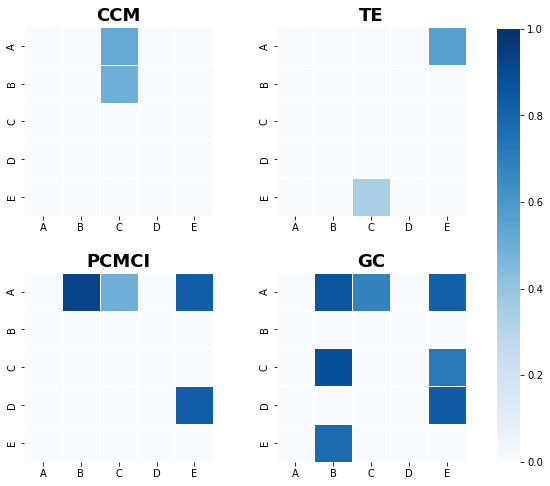

In [22]:
f, axes = plt.subplots(2, 2, figsize=(8,8))

f_1 = sns.heatmap(m_01, 
                  ax=axes[0][0], 
                  vmin=0, 
                  vmax=1, 
                  cmap='Blues', 
                  cbar=False, 
                  linewidths=.5, 
                  xticklabels=feature_names, 
                  yticklabels=feature_names, 
                  square=True)
f_1.set_title('CCM', fontsize=18, fontweight='bold')

f_2 = sns.heatmap(m_02, 
                  ax=axes[0][1], 
                  vmin=0, 
                  vmax=1, 
                  cmap='Blues', 
                  cbar=False, 
                  linewidths=.5, 
                  xticklabels=feature_names, 
                  yticklabels=feature_names, 
                  square=True)
f_2.set_title('TE', fontsize=18, fontweight='bold')

f_3 = sns.heatmap(m_03, 
                  ax=axes[1][0], 
                  vmin=0, 
                  vmax=1, 
                  cmap='Blues', 
                  cbar=False, 
                  linewidths=.5, 
                  xticklabels=feature_names, 
                  yticklabels=feature_names, 
                  square=True)
f_3.set_title('PCMCI', fontsize=18, fontweight='bold')

cbar_ax = f.add_axes([.95, .125, .04, 0.752])
f_4 = sns.heatmap(m_04, 
                  ax=axes[1][1], 
                  vmin=0, 
                  vmax=1, 
                  cmap='Blues', 
                  cbar_ax=cbar_ax, 
                  linewidths=.5, 
                  xticklabels=feature_names, 
                  yticklabels=feature_names, 
                  square=True)
f_4.set_title('GC', fontsize=18, fontweight='bold')

plt.subplots_adjust(wspace=0.3, hspace=0.3)

In [23]:
score = ce.evaluation()
print('Normalized_score:')
print(score)

Normalized_score:
0.7250000000000001


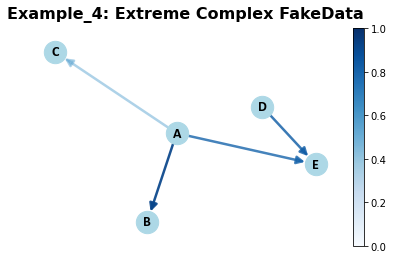

In [24]:
Graphic = causality_plotting(strength=strength_ensemble, 
                             feature_names=feature_names, 
                             title='Example_4: Extreme Complex FakeData', 
                             name_size='short',
                             node_color="lightblue", 
                             title_size=16,
                             seed=0)
plt.savefig('C:/Users/zhipe/OneDrive/Desktop/Master thesis/codes/examples/results/Example_4.jpg', 
            bbox_inches = 'tight',
            pad_inches=0.2,
            dpi=300)

In [24]:
score_matrix, score = test_score(m_01, m_02, m_03, m_04, m_0)
print('Score_matrix:\n',score_matrix)
print('Normalized_score:')
print(score)

Score_matrix:
 [[1.   0.75 0.75 1.   1.  ]
 [1.   1.   1.   1.   1.  ]
 [1.   0.5  1.   1.   1.  ]
 [1.   1.   1.   1.   0.75]
 [1.   0.75 0.75 1.   1.  ]]
Normalized_score:
0.825


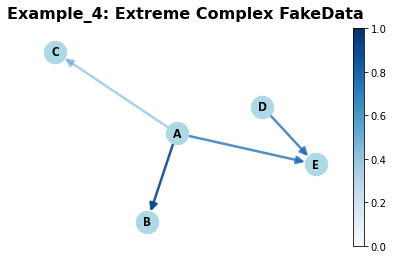

In [25]:
Graphic = causality_plotting(strength=m_0,
                             feature_names=feature_names, 
                             title='Example_4: Extreme Complex FakeData', 
                             node_color="lightblue", 
                             name_size='short',
                             title_size=16,
                             seed=0)
plt.savefig('C:/Users/mzpch/Desktop/Master thesis/codes/examples/results/Example_4.jpg',
            bbox_inches = 'tight',
            pad_inches=0.2,
            dpi=300)

Text(0.5, 1.0, 'Comprehensive Ensemble')

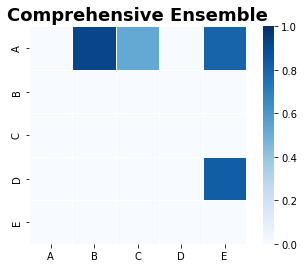

In [25]:
fig_0 = sns.heatmap(strength_ensemble, 
                    vmin=0, 
                    vmax=1, 
                    cmap='Blues', 
                    linewidths=.5, 
                    xticklabels=feature_names, 
                    yticklabels=feature_names, 
                    square=True)
fig_0.set_title('Comprehensive Ensemble', fontsize=18, fontweight='bold')